In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")
import matplotlib.pyplot as plt
import os
import json
import datetime
import numpy as np
import torch
import pandas as pd
from lightcurve_fitting import models as lcmd
import utils.torchphysics as tp
import utils.utils as ut 
import torch
from lightcurve_fitting import filters as flc
import utils.analysis as an

torch.set_default_dtype(torch.float64)


In [3]:
BASE_DIR = os.path.join(ut.storage_parent_path, "experiments")
EXP_NAME = "TEST_DEBUG_1_free_frhom"
EXPERIMENTS_DIR = os.path.join(ut.storage_parent_path, "experiments", EXP_NAME)

In [4]:
all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"][::-1]  # from red to UV
mjd_array = np.linspace(3, 13, 600)


filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

max_days = 10
time_spans = np.arange(1, max_days + 1)  # [1, 2, ..., 10]

model_parameters = [1.2, 2.,2., 4.0, 2.5]

# --- setup light curve builder ---
builder = ut.LCBuilder(
    model_name="sc4",
    model_parameters=model_parameters,
    model_units=[1,1,1,1,1],
    seed=42
)

lc = builder.build_sim_lc(
    mjd_array=mjd_array,
    filters_list=all_filters,  # full set
    redshift=0.00526,
    dlum_factor=1e-1/2,
    dm=31.1,
    dL=19.,
    dLerr=2.9
)

In [5]:
# ==============================================
# 1. Collect all experiments
# ==============================================
records = []

for exp in sorted([f for f in os.listdir(EXPERIMENTS_DIR) if f.startswith("exp_")]):
    exp_path = os.path.join(EXPERIMENTS_DIR, exp)

    if not os.path.isdir(exp_path):
        continue

    config_path = os.path.join(exp_path, "exp_config.json")
    loss_csv_path = os.path.join(exp_path, "history.csv")
    summary_path = os.path.join(exp_path, "summary.txt")

    if not os.path.exists(config_path):
        continue

    with open(config_path, "r") as f:
        cfg = json.load(f)

    # Load last loss value (if available)
    if os.path.exists(loss_csv_path):
        loss_df = pd.read_csv(loss_csv_path)
        final_loss = loss_df["loss"].iloc[-1]
    else:
        raise Exception("No loss found")

    summary = ""
    if os.path.exists(summary_path):
        with open(summary_path, "r") as f:
            summary = f.read().strip()

    records.append({
        "exp_name": exp,
        "filters": "-".join(cfg.get("filters", [])),
        "time_span": cfg.get("time_span"),
        "final_loss": final_loss,
        "n_points": cfg.get("n_points", None),
        "summary": summary
    })


In [6]:
records



[{'exp_name': 'exp__filters-uvw1-u-g-r-i-y-z_time-10d',
  'filters': 'uvw1-u-g-r-i-y-z',
  'time_span': 10.0,
  'final_loss': -74.89633757344102,
  'n_points': 600.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z'], Time=10d, Final loss=-74.8963"},
 {'exp_name': 'exp__filters-uvw1-u-g-r-i-y-z_time-1d',
  'filters': 'uvw1-u-g-r-i-y-z',
  'time_span': 1.0,
  'final_loss': -97.26630749297937,
  'n_points': 60.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z'], Time=1d, Final loss=-97.2663"},
 {'exp_name': 'exp__filters-uvw1-u-g-r-i-y-z_time-2d',
  'filters': 'uvw1-u-g-r-i-y-z',
  'time_span': 2.0,
  'final_loss': -97.30188414278358,
  'n_points': 120.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z'], Time=2d, Final loss=-97.3019"},
 {'exp_name': 'exp__filters-uvw1-u-g-r-i-y-z_time-3d',
  'filters': 'uvw1-u-g-r-i-y-z',
  'time_span': 3.0,
  'final_loss': -75.09417459361671,
  'n_points': 180.0,
  'summary': "Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 

In [7]:

# ==============================================
# 📊 2. Create summary dataframe
# ==============================================
df = pd.DataFrame(records)
df = df.sort_values(by=["filters", "time_span"]).reset_index(drop=True)
print(f"Loaded {len(df)} experiments.")
display(df.head())

# Save master summary CSV
summary_csv = os.path.join(EXPERIMENTS_DIR, "summary_all.csv")
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")


Loaded 70 experiments.


exp_name filters  time_span  final_loss  n_points  \
0  exp__filters-uvw1_time-1d    uvw1        1.0  -54.780582       6.0   
1  exp__filters-uvw1_time-2d    uvw1        2.0  -76.142759      11.0   
2  exp__filters-uvw1_time-3d    uvw1        3.0  -91.407216      24.0   
3  exp__filters-uvw1_time-4d    uvw1        4.0  -43.226627      33.0   
4  exp__filters-uvw1_time-5d    uvw1        5.0  -52.545368      45.0   

                                          summary  
0  Filters=['uvw1'], Time=1d, Final loss=-54.7806  
1  Filters=['uvw1'], Time=2d, Final loss=-76.1428  
2  Filters=['uvw1'], Time=3d, Final loss=-91.4072  
3  Filters=['uvw1'], Time=4d, Final loss=-43.2266  
4  Filters=['uvw1'], Time=5d, Final loss=-52.5454

Summary saved to: /tf/astrodados2/pilca.storage/experiments/TEST_DEBUG_1_free_frhom/summary_all.csv


In [8]:
df

exp_name           filters  time_span  \
0                exp__filters-uvw1_time-1d              uvw1        1.0   
1                exp__filters-uvw1_time-2d              uvw1        2.0   
2                exp__filters-uvw1_time-3d              uvw1        3.0   
3                exp__filters-uvw1_time-4d              uvw1        4.0   
4                exp__filters-uvw1_time-5d              uvw1        5.0   
..                                     ...               ...        ...   
65   exp__filters-uvw1-u-g-r-i-y-z_time-6d  uvw1-u-g-r-i-y-z        6.0   
66   exp__filters-uvw1-u-g-r-i-y-z_time-7d  uvw1-u-g-r-i-y-z        7.0   
67   exp__filters-uvw1-u-g-r-i-y-z_time-8d  uvw1-u-g-r-i-y-z        8.0   
68   exp__filters-uvw1-u-g-r-i-y-z_time-9d  uvw1-u-g-r-i-y-z        9.0   
69  exp__filters-uvw1-u-g-r-i-y-z_time-10d  uvw1-u-g-r-i-y-z       10.0   

    final_loss  n_points                                            summary  
0   -54.780582       6.0     Filters=['uvw1'], Time=1d, Final loss=-54.7806  
1   -76.142759      11.0     Filters=['uvw1'], Time=2d, Final loss=-76.1428  
2   -91.407216      24.0     Filters=['uvw1'], Time=3d, Final loss=-91.4072  
3   -43.226627      33.0     Filters=['uvw1'], Time=4d, Final loss=-43.2266  
4   -52.545368      45.0     Filters=['uvw1'], Time=5d, Final loss=-52.5454  
..         ...       ...                                                ...  
65  -81.843515     360.0  Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z']...  
66  -67.631350     420.0  Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z']...  
67  -58.570373     480.0  Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z']...  
68  -56.695056     540.0  Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z']...  
69  -74.896338     600.0  Filters=['uvw1', 'u', 'g', 'r', 'i', 'y', 'z']...  

[70 rows x 6 columns]

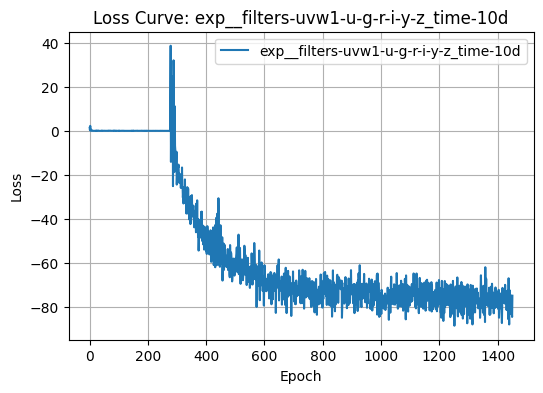

In [9]:

# ==============================================
# 📈 3. Visualize loss evolution per experiment
# ==============================================
def plot_loss(exp_name):
    exp_path = os.path.join(EXPERIMENTS_DIR, exp_name)
    loss_csv_path = os.path.join(exp_path, "history.csv")
    if not os.path.exists(loss_csv_path):
        print("No loss history for:", exp_name)
        return
    df_loss = pd.read_csv(loss_csv_path)
    plt.figure(figsize=(6,4))
    plt.plot(df_loss["loss"], label=exp_name)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve: {exp_name}")
    plt.grid(True)
    plt.legend()
    plt.show()
# Example: plot the last experiment's loss
plot_loss(df.iloc[-1]["exp_name"])

In [10]:
all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"][::-1]  # from red to UV
max_days = 10
time_spans = np.arange(1, max_days + 1)
filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

metrics = ["loss", "chi2", "cdf", "perdev"]

# Initialize result dictionary
result_dict = {m: {filt: np.full(len(time_spans), np.nan, dtype=object) for filt in all_filters} for m in metrics}

for filt_subset in filter_combinations:
    last_f = filt_subset[-1]
    
    for i, tspan in enumerate(time_spans):
        # print(filt_subset, tspan)
        suffix = f"_filters-{'-'.join(filt_subset)}_time-{tspan}d"
        ename = f"exp_{suffix}"
        exp_dir = os.path.join(EXPERIMENTS_DIR, ename)
        if not os.path.isdir(exp_dir):
            continue

        # Find row in df
        row = df[df["exp_name"] == ename]
        if row.empty:
            continue

        # --- Store scalar loss ---
        result_dict["loss"][last_f][i] = row.final_loss.values[0]

        # --- Load samples and compute metrics ---
        samples = np.load(os.path.join(exp_dir, "samples.npy"))
        # print(samples.shape)
        res = an.evaluate_sampling(lc, model_name="sc4", samples=samples, true_p=model_parameters)

        # Store results
        # chi2 = res["chi2"]
        # print(chi2)
        # aaa
        result_dict["chi2"][last_f][i] = res["chi2"] if res["chi2"]<1 else np.nan
        result_dict["cdf"][last_f][i] = res["cdf"]   # vector per parameter
        result_dict["perdev"][last_f][i] = res["perdev"]  # vector per parameter

# --- Convert to DataFrames for each metric ---
df_loss  = pd.DataFrame({f: result_dict["loss"][f]  for f in all_filters})
df_chi2  = pd.DataFrame({f: result_dict["chi2"][f]  for f in all_filters})
df_cdf   = pd.DataFrame({f: result_dict["cdf"][f]   for f in all_filters})
df_pdev  = pd.DataFrame({f: result_dict["perdev"][f] for f in all_filters})

# Example: access cdf for filter 'r' and time span 5
print(df_cdf["r"][4])  # vector of per-parameter cdf values



[0.62  0.873 0.055 0.    0.123]


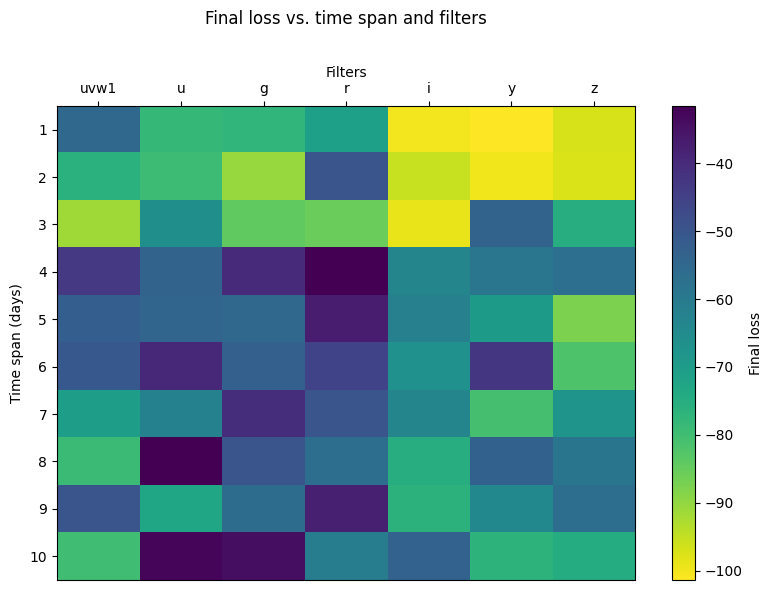

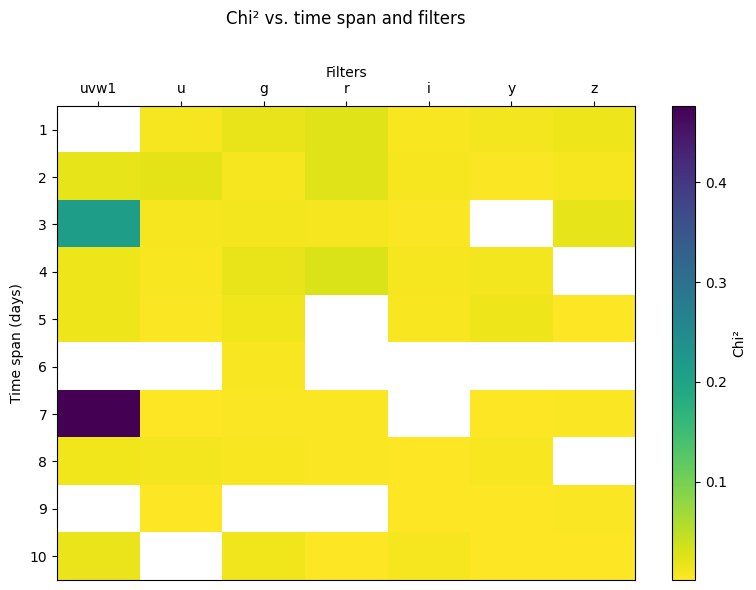

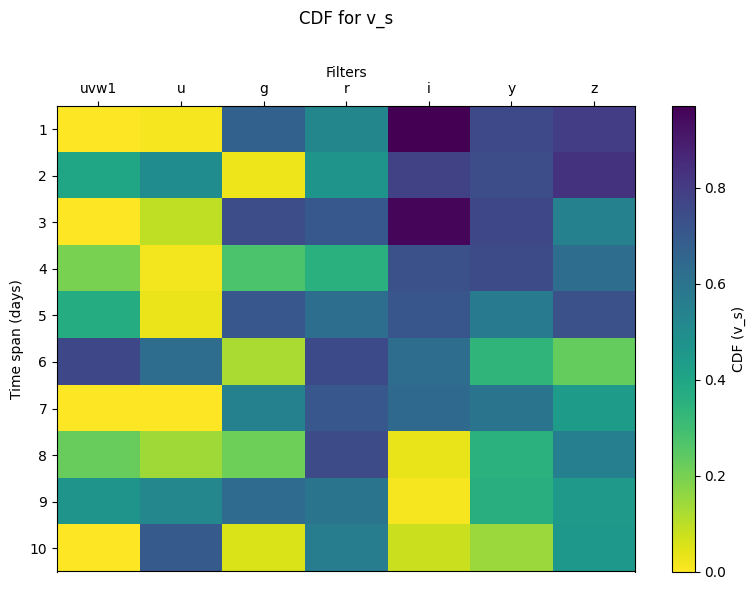

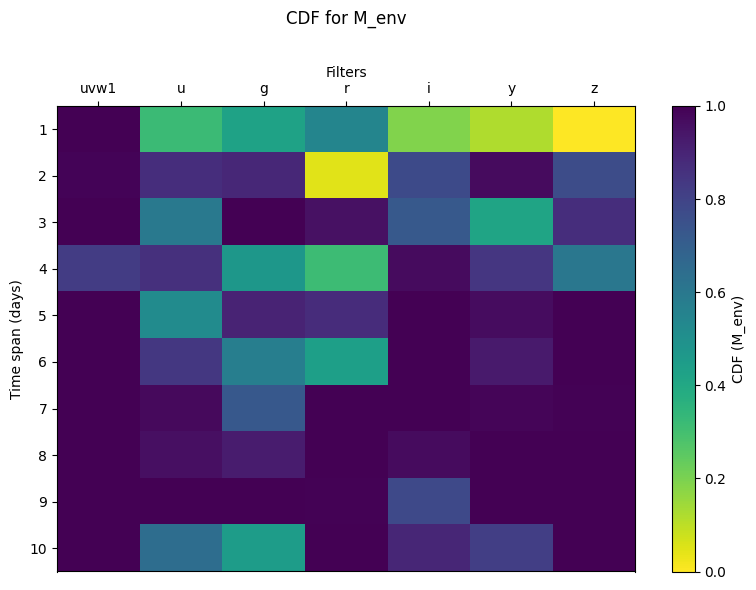

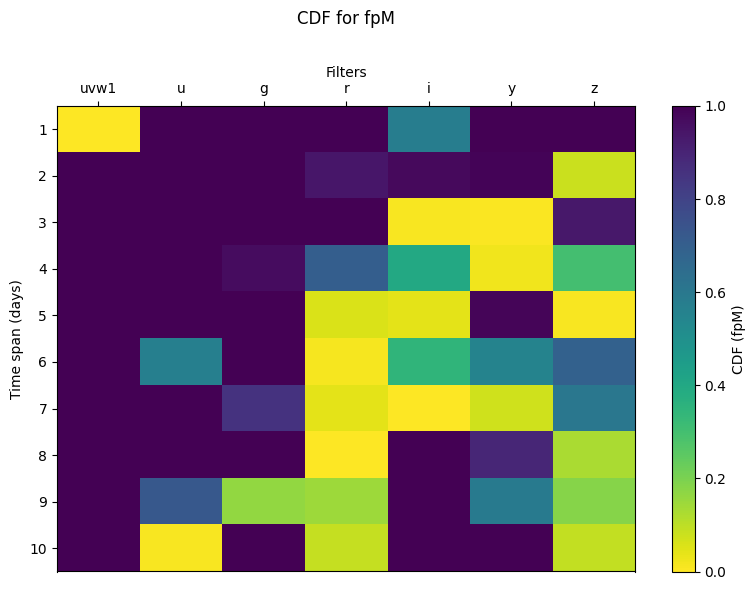

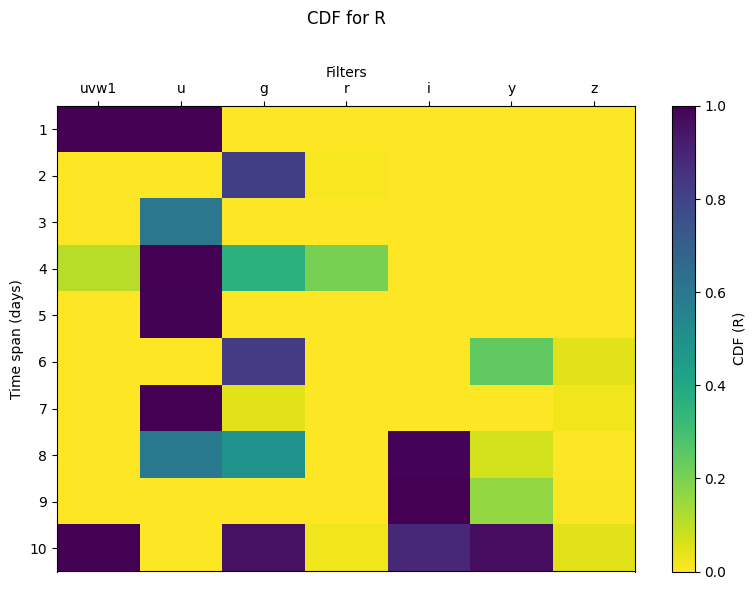

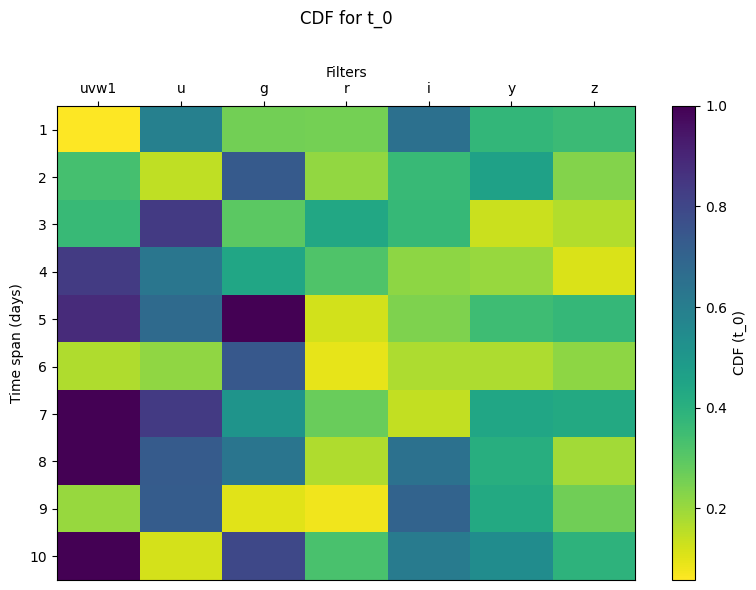

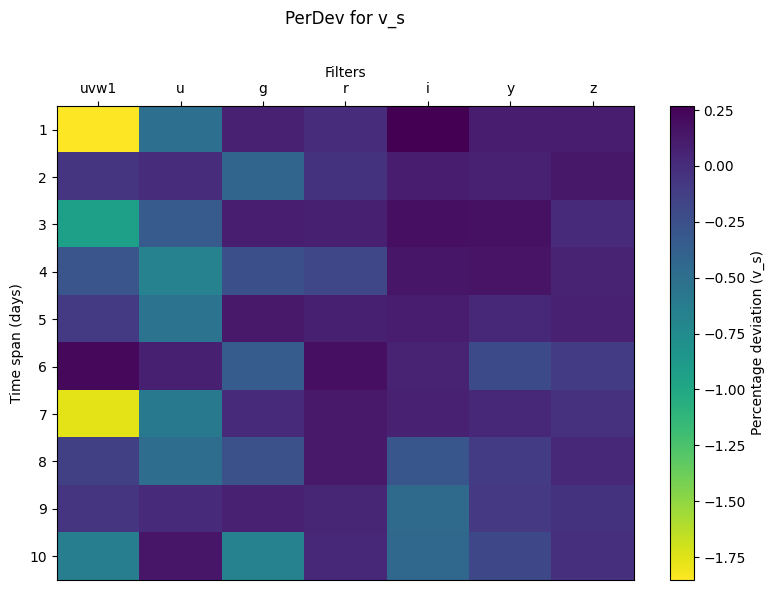

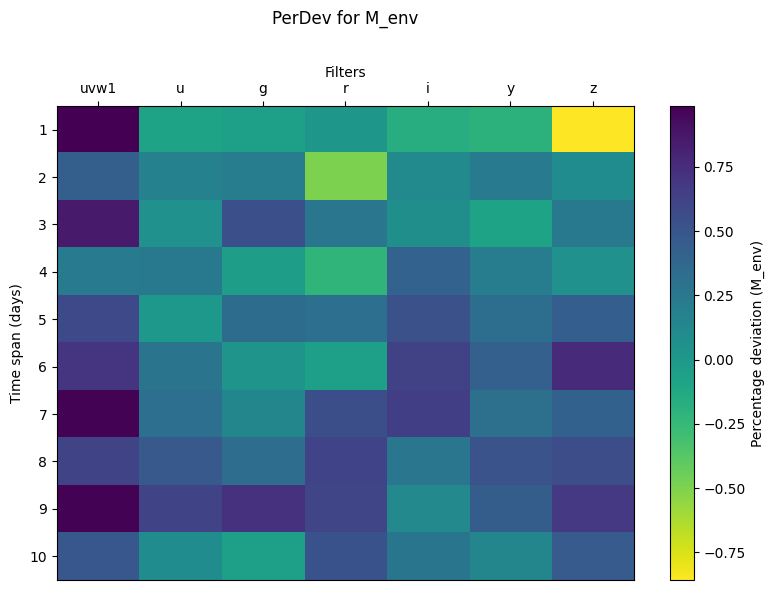

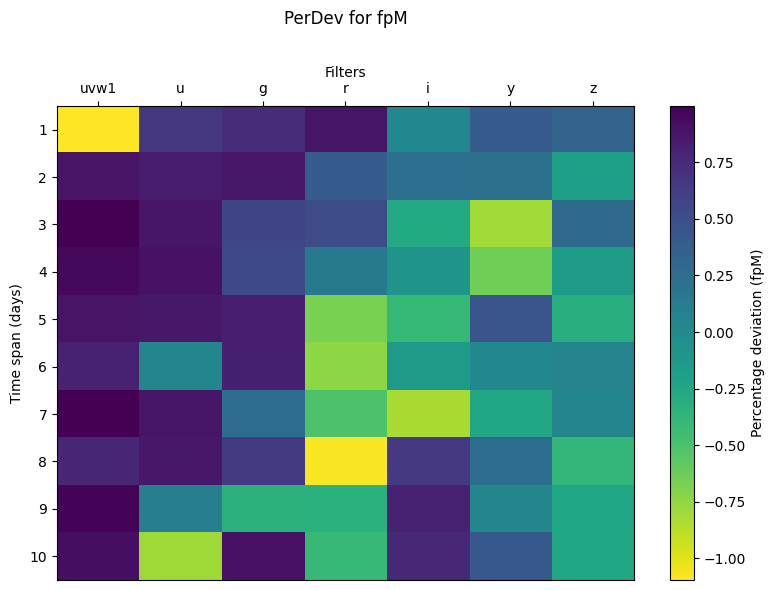

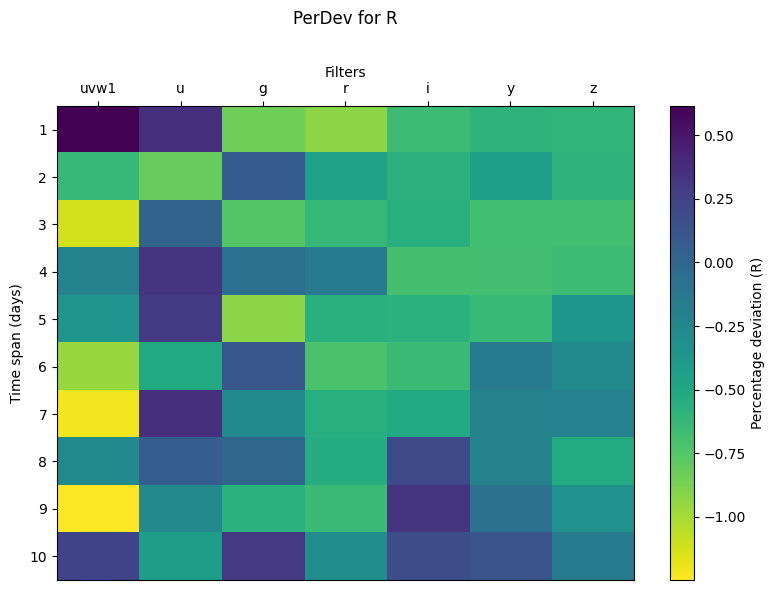

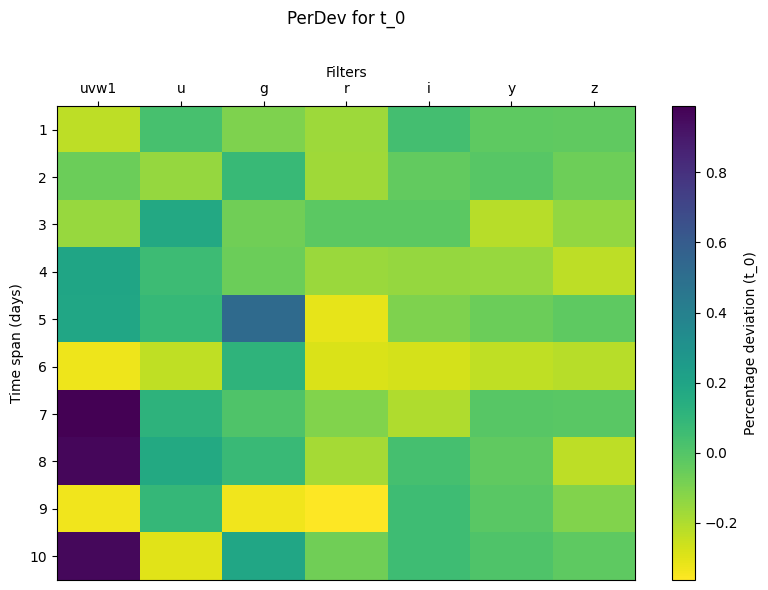

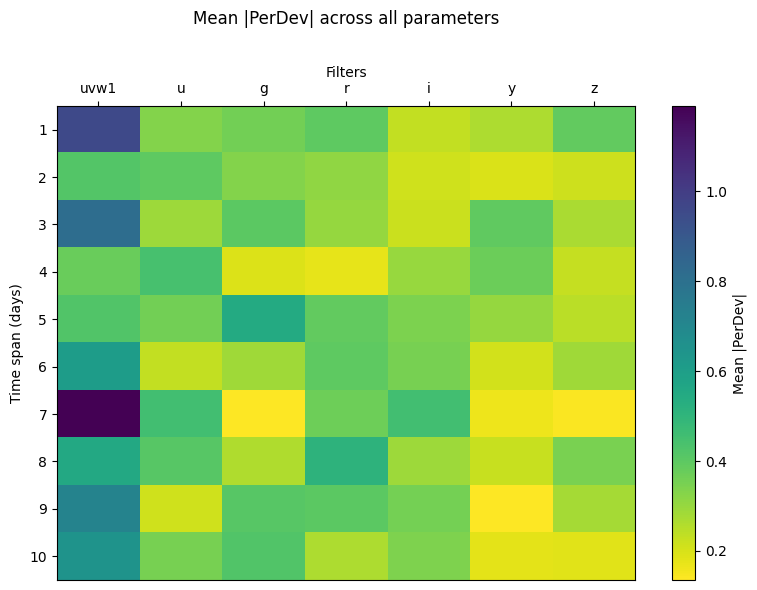

In [12]:
param_names = ["v_s", "M_env", "fpM", "R", "t_0"]

def plot_heatmap(matrix, title, cbar_label, cmap="viridis_r", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(matrix.astype(float), aspect="auto", cmap=cmap, origin="upper", vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_xticklabels(matrix.columns)
    ax.set_yticks(np.arange(len(matrix.index)))
    ax.set_yticklabels(matrix.index+1)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlabel("Filters")
    ax.set_ylabel("Time span (days)")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)
    plt.title(title, pad=30)
    plt.tight_layout()
    plt.show()

# ===================================================
# Helper to safely extract numeric arrays
# ===================================================
def safe_extract(df_metric, index, col, param_idx=None):
    val = df_metric.iloc[index, col]
    if isinstance(val, (list, np.ndarray)):
        if param_idx is not None and len(val) > param_idx:
            return float(val[param_idx])
        return np.nanmean(val).astype(float)
    try:
        return float(val)
    except (TypeError, ValueError):
        return np.nan

# 1️⃣ Global metrics
plot_heatmap(df_loss.fillna(np.nan), "Final loss vs. time span and filters", "Final loss")
plot_heatmap(df_chi2.fillna(np.nan), "Chi² vs. time span and filters", "Chi²")

# 2️⃣ Per-parameter CDF and PerDev
for mname, df_metric, label in [("CDF", df_cdf, "CDF"), ("PerDev", df_pdev, "Percentage deviation")]:
    for i, pname in enumerate(param_names):
        values = np.full((len(df_metric.index), len(df_metric.columns)), np.nan)
        for r in range(len(df_metric.index)):
            for c in range(len(df_metric.columns)):
                values[r, c] = safe_extract(df_metric, r, c, param_idx=i)
        temp_df = pd.DataFrame(values, index=df_metric.index, columns=df_metric.columns)
        plot_heatmap(temp_df, f"{mname} for {pname}", f"{label} ({pname})")

# 3️⃣ Global mean absolute perdev
values = np.full((len(df_pdev.index), len(df_pdev.columns)), np.nan)
for r in range(len(df_pdev.index)):
    for c in range(len(df_pdev.columns)):
        val = df_pdev.iloc[r, c]
        if isinstance(val, (list, np.ndarray)):
            try:
                values[r, c] = np.nanmean(np.abs(val)).astype(float)
            except:
                values[r, c] = np.nan
        else:
            try:
                values[r, c] = abs(float(val))
            except:
                values[r, c] = np.nan
global_perdev_df = pd.DataFrame(values, index=df_pdev.index, columns=df_pdev.columns)
plot_heatmap(global_perdev_df, "Mean |PerDev| across all parameters", "Mean |PerDev|")

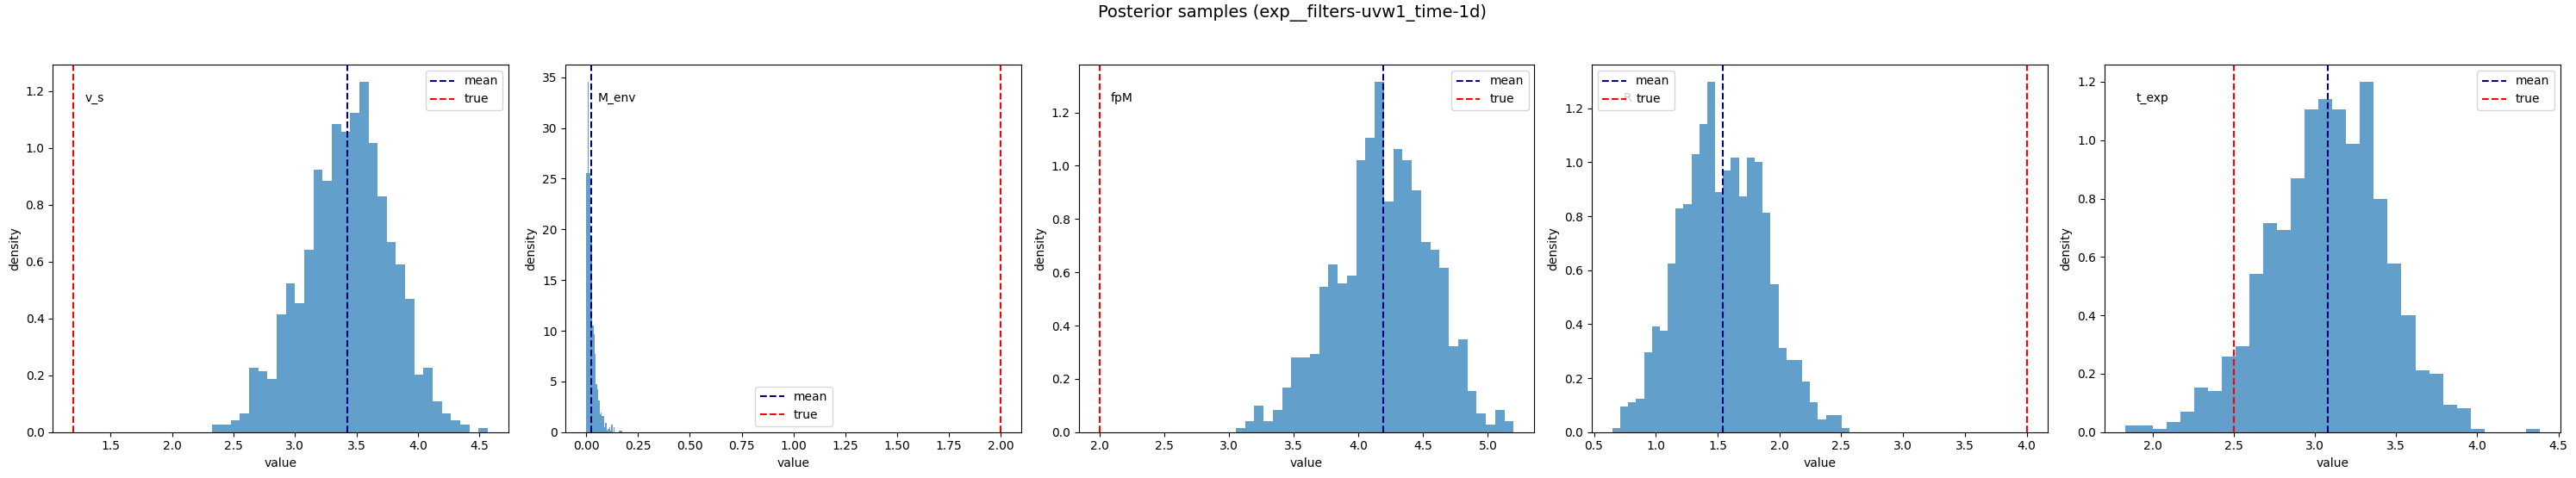

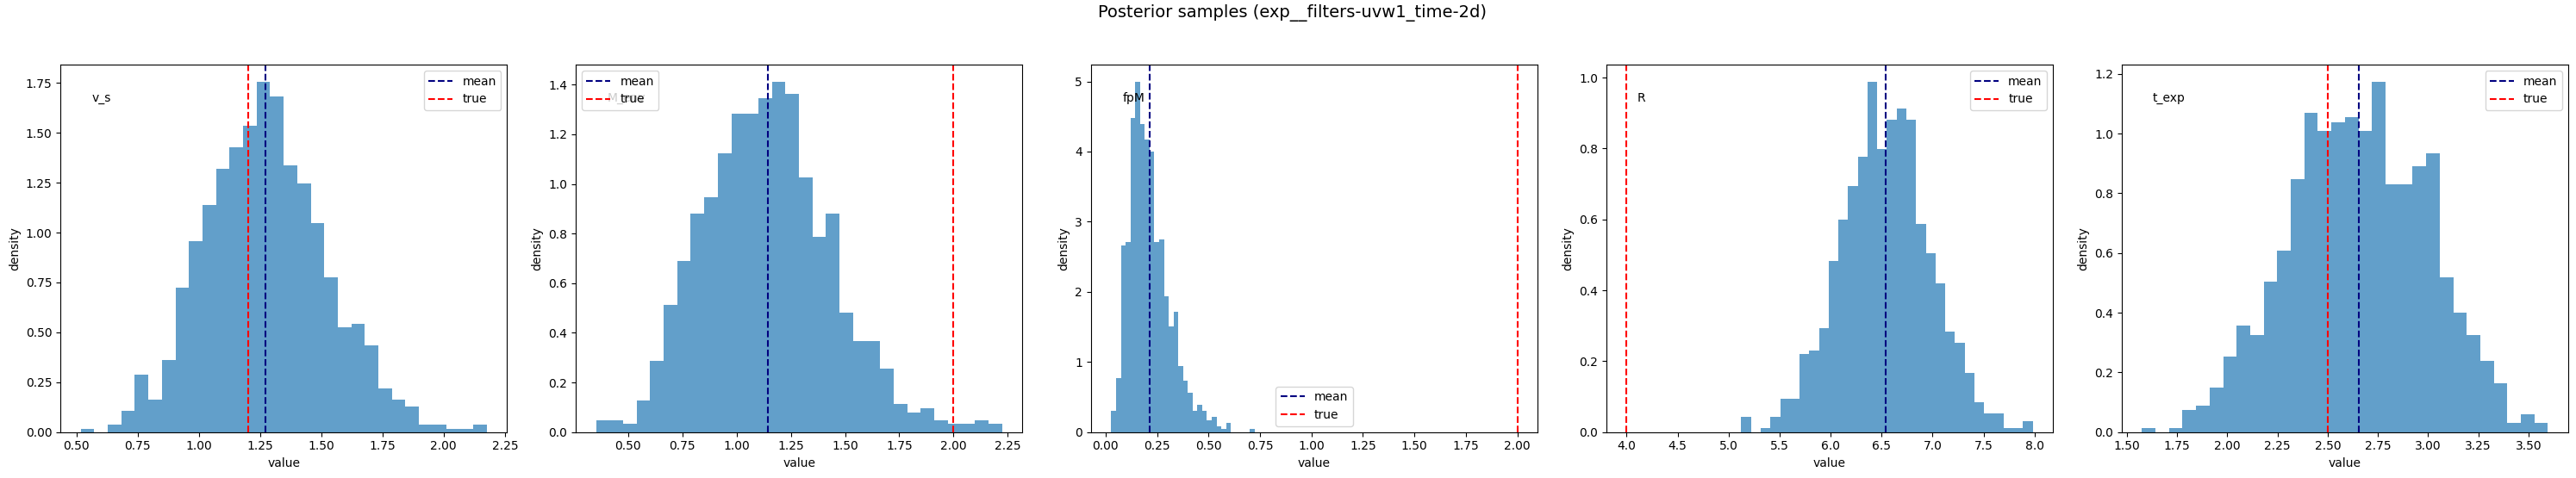

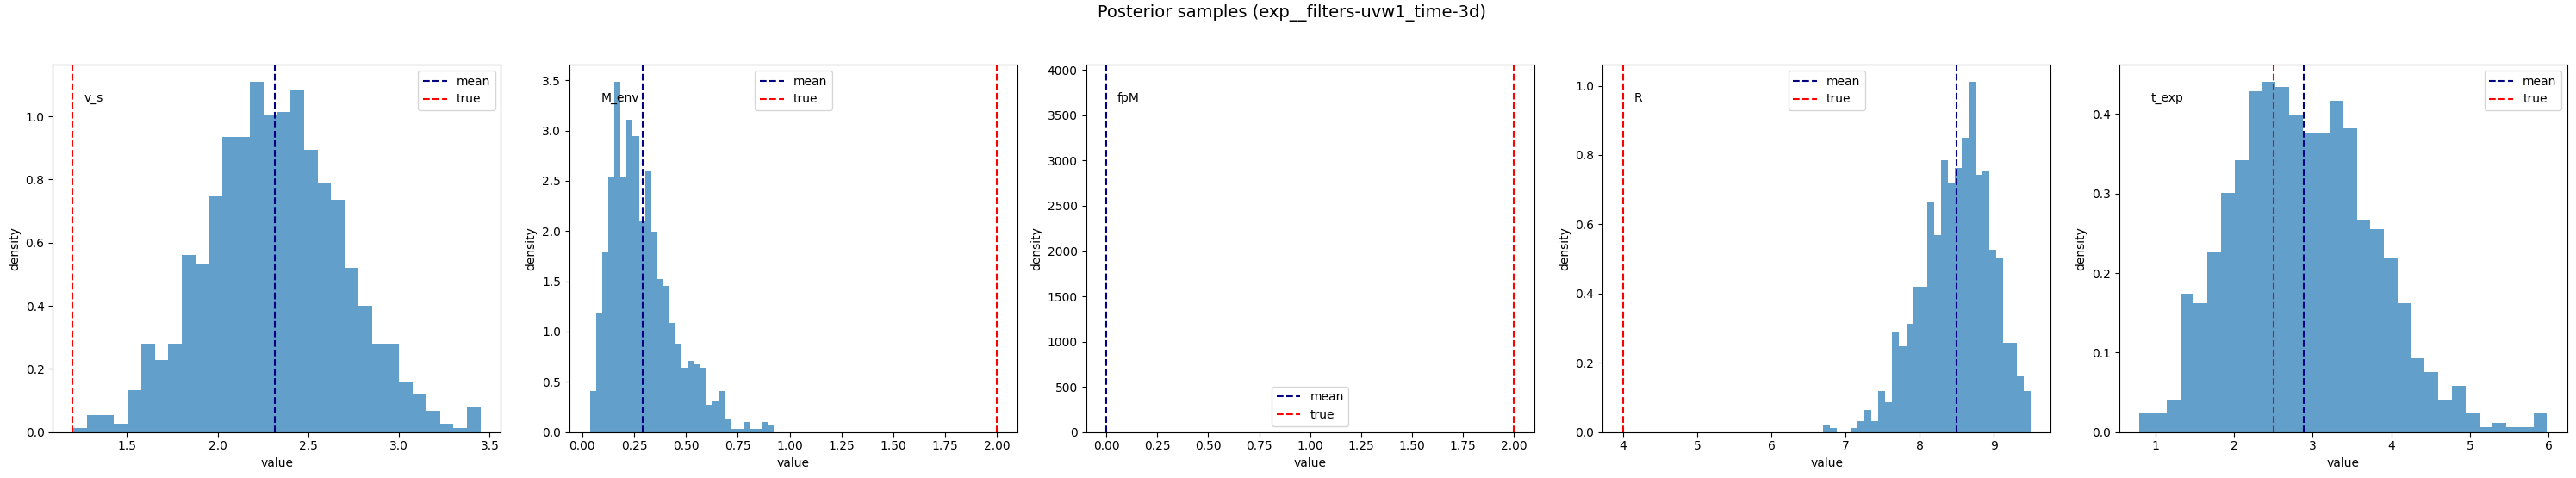

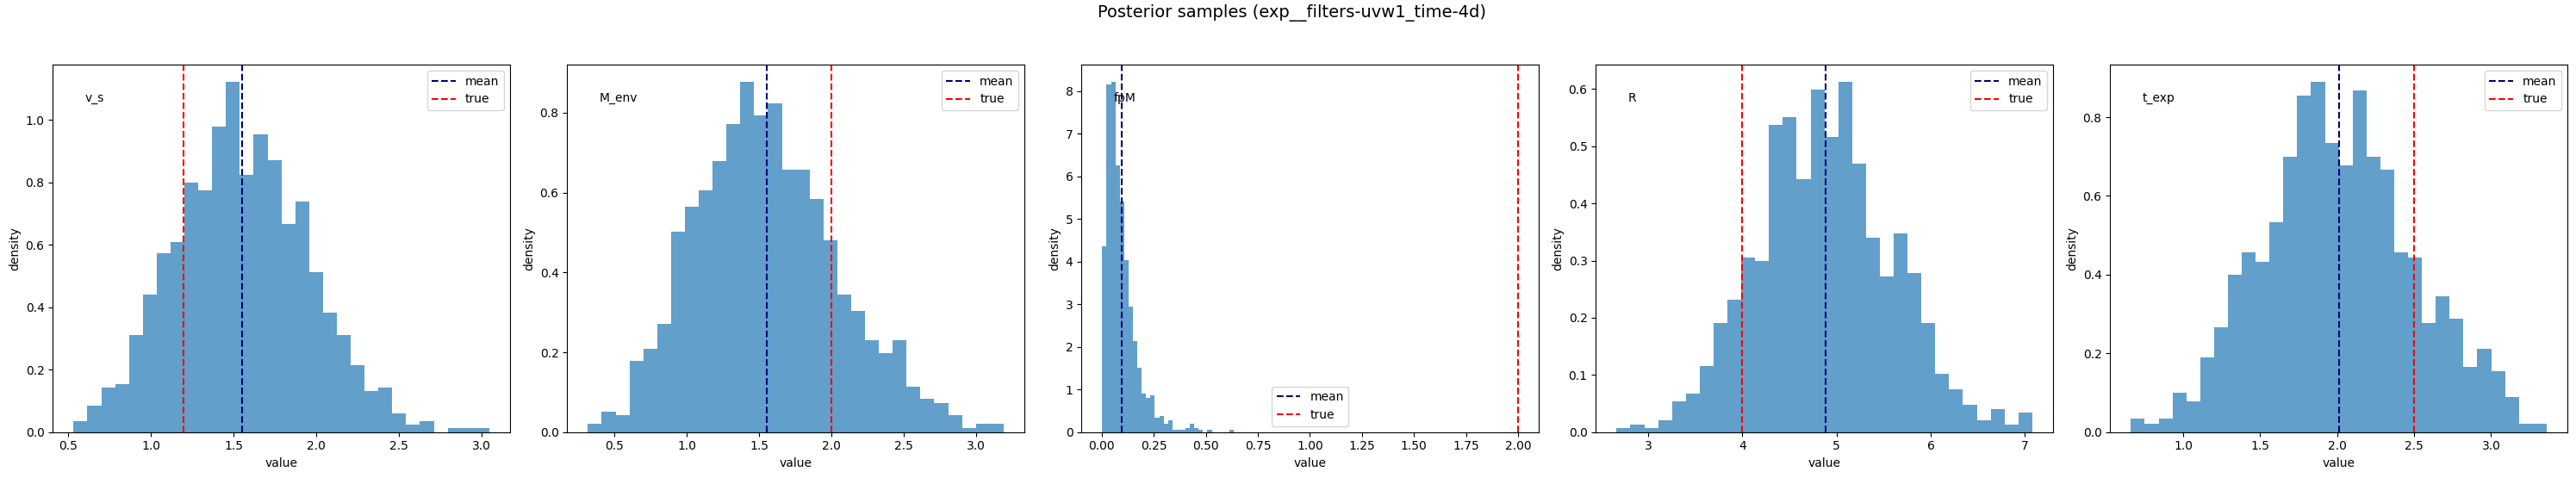

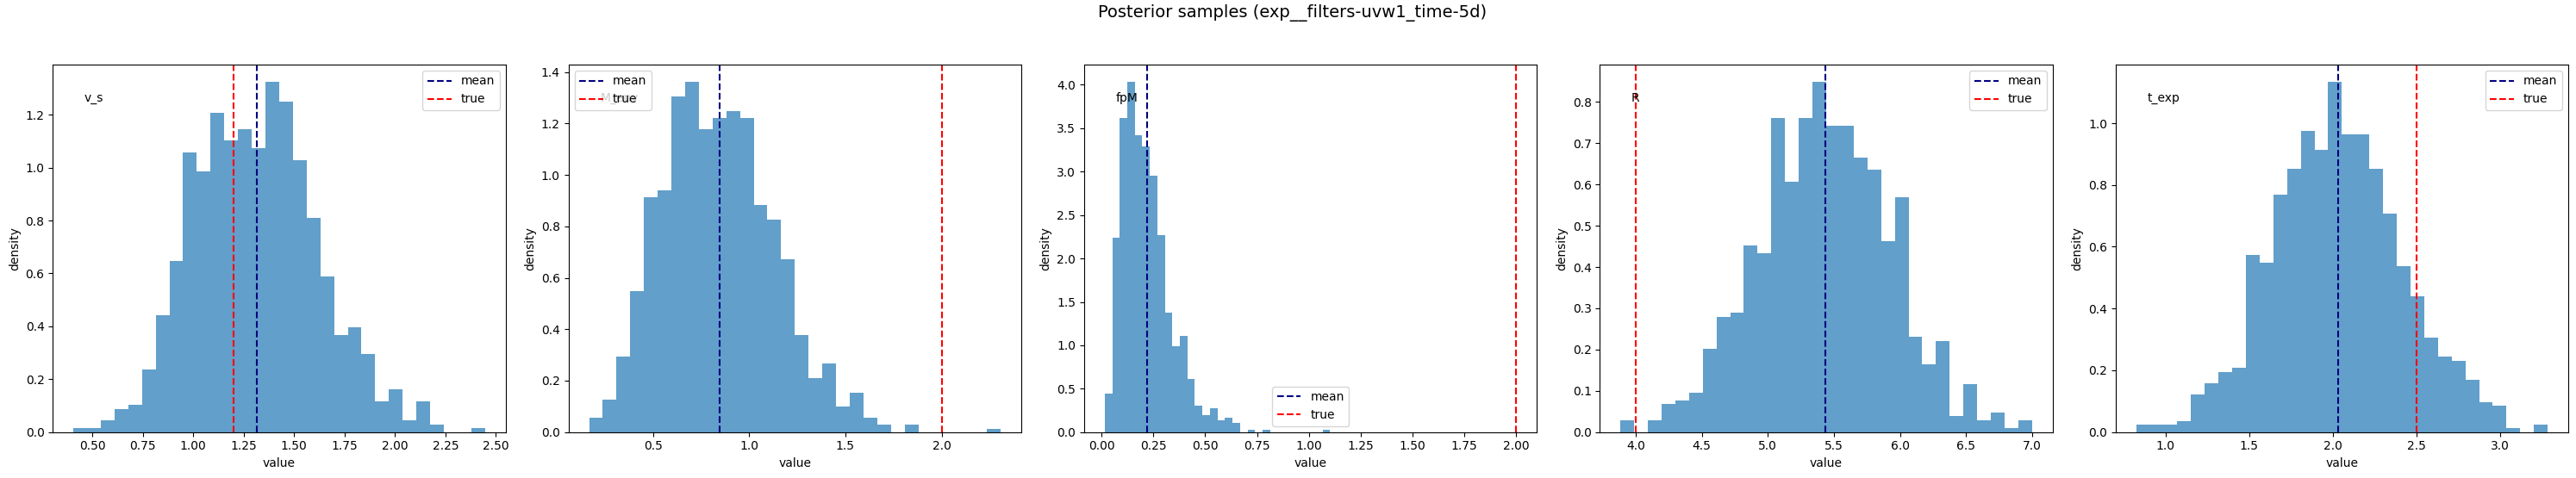

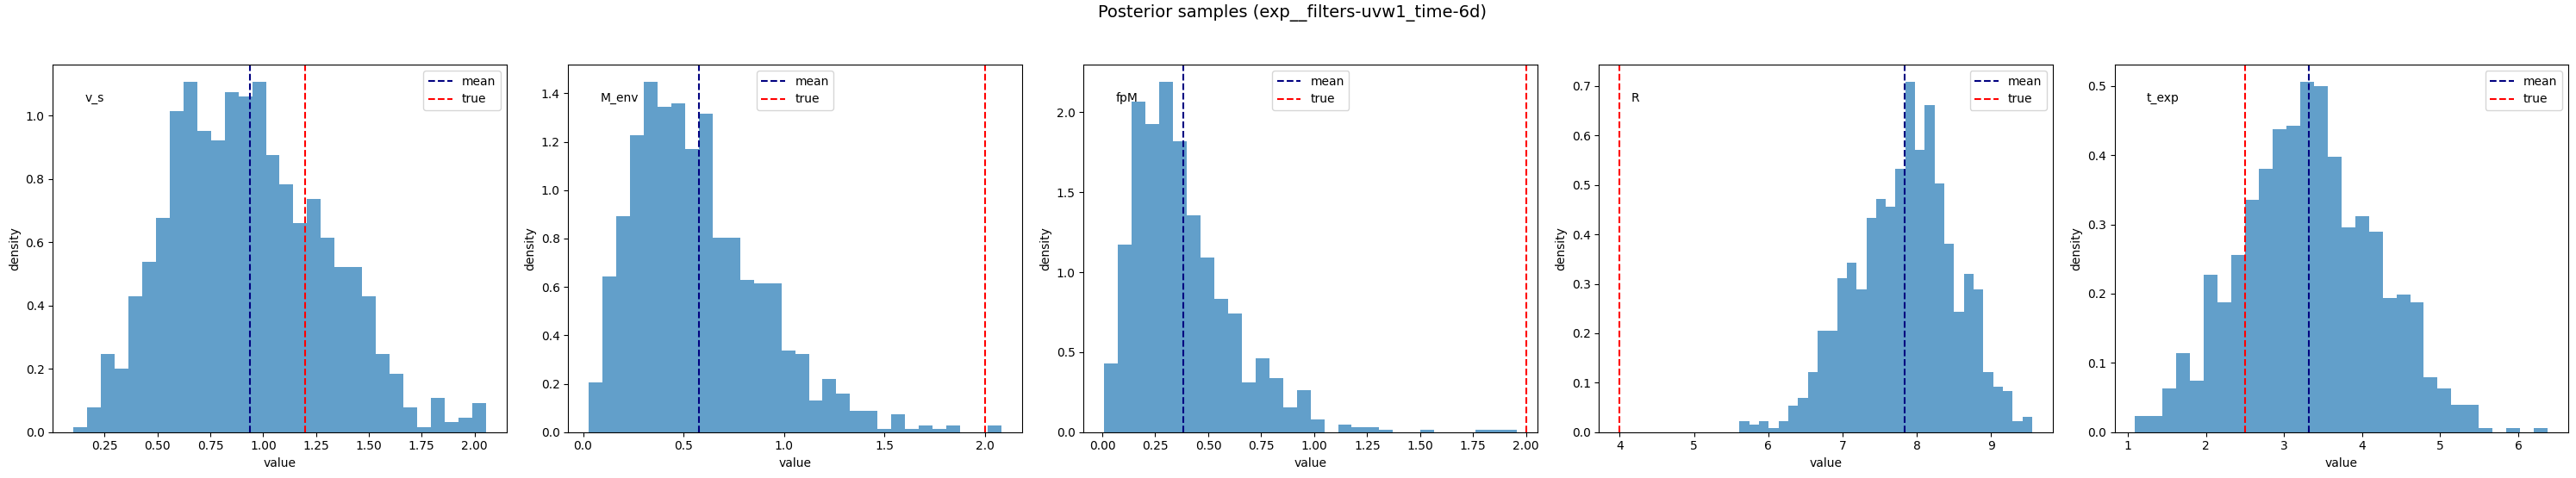

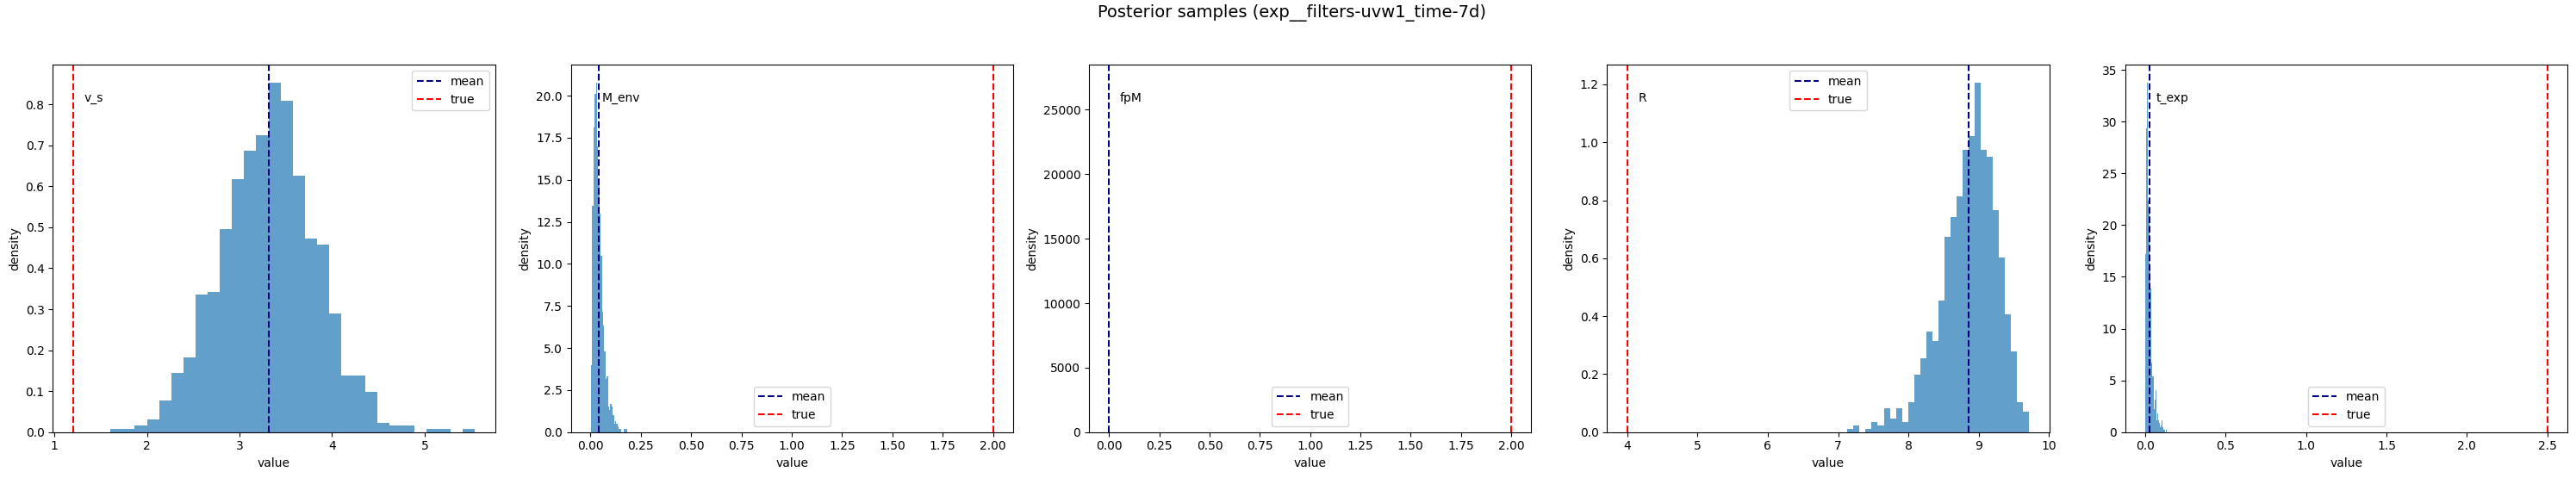

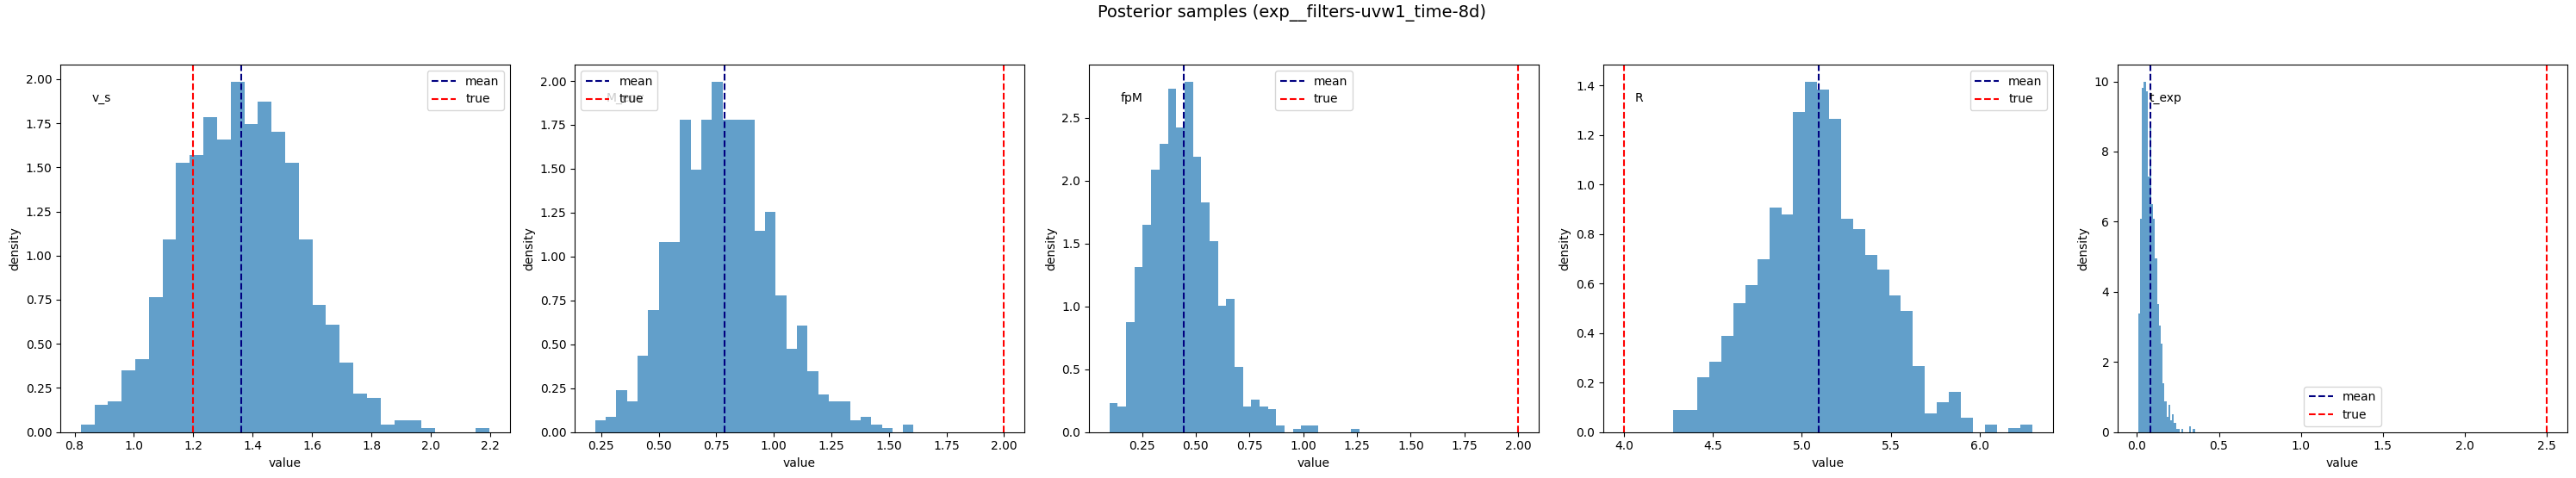

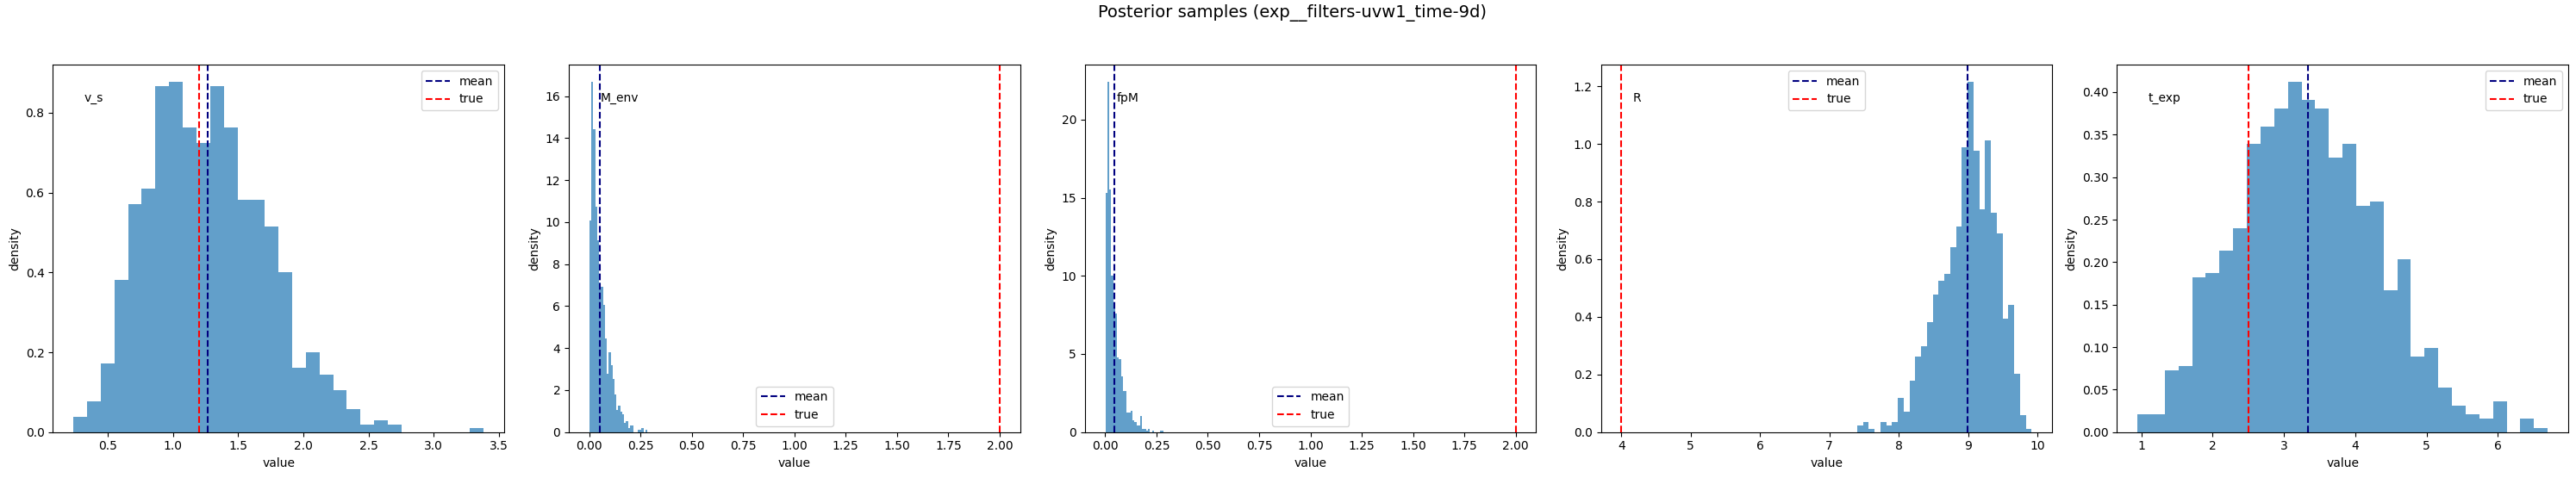

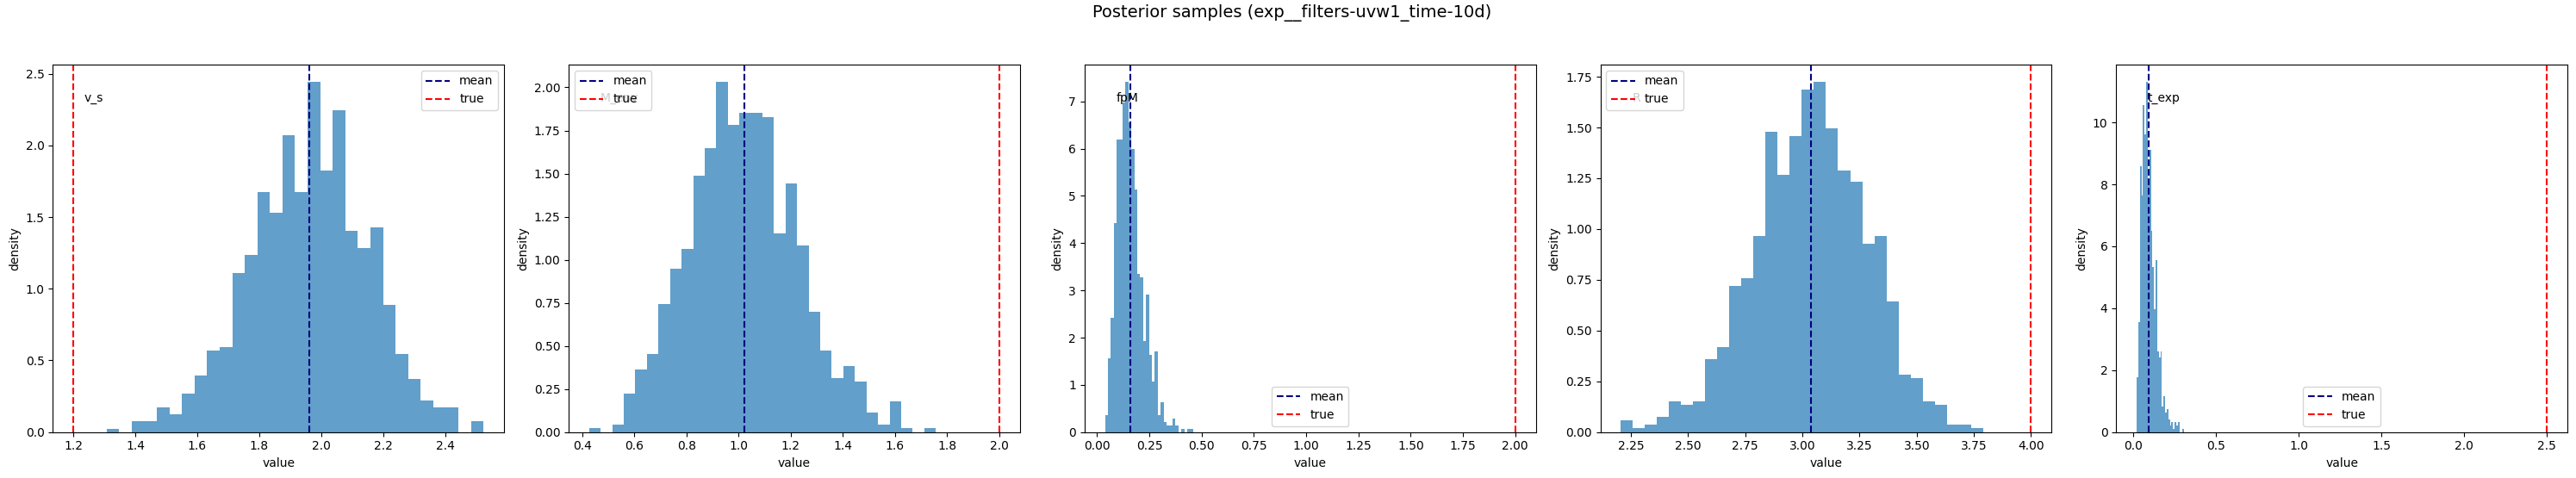

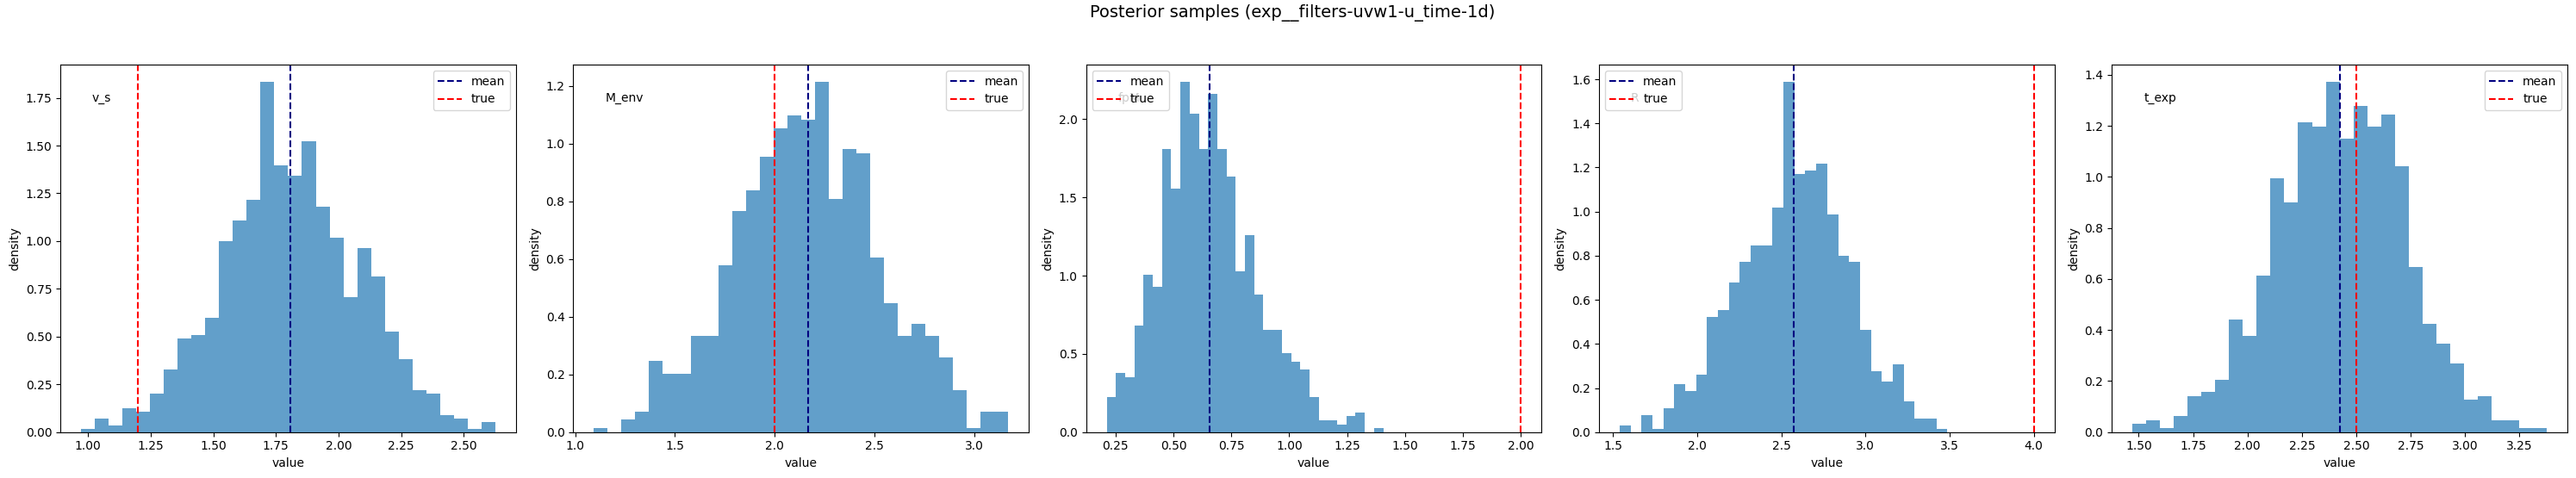

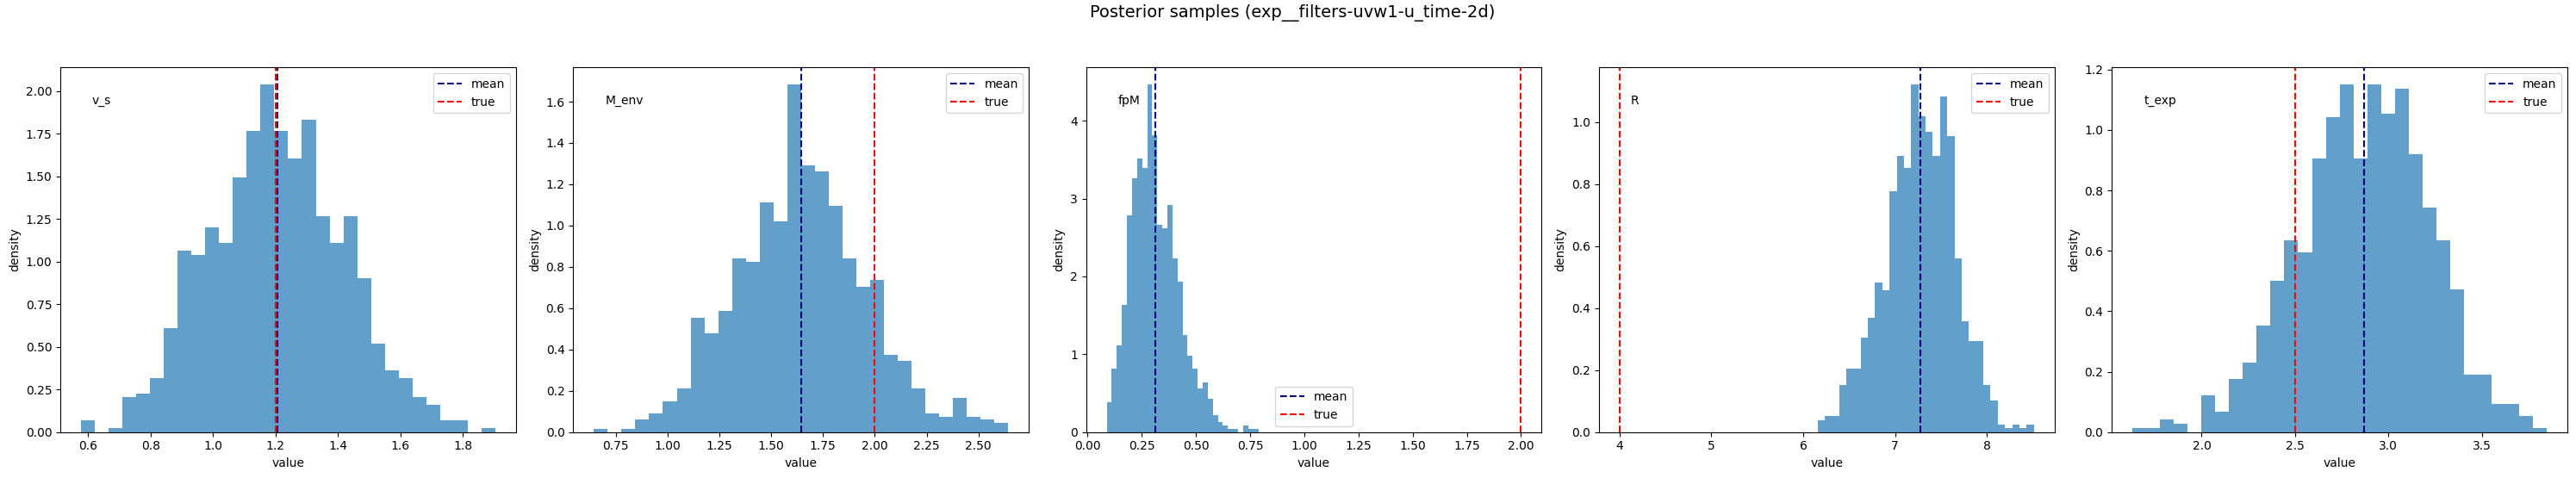

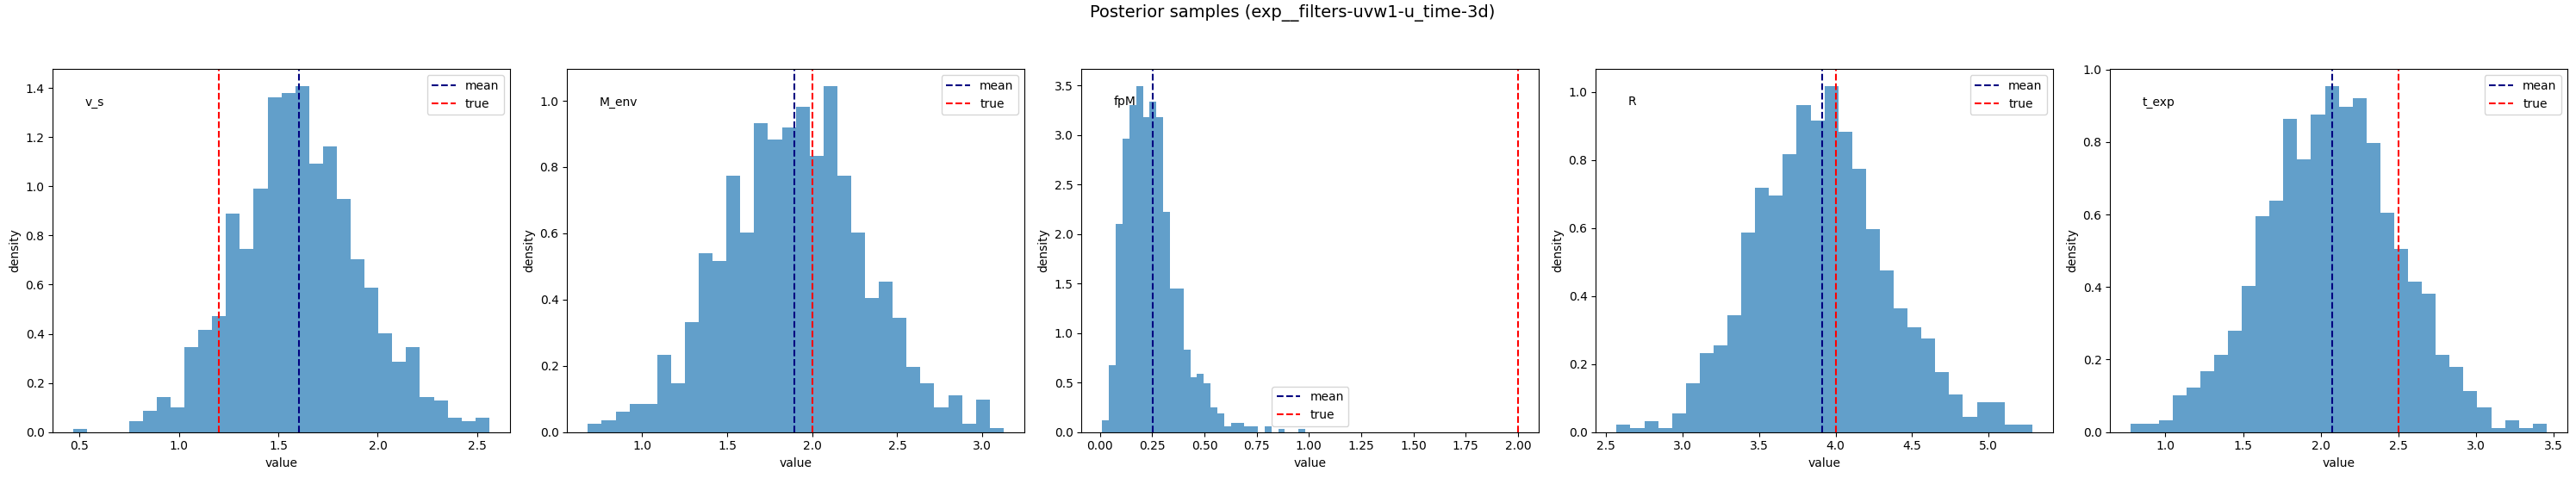

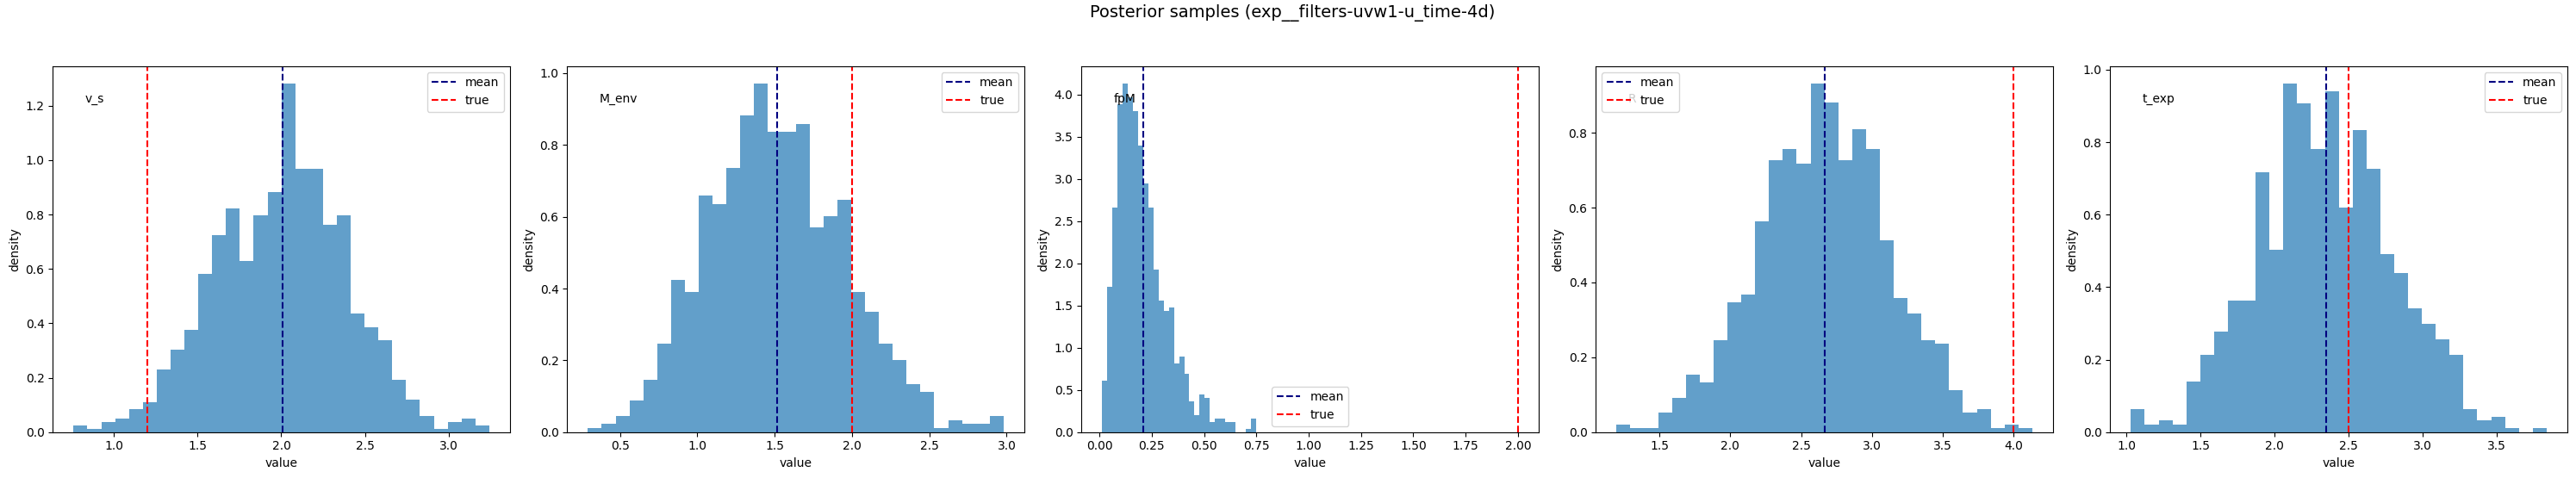

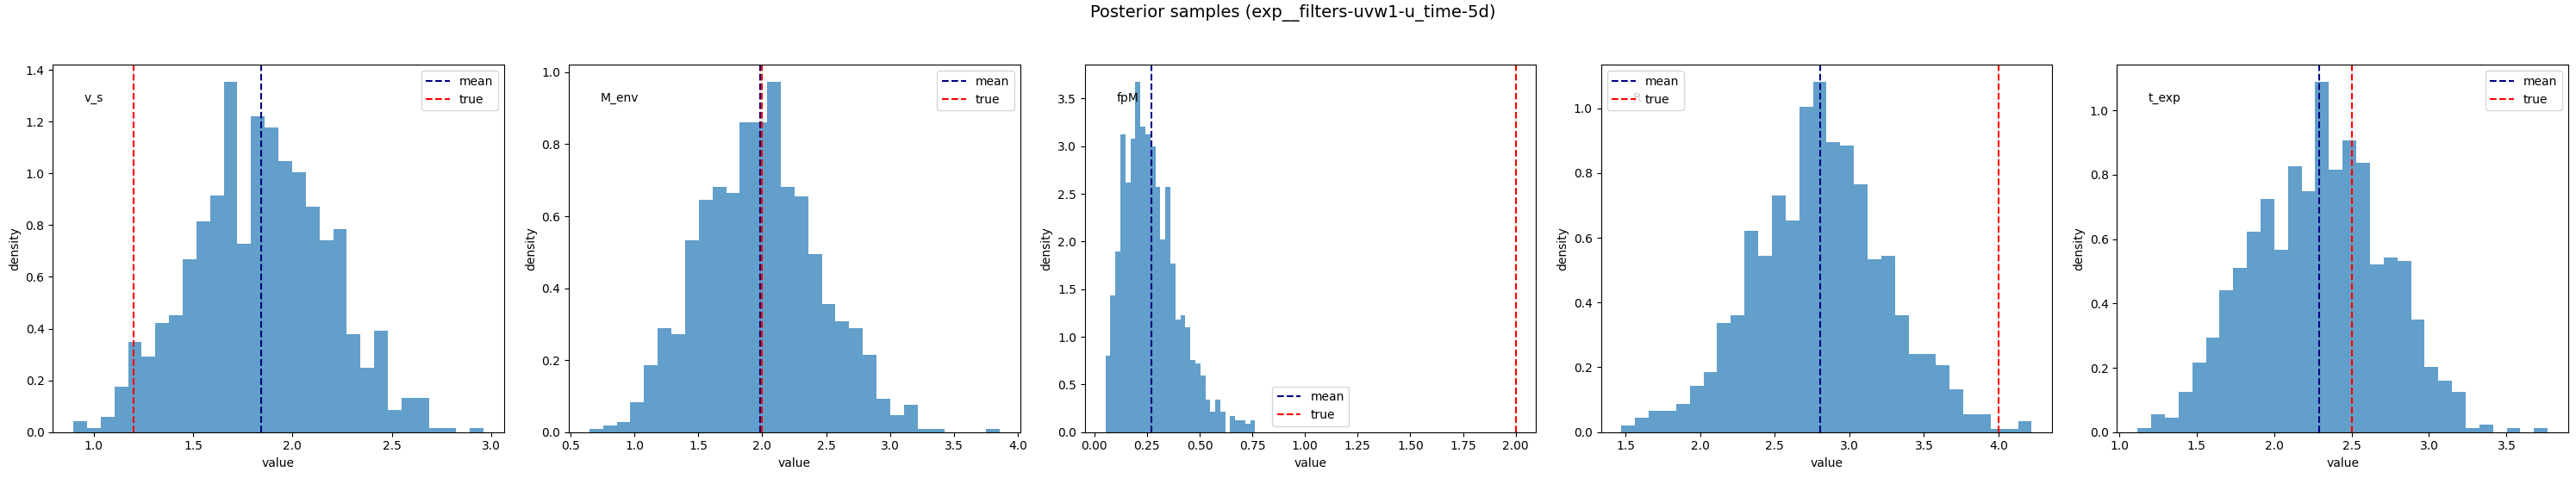

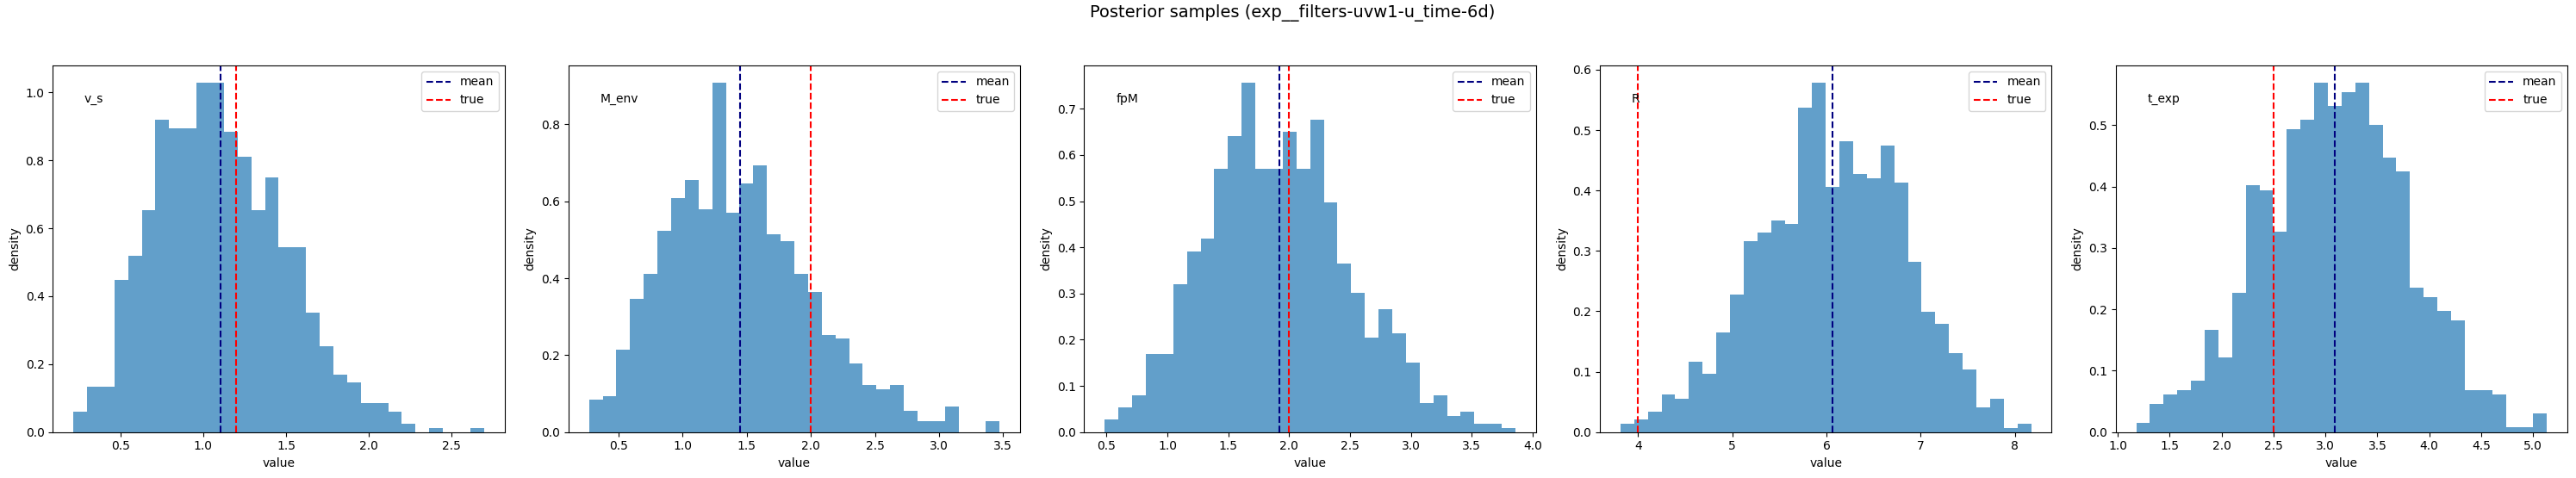

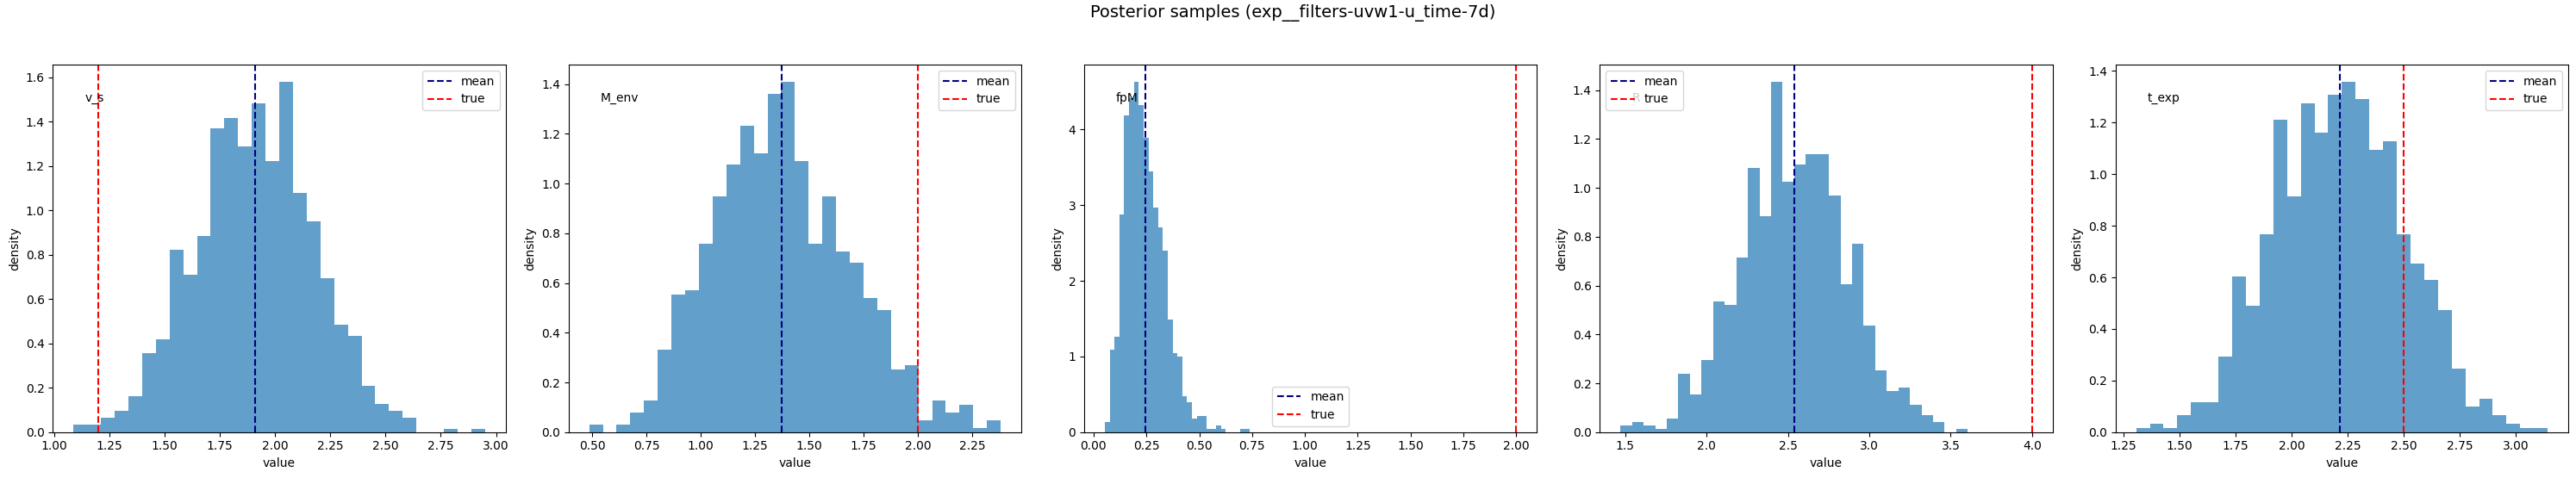

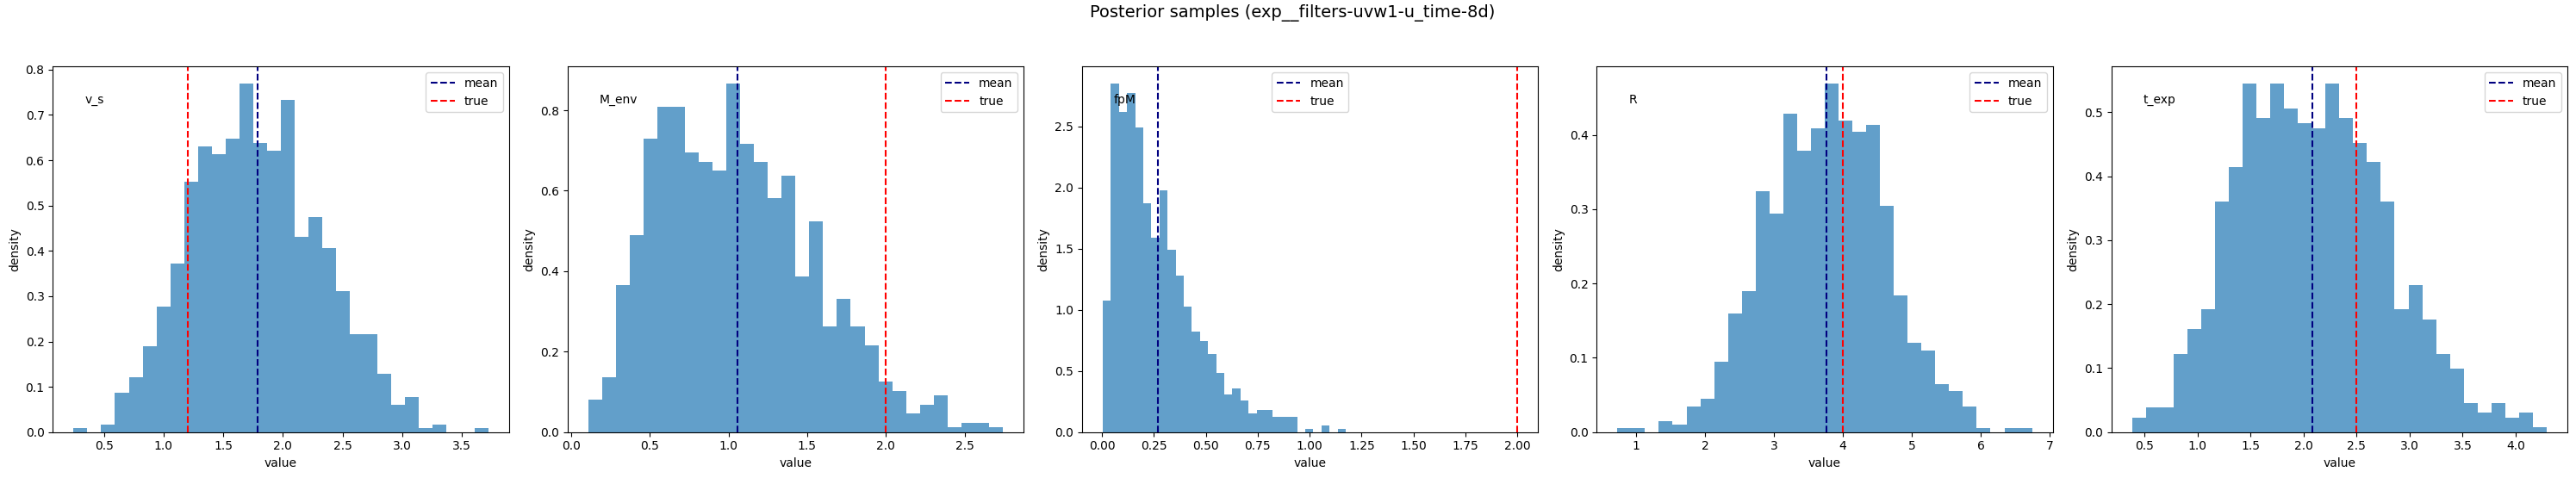

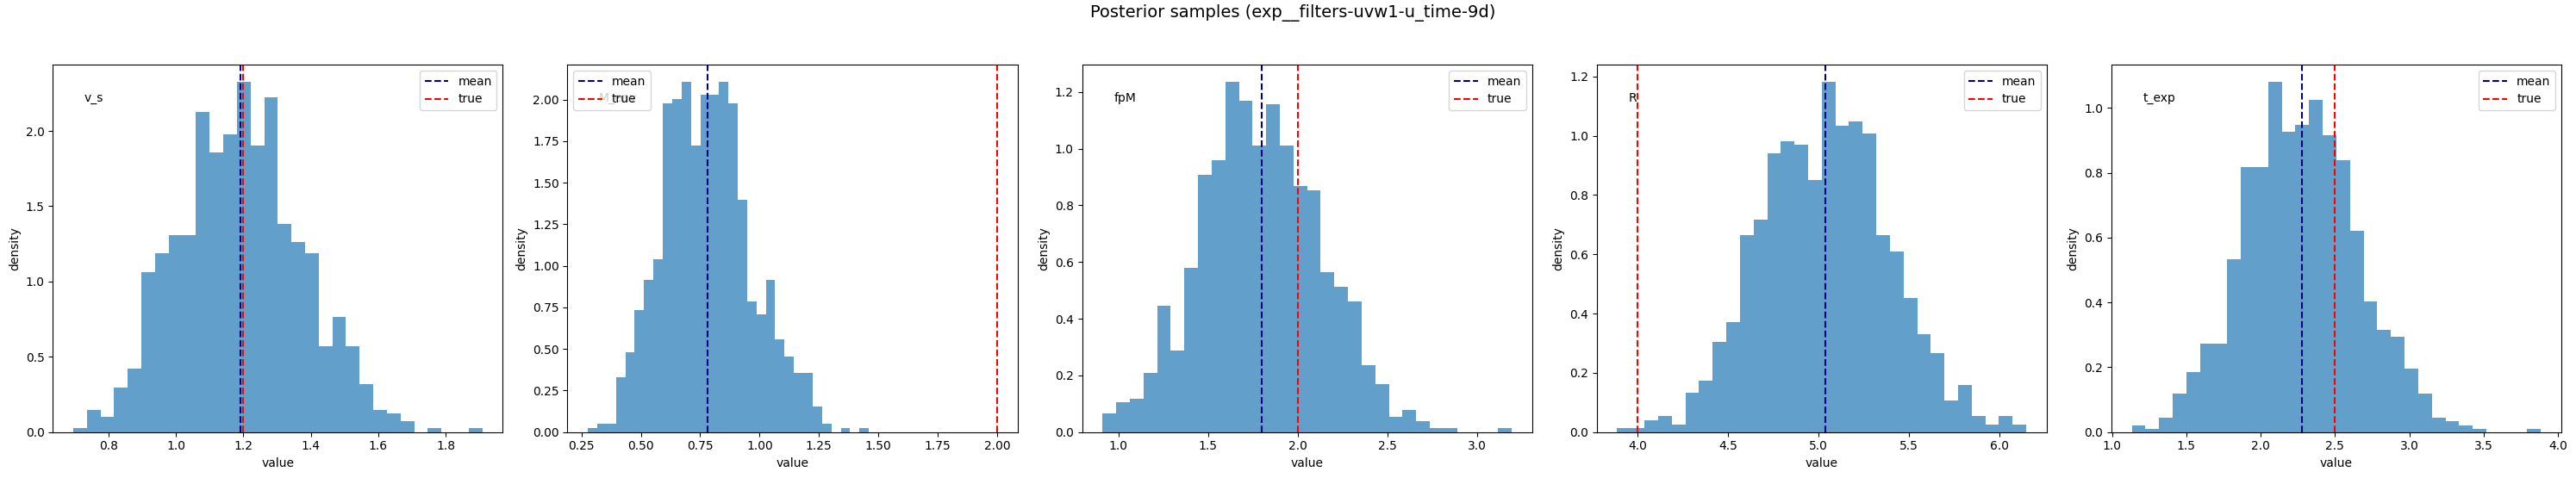

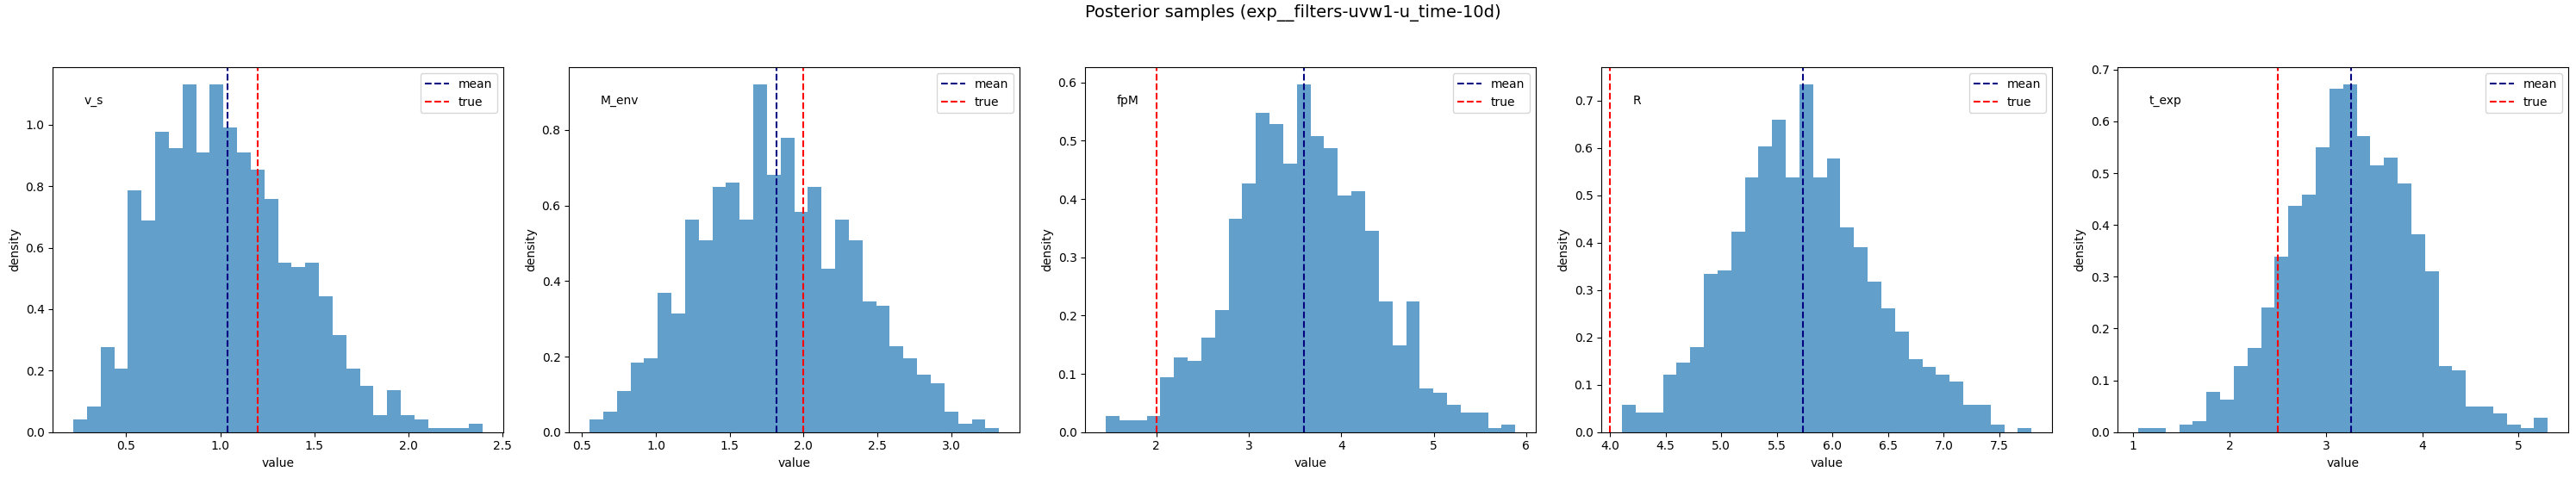

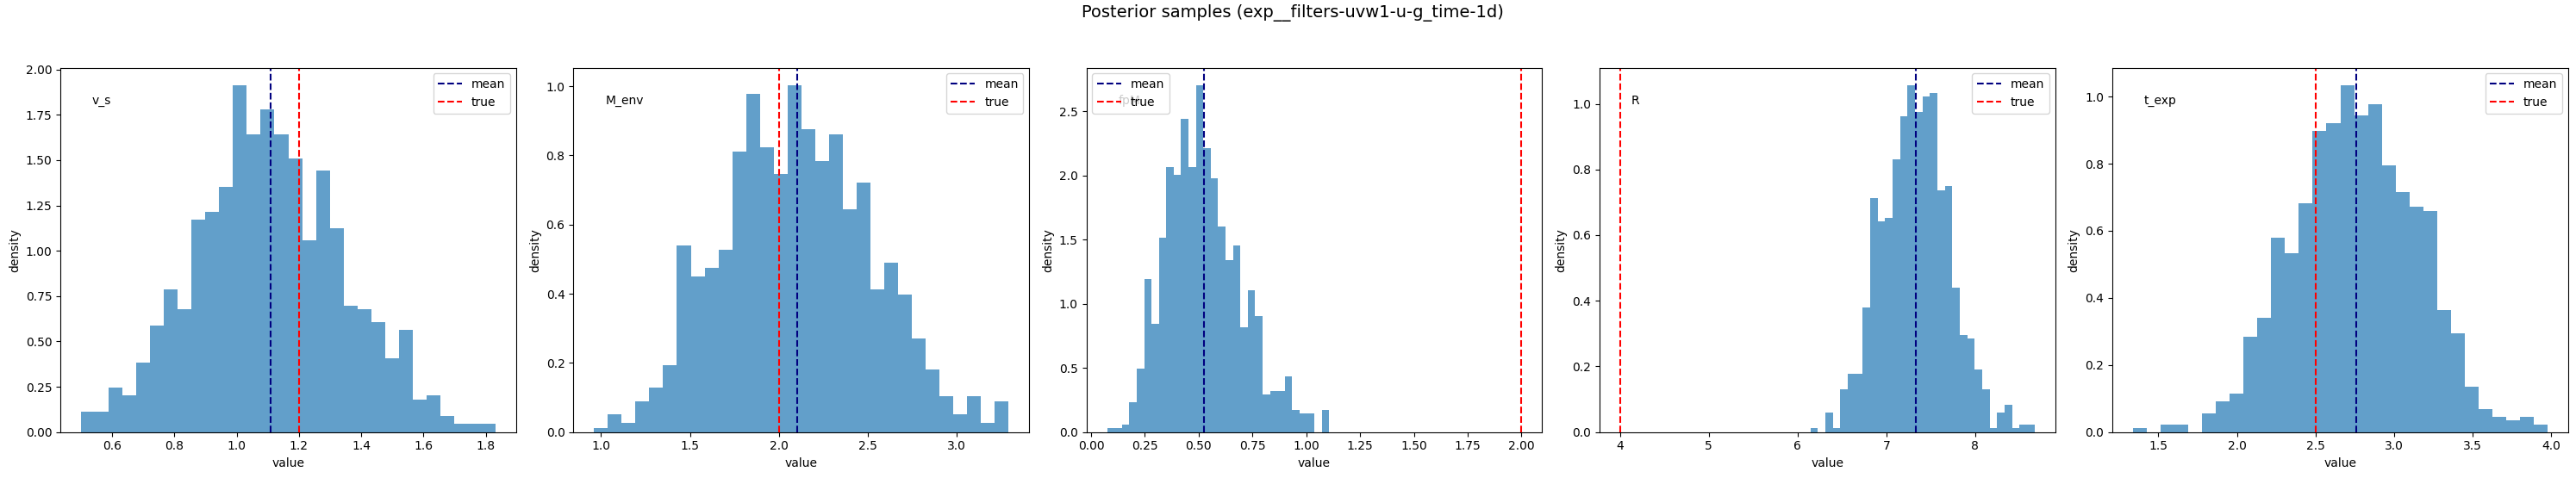

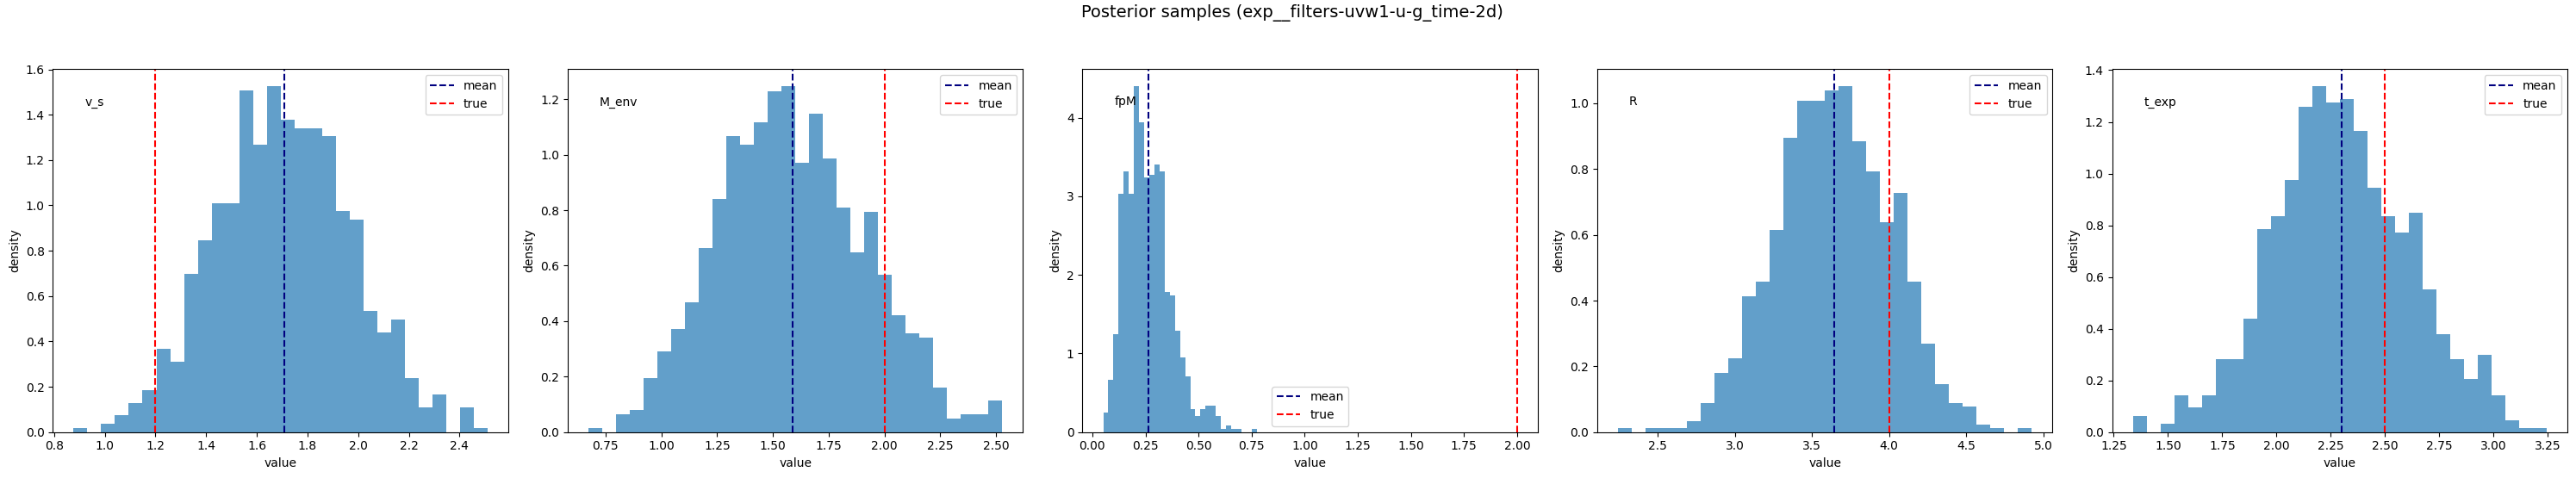

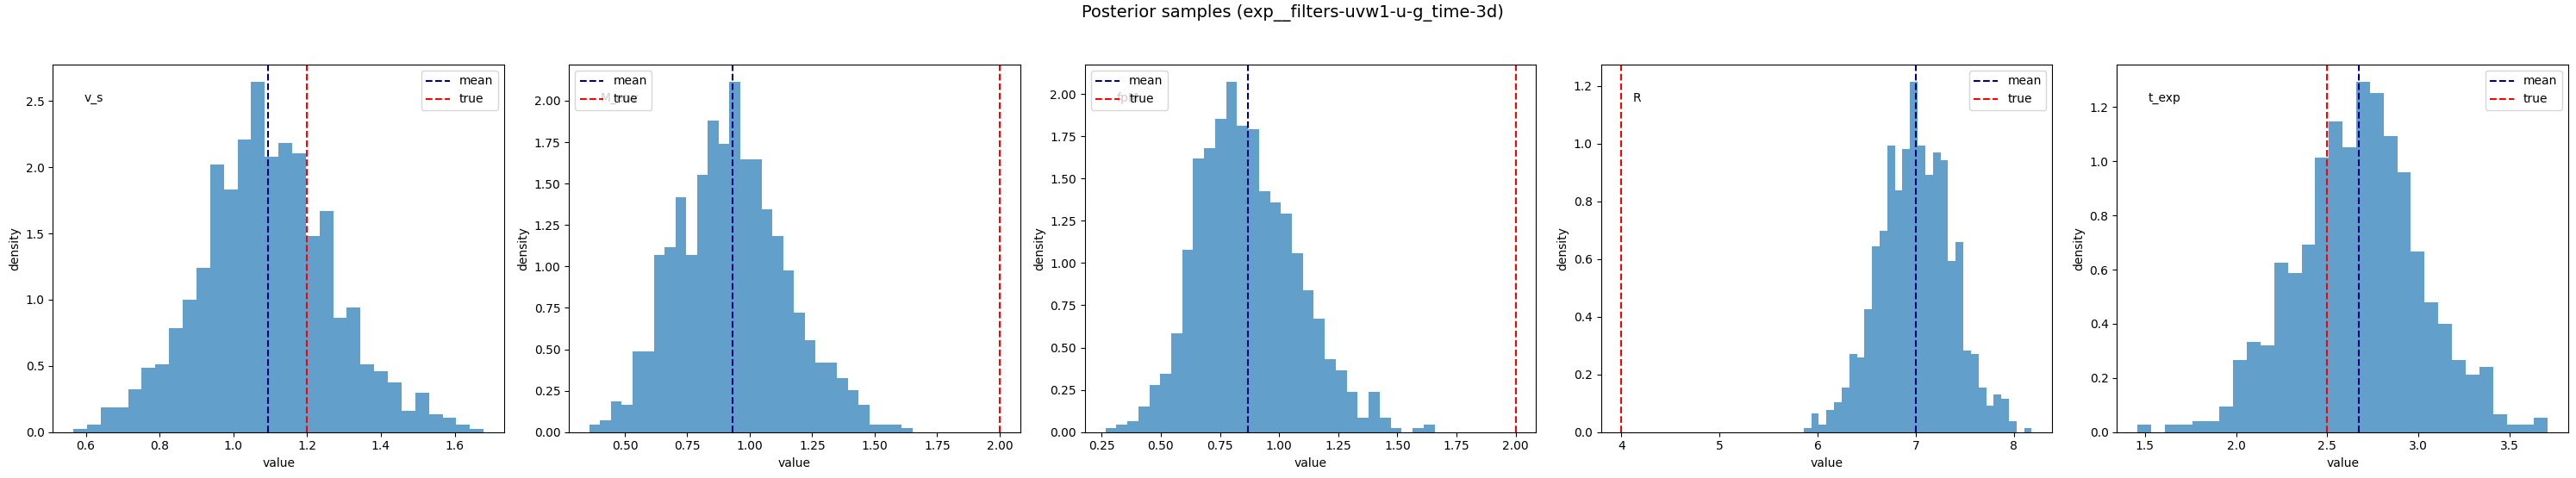

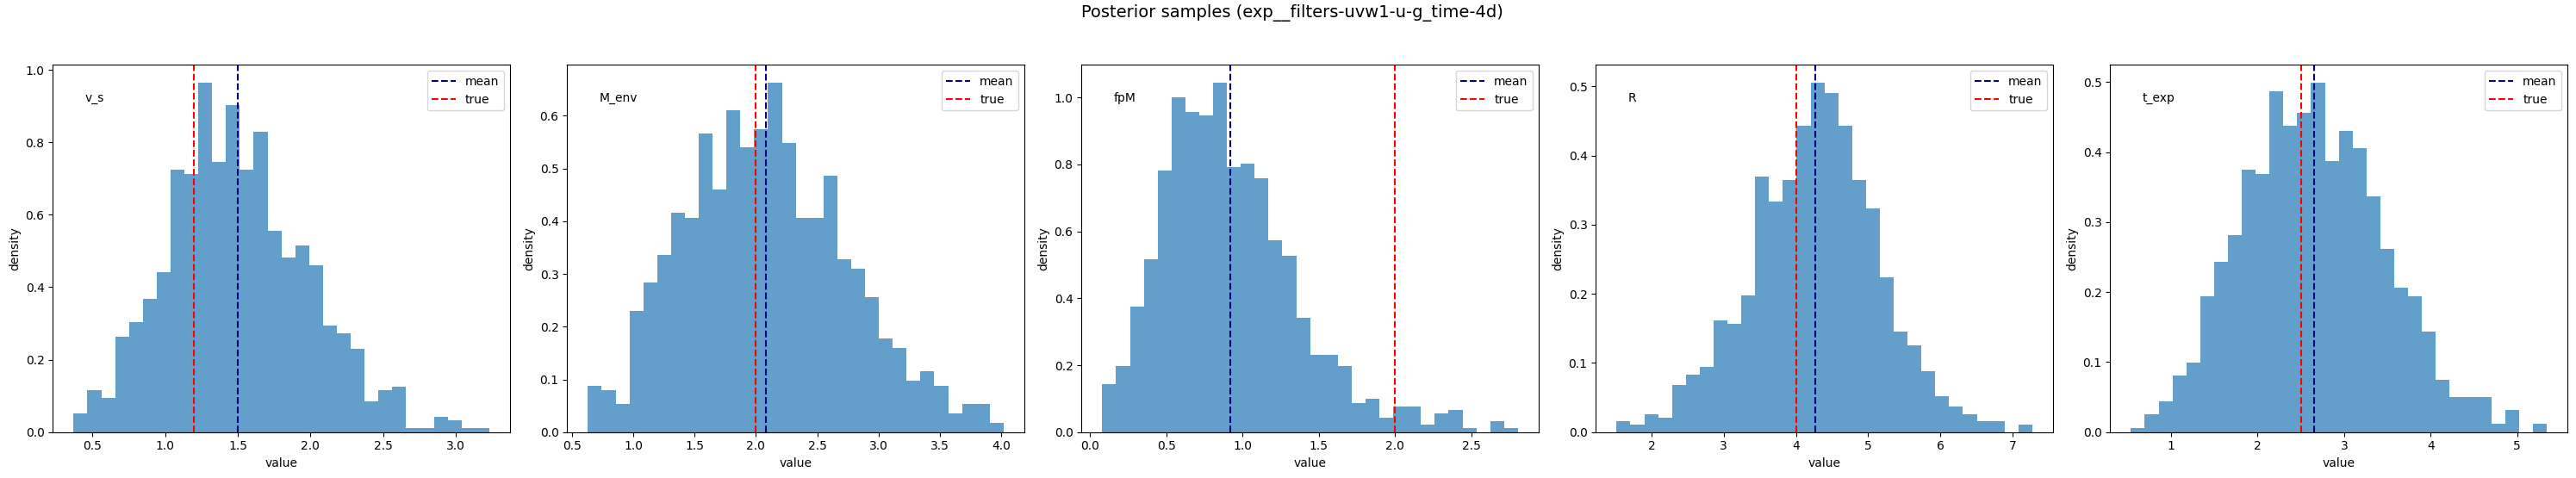

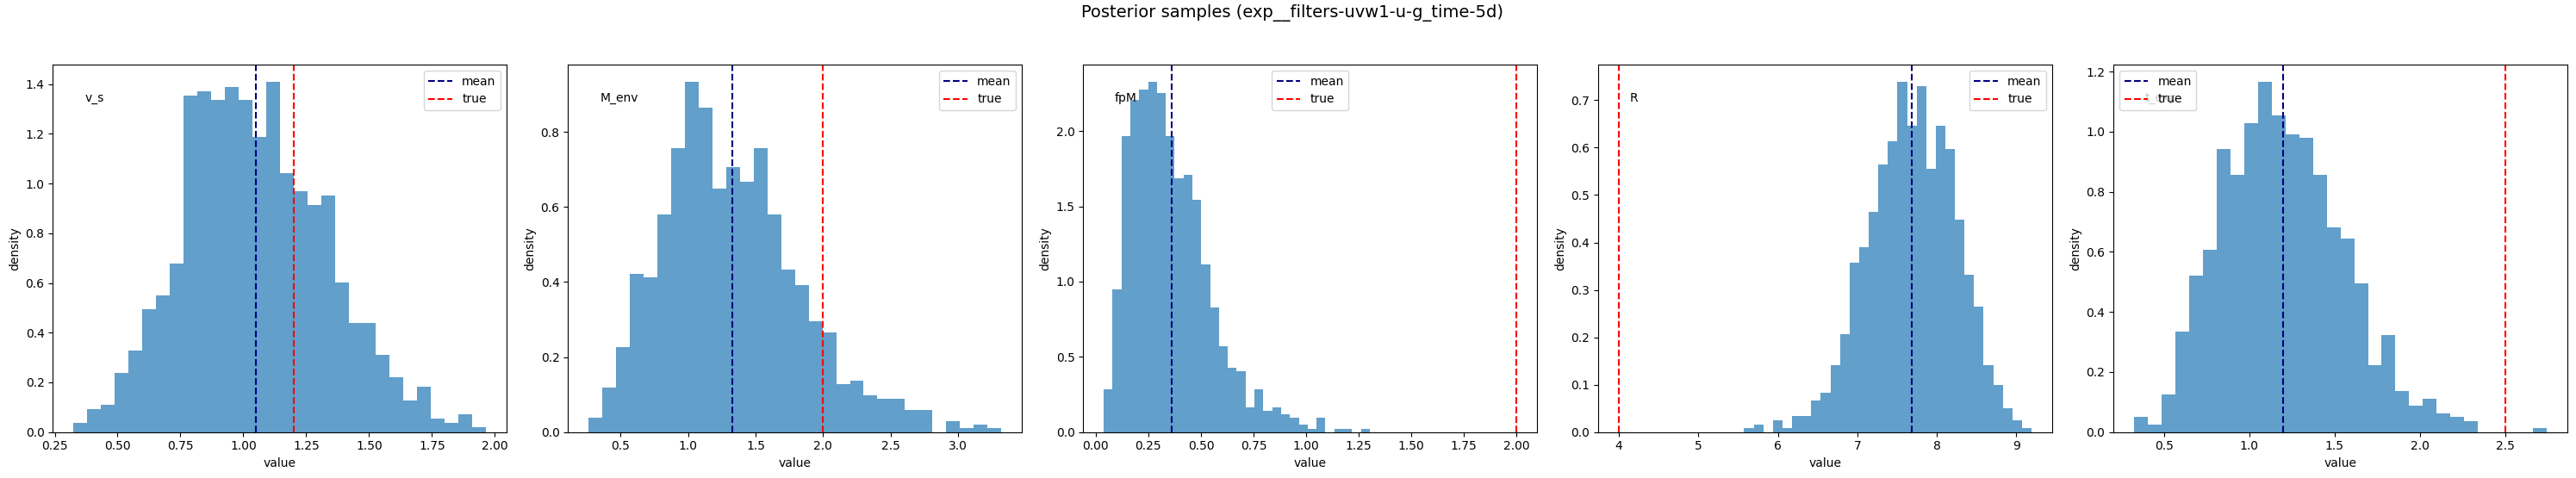

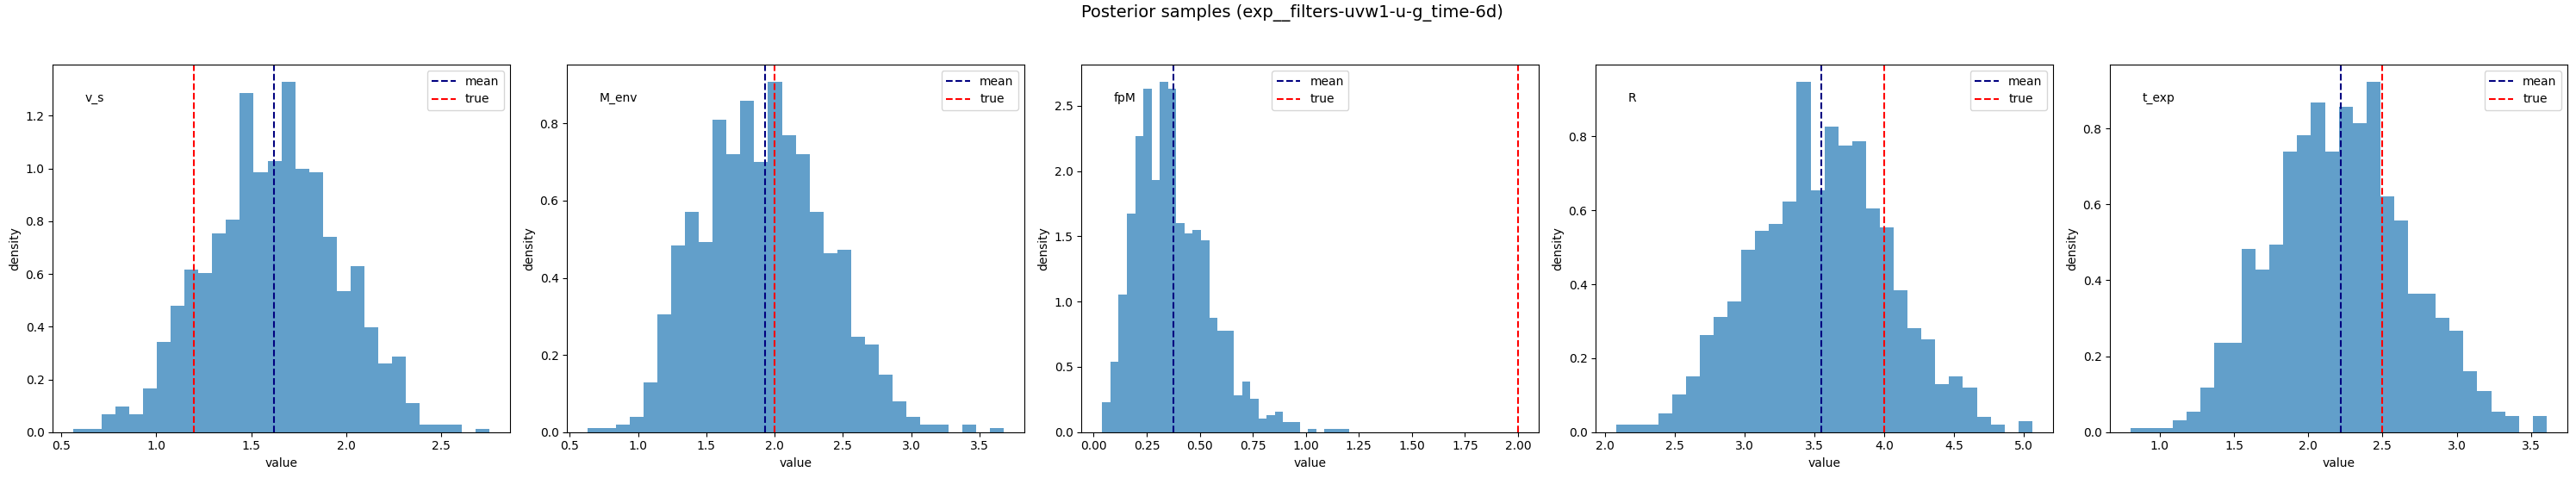

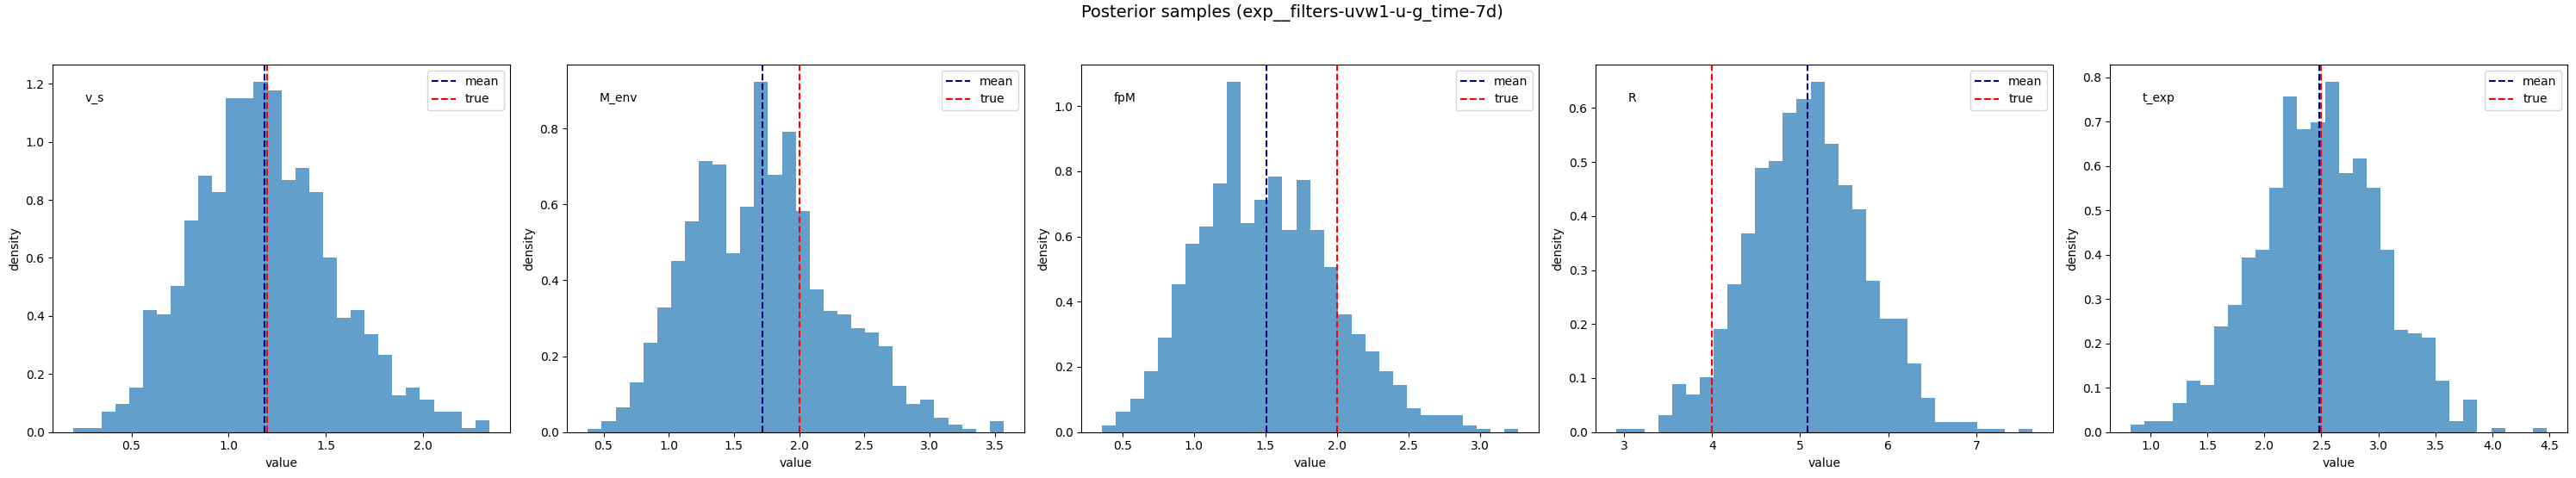

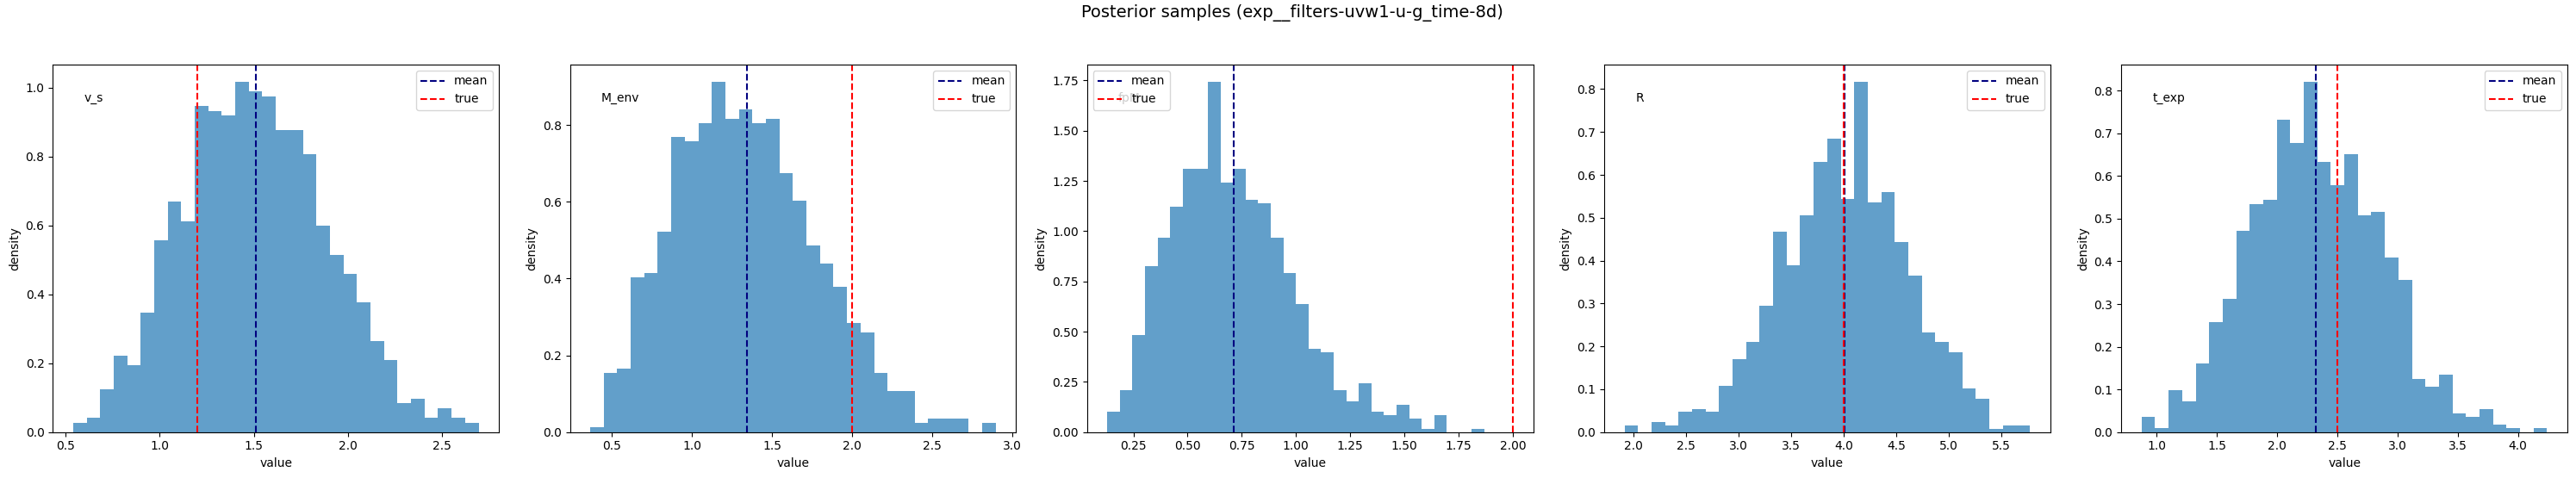

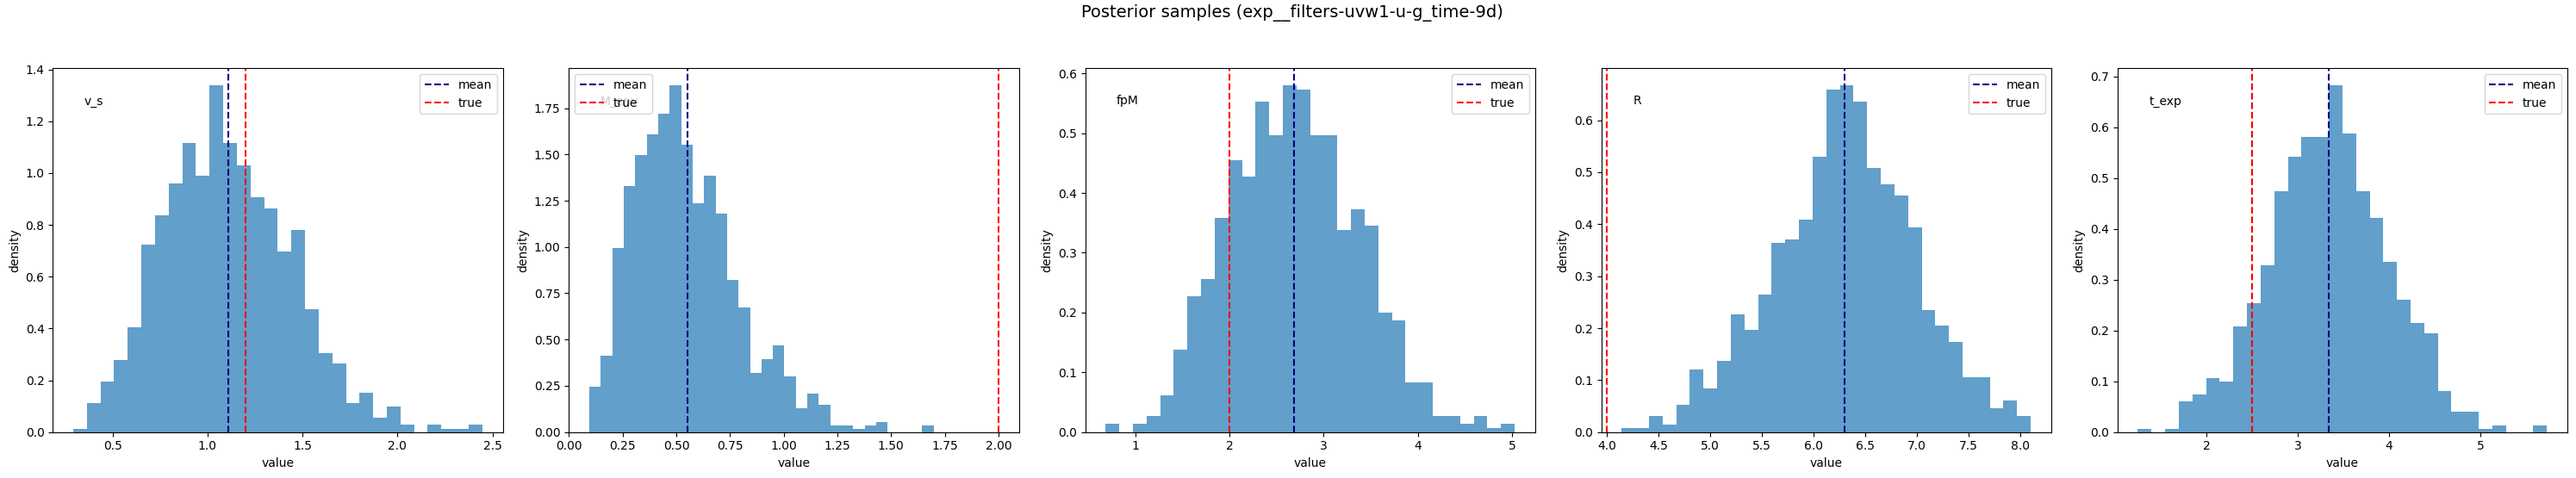

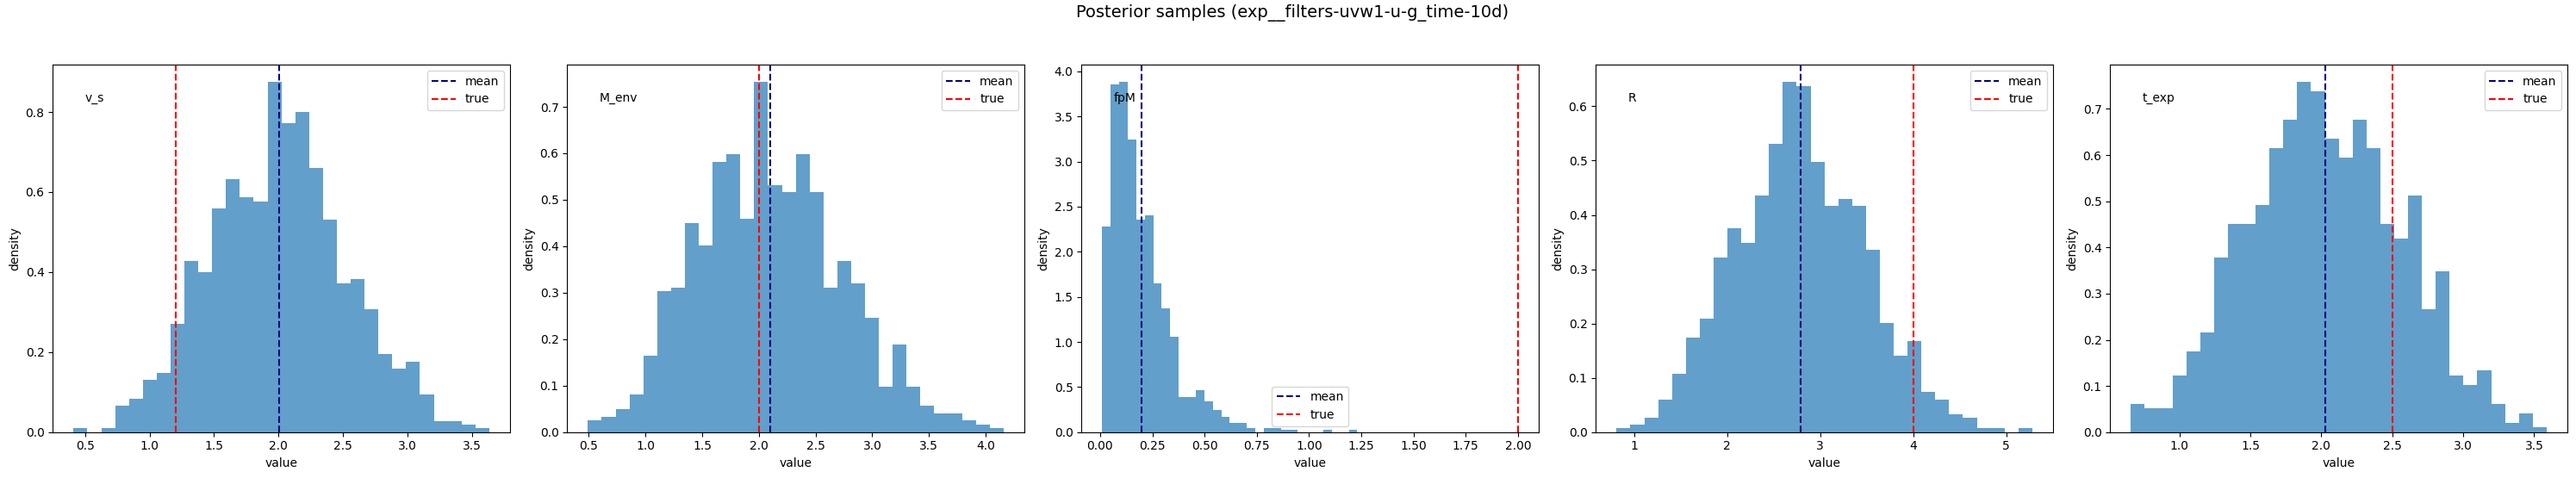

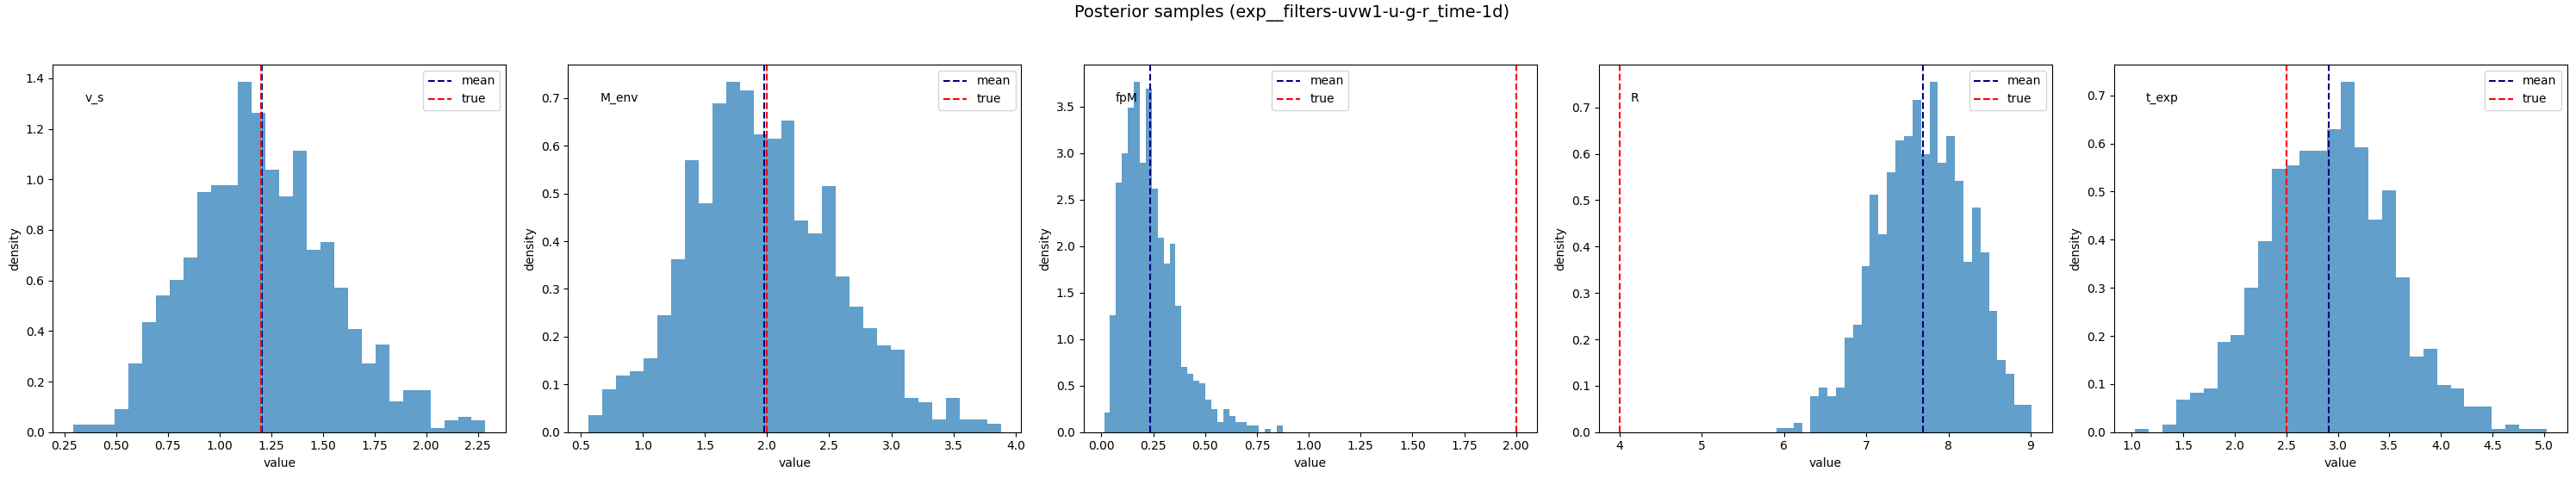

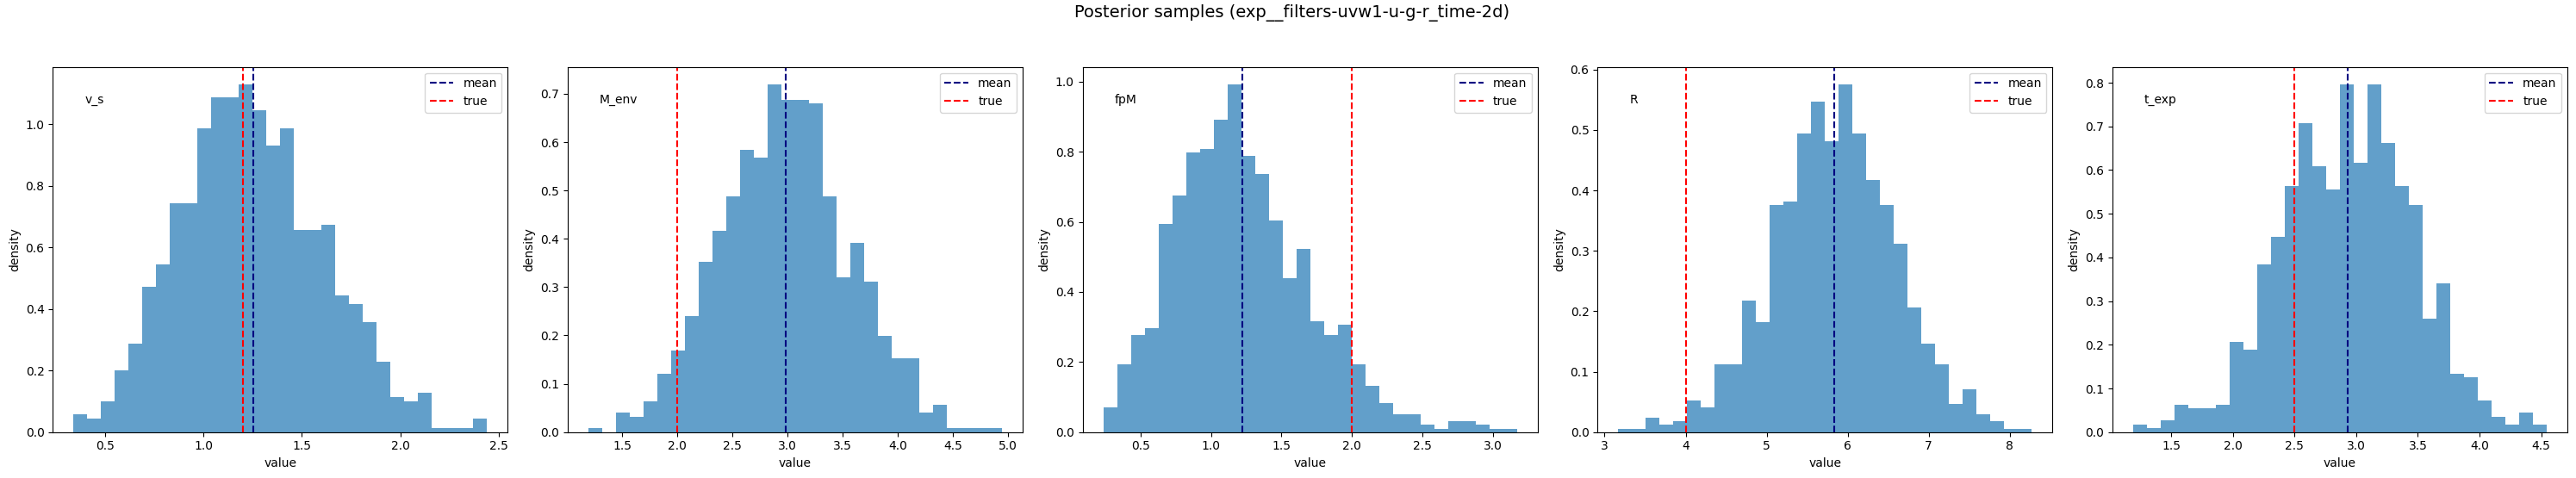

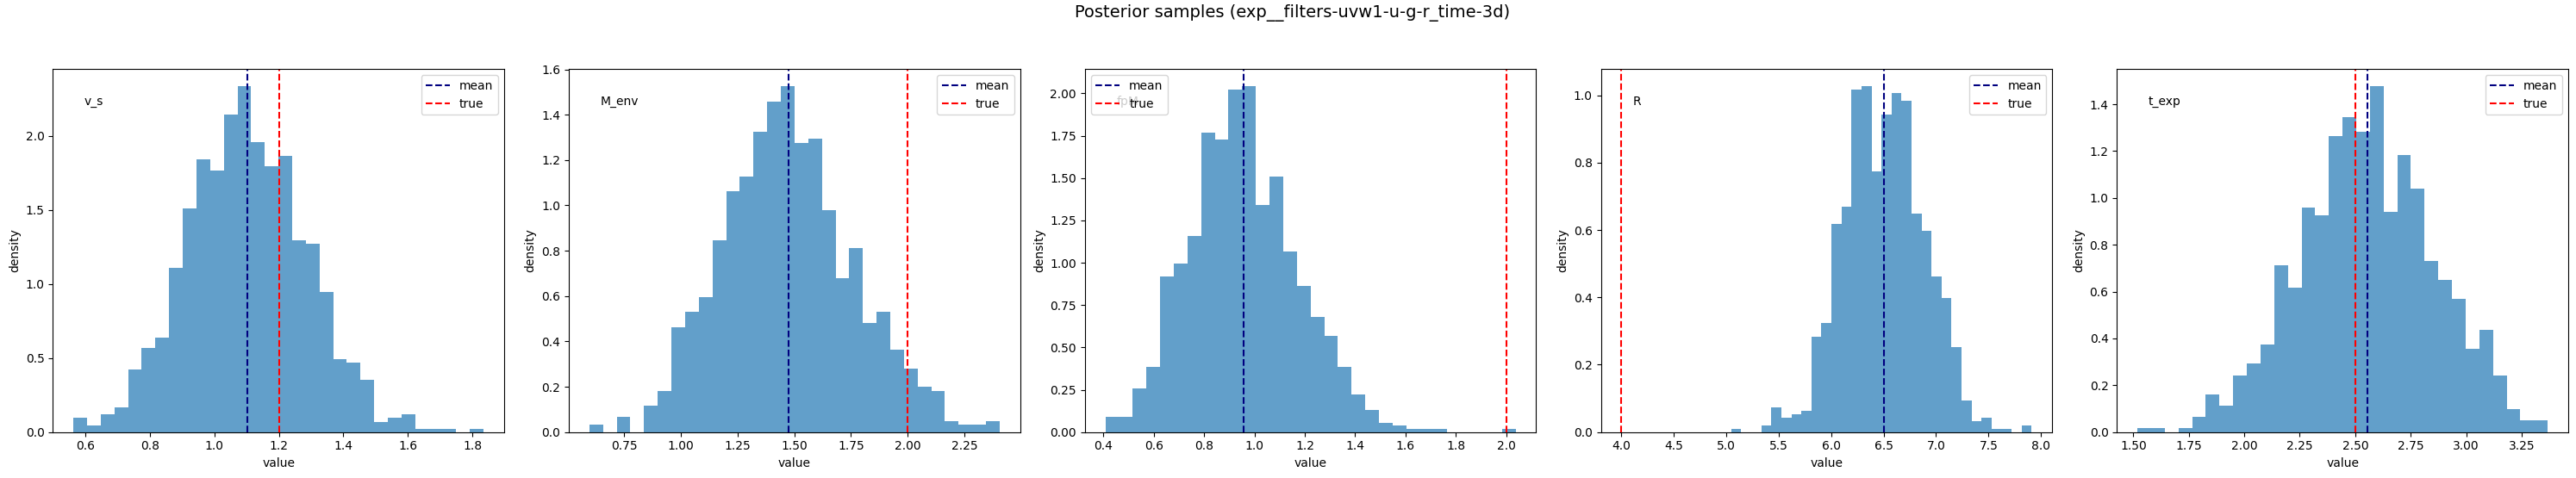

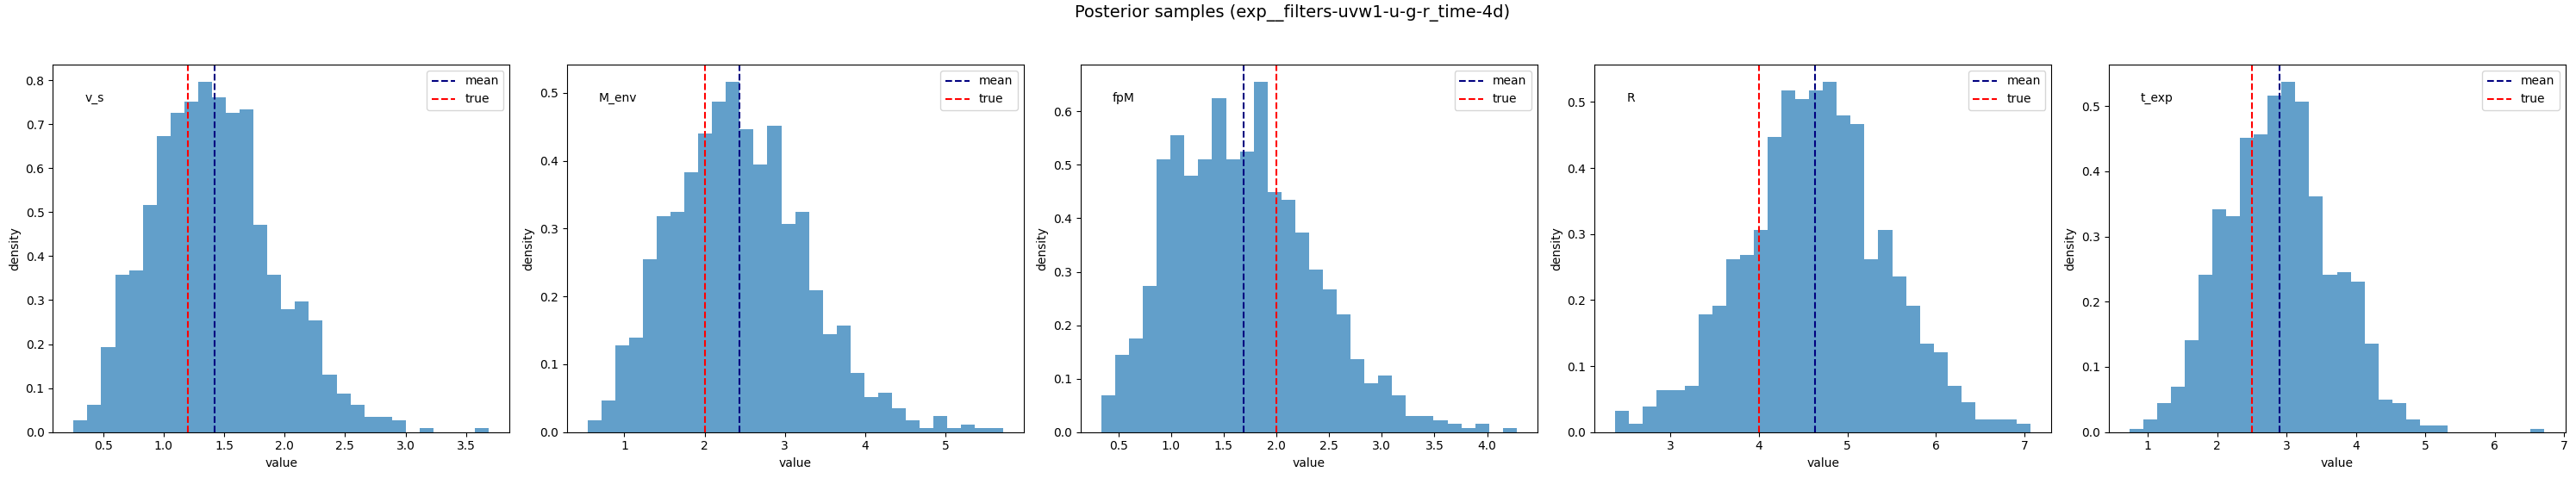

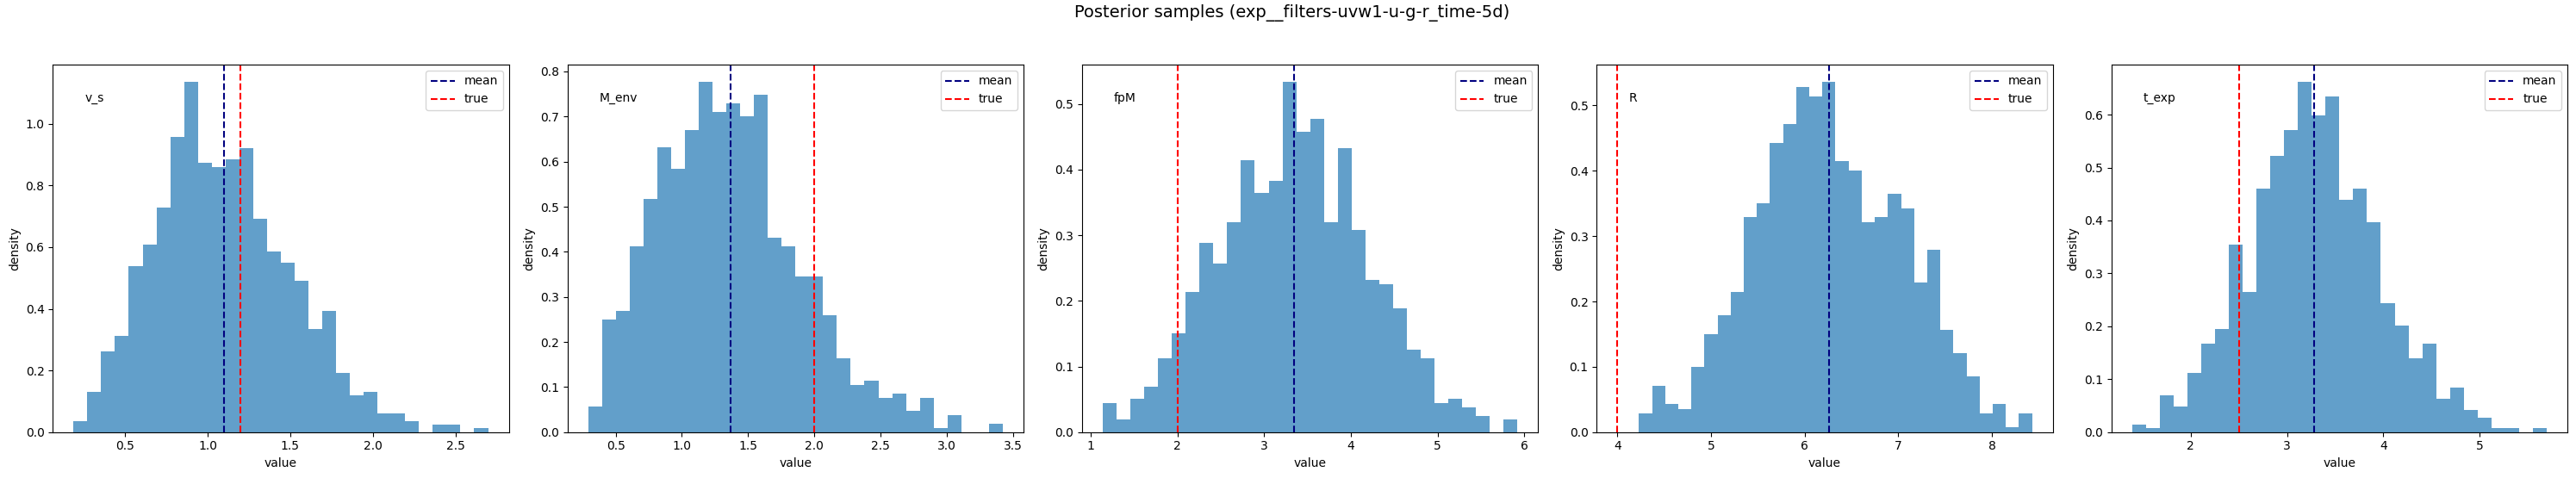

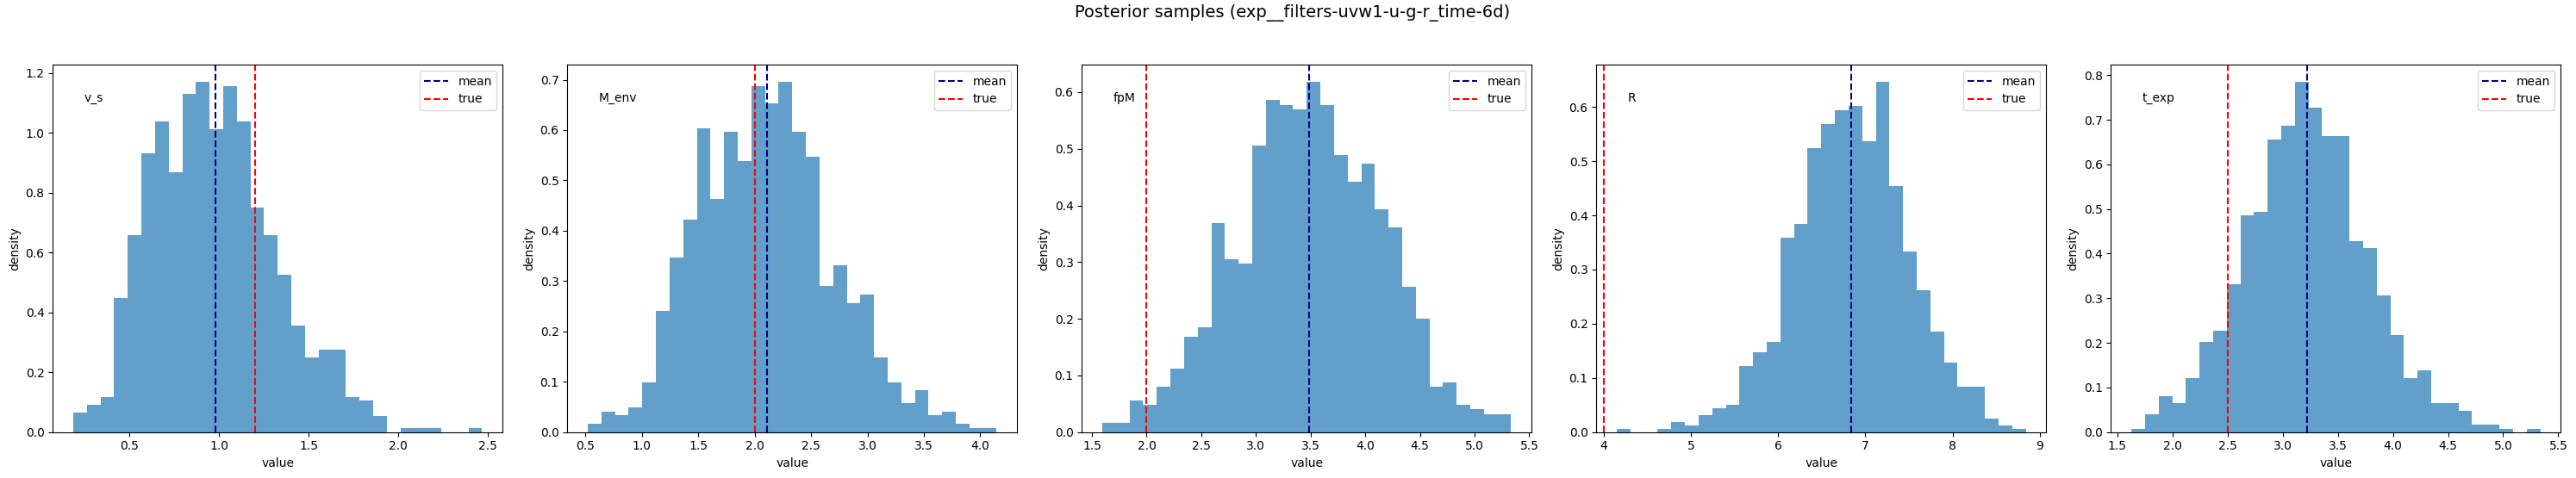

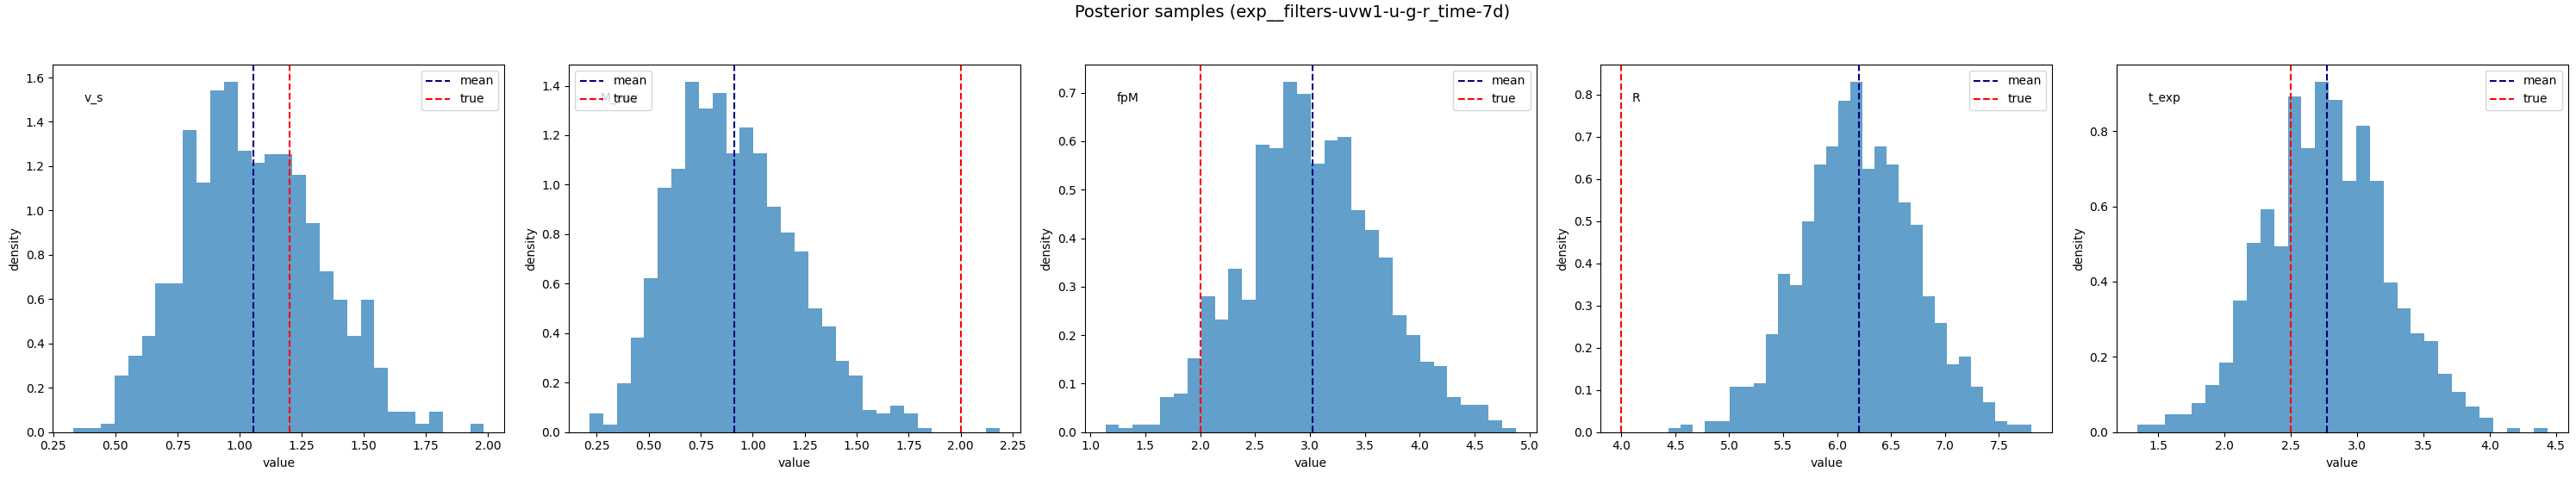

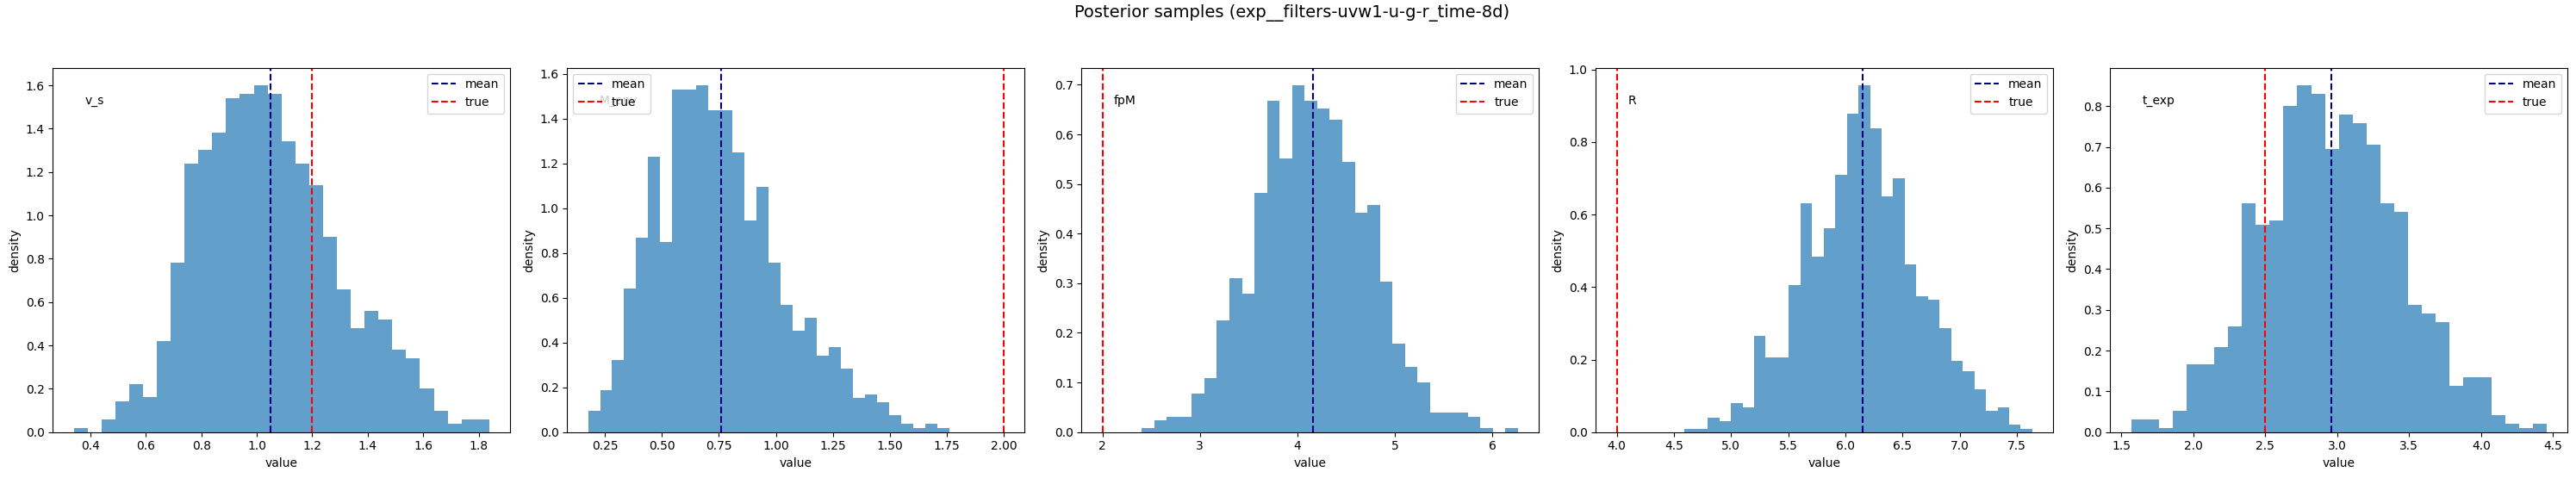

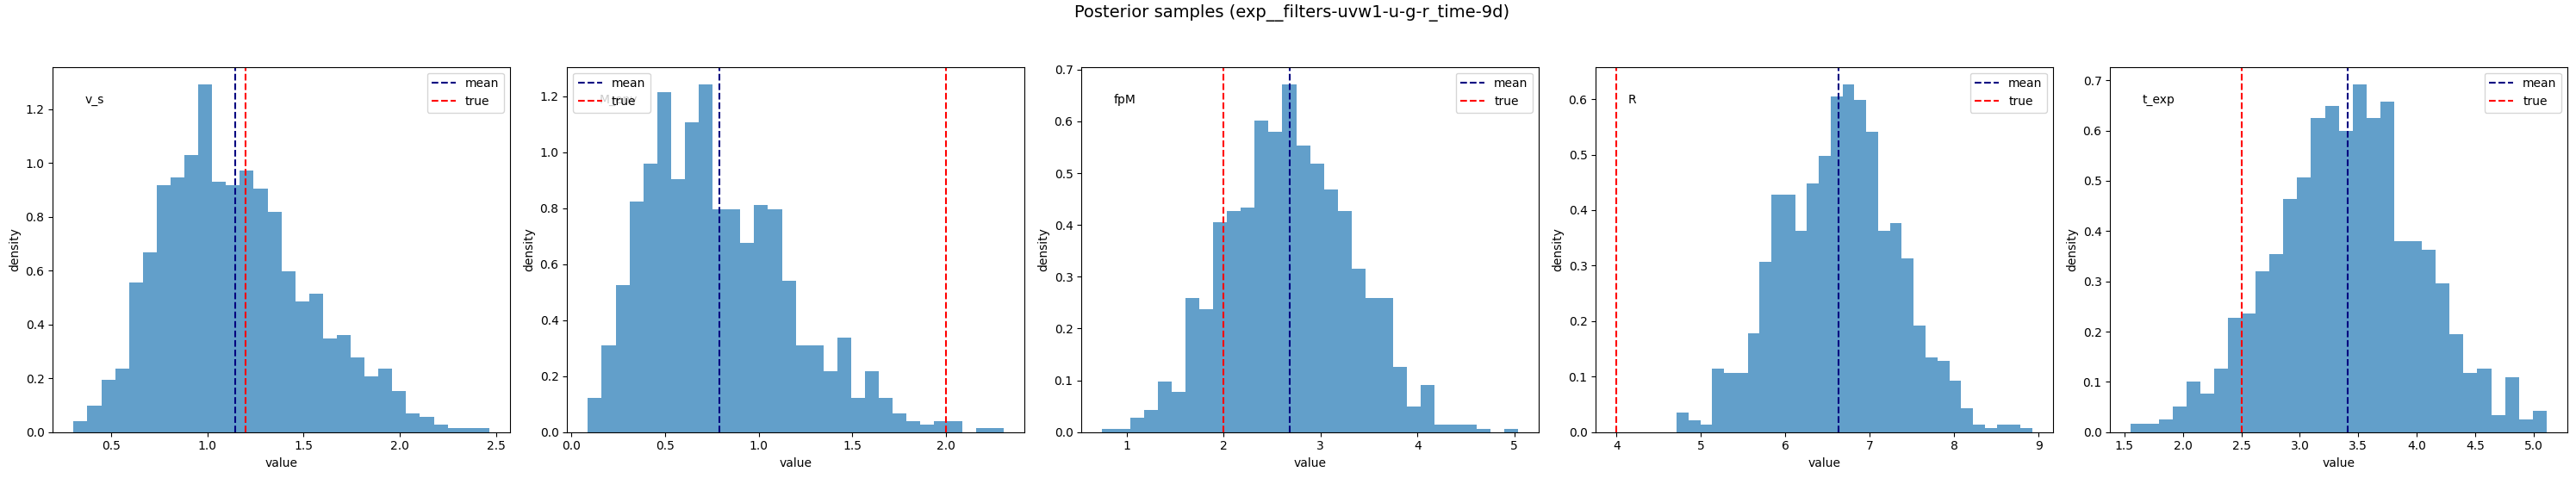

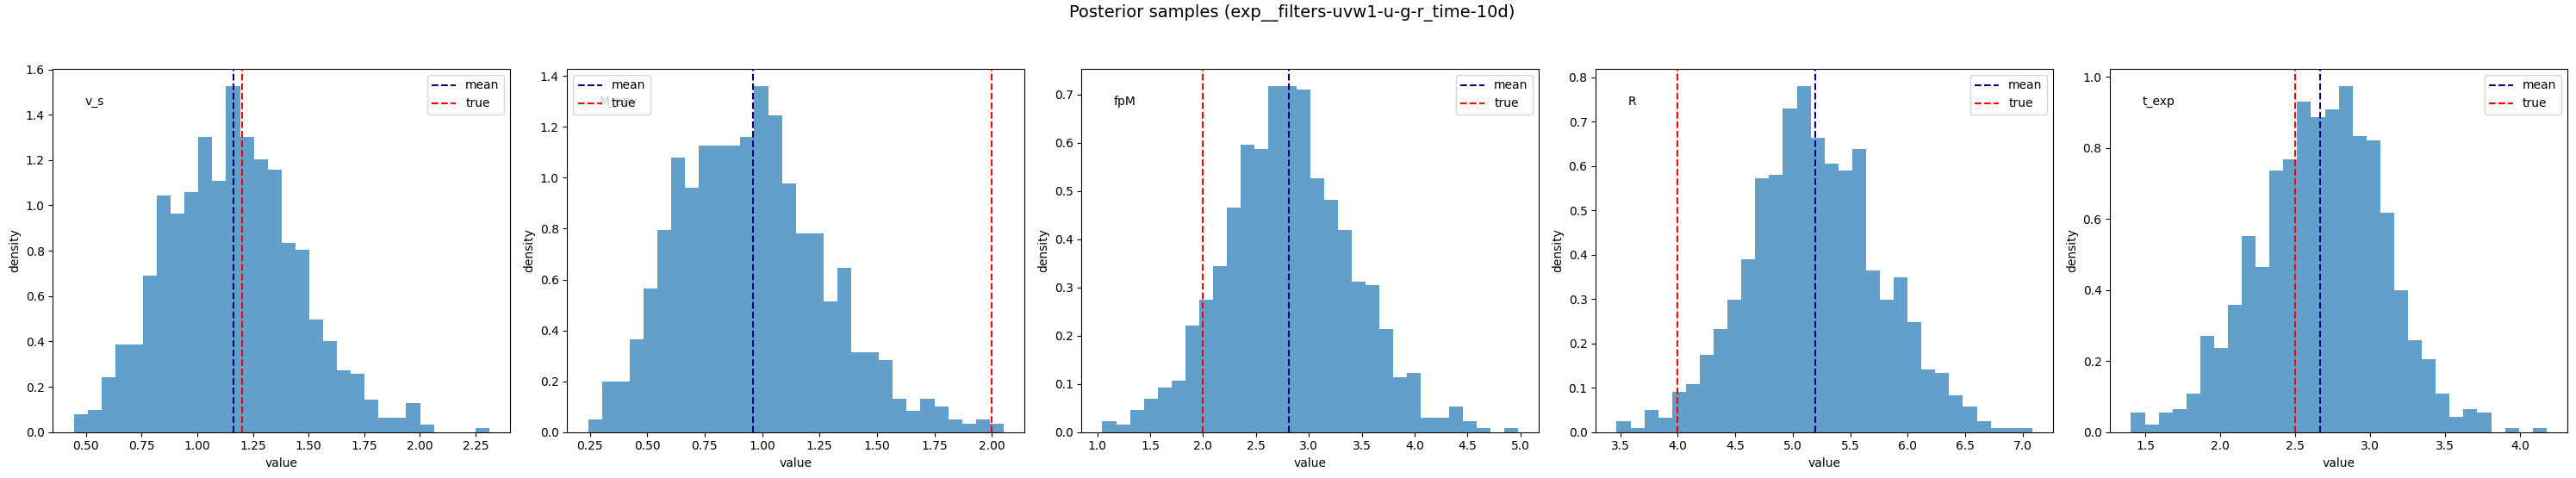

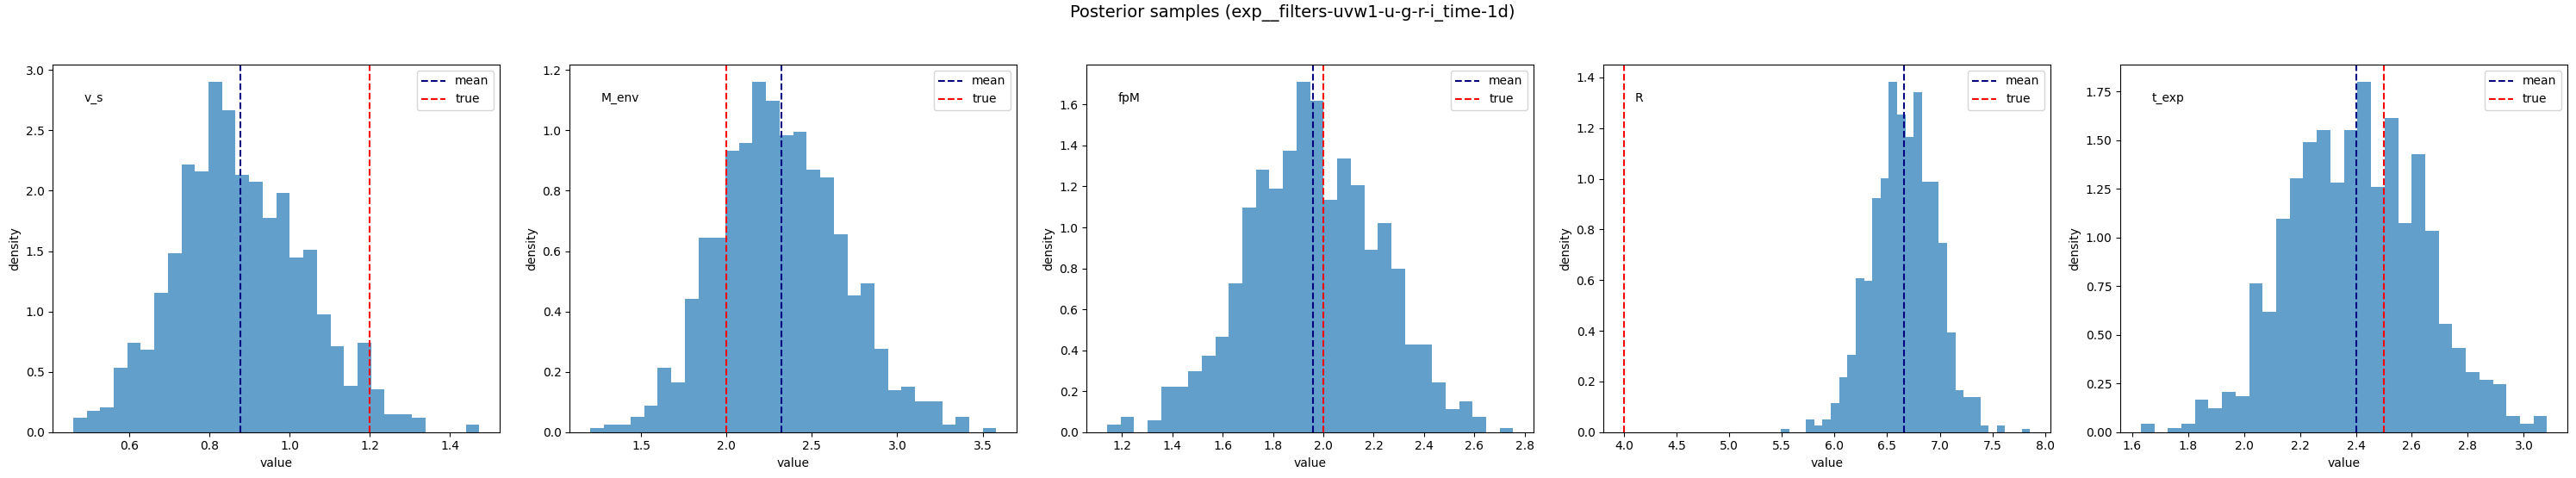

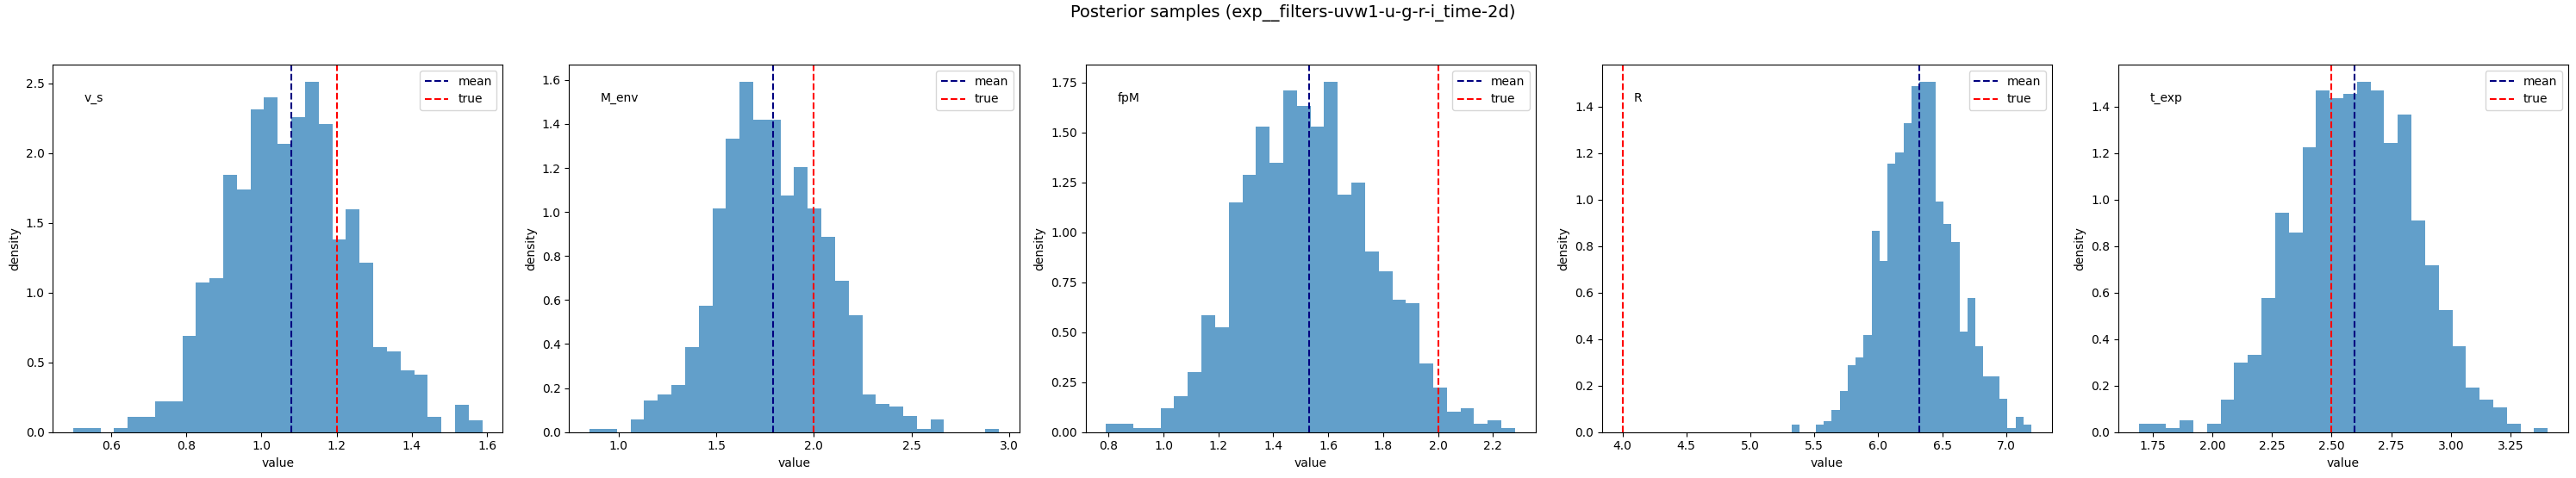

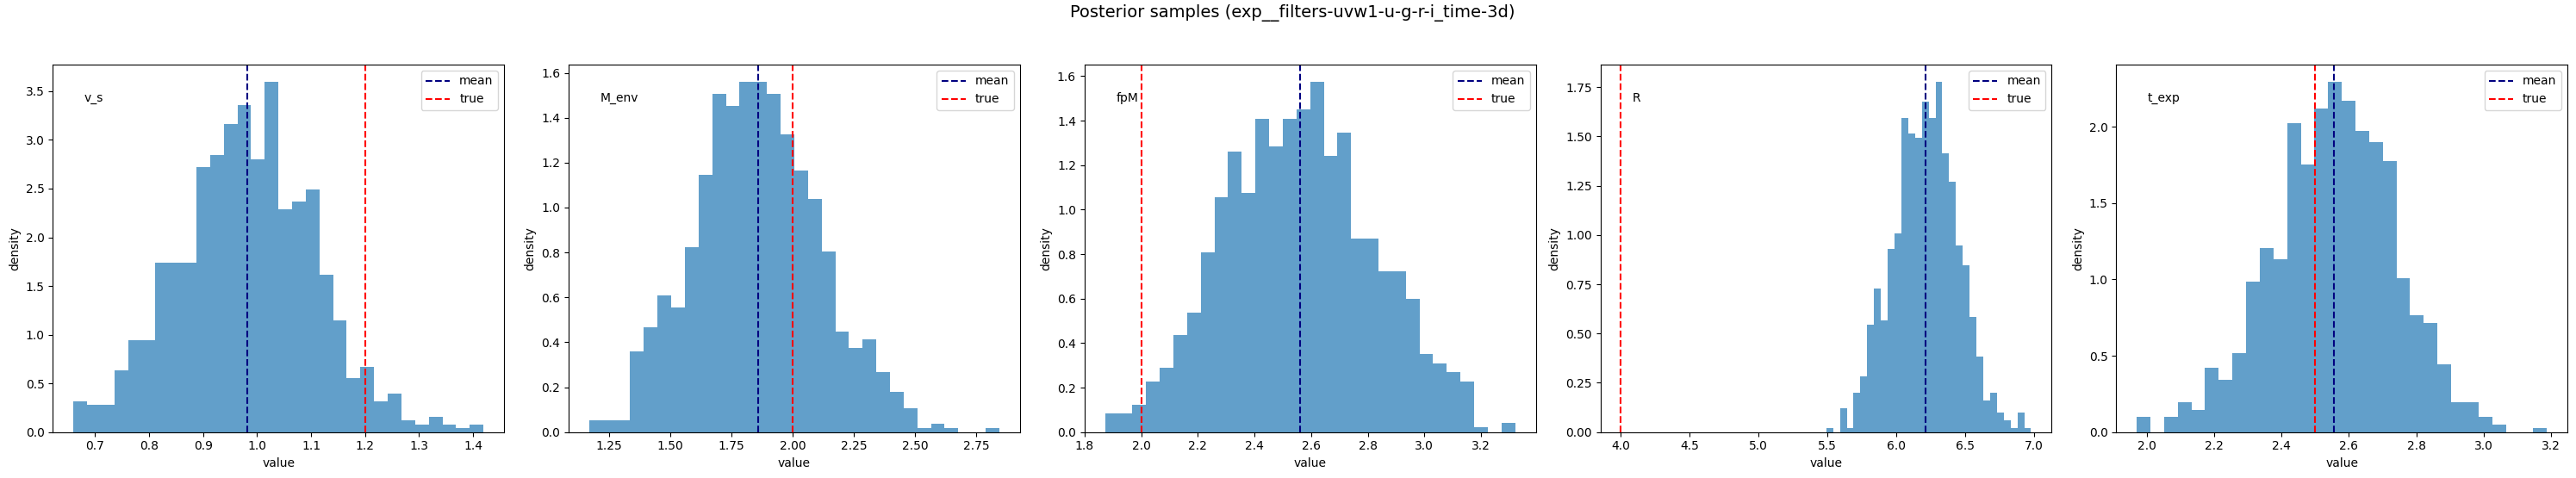

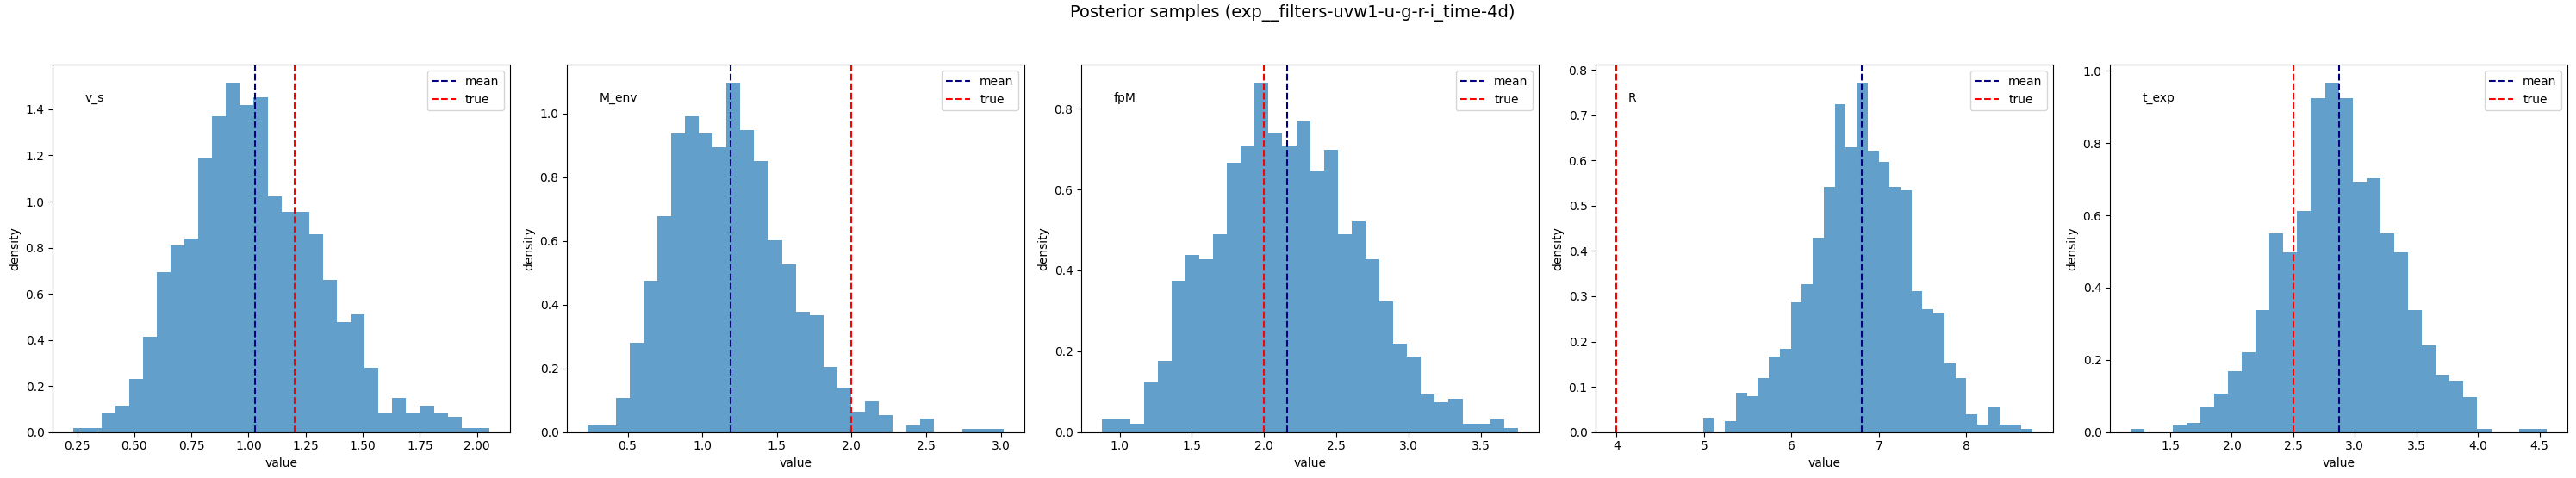

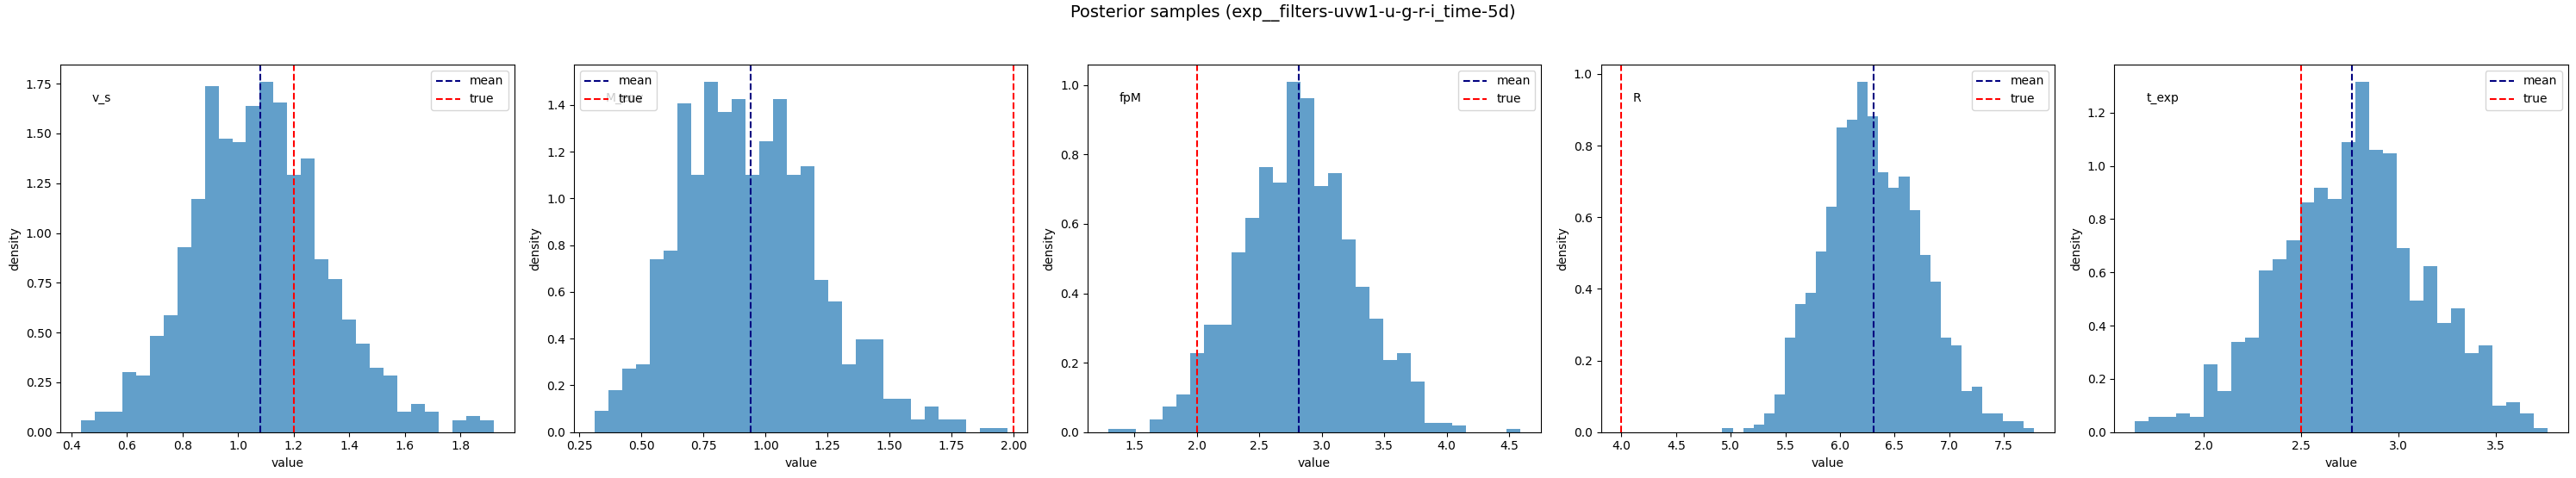

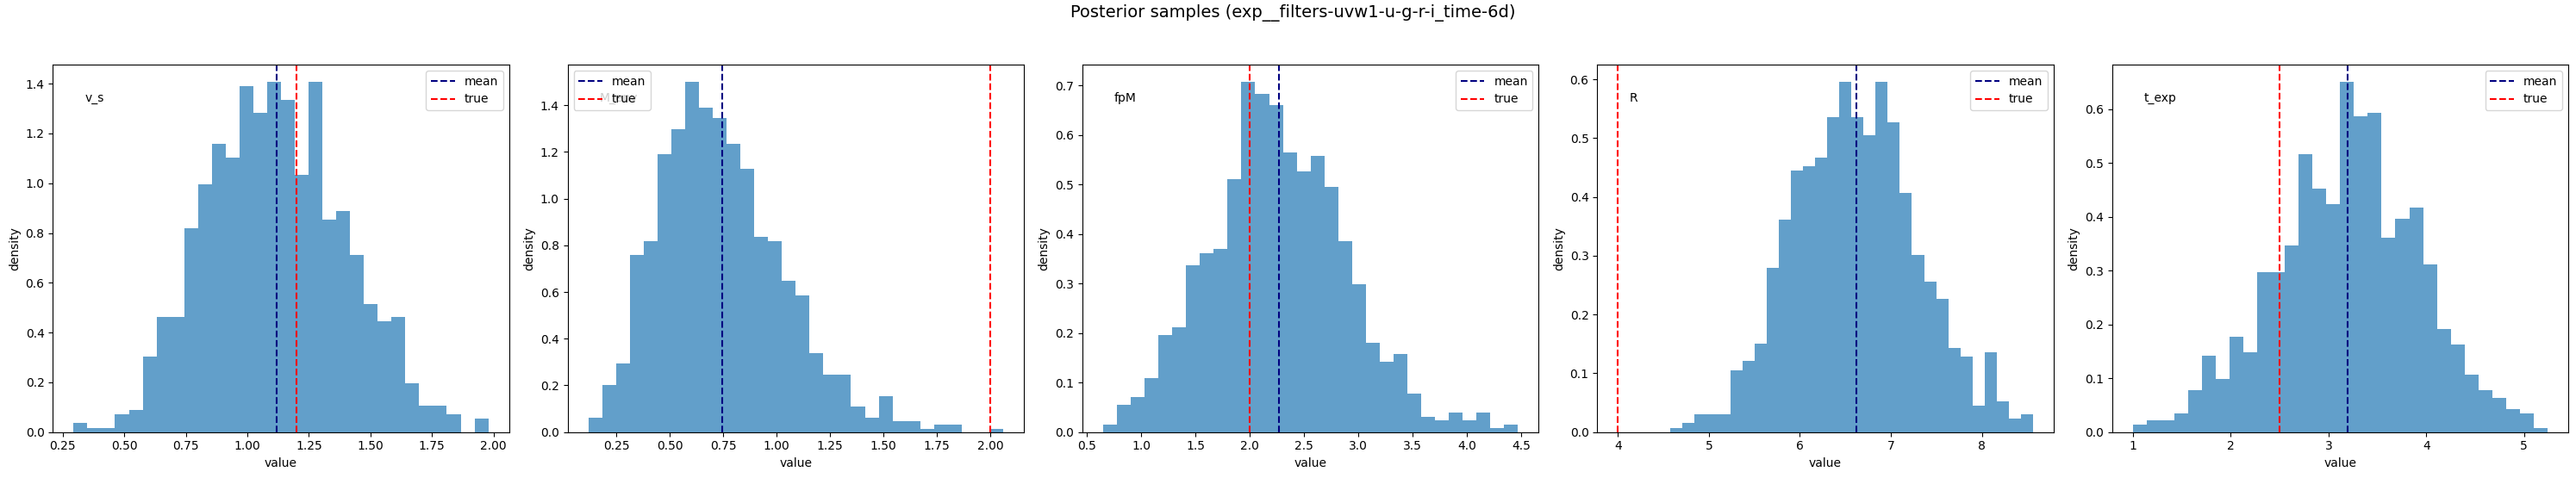

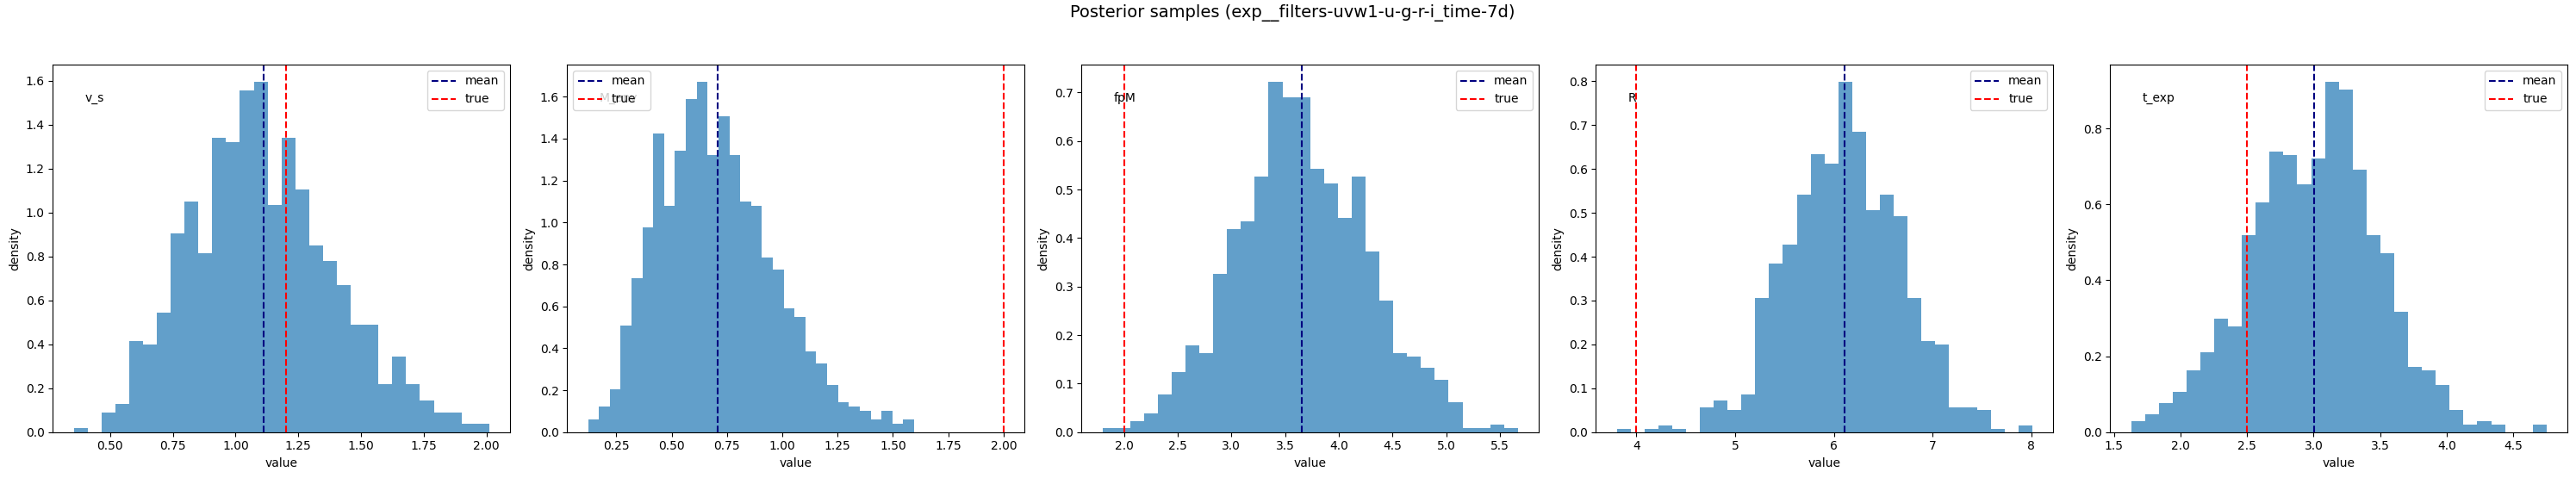

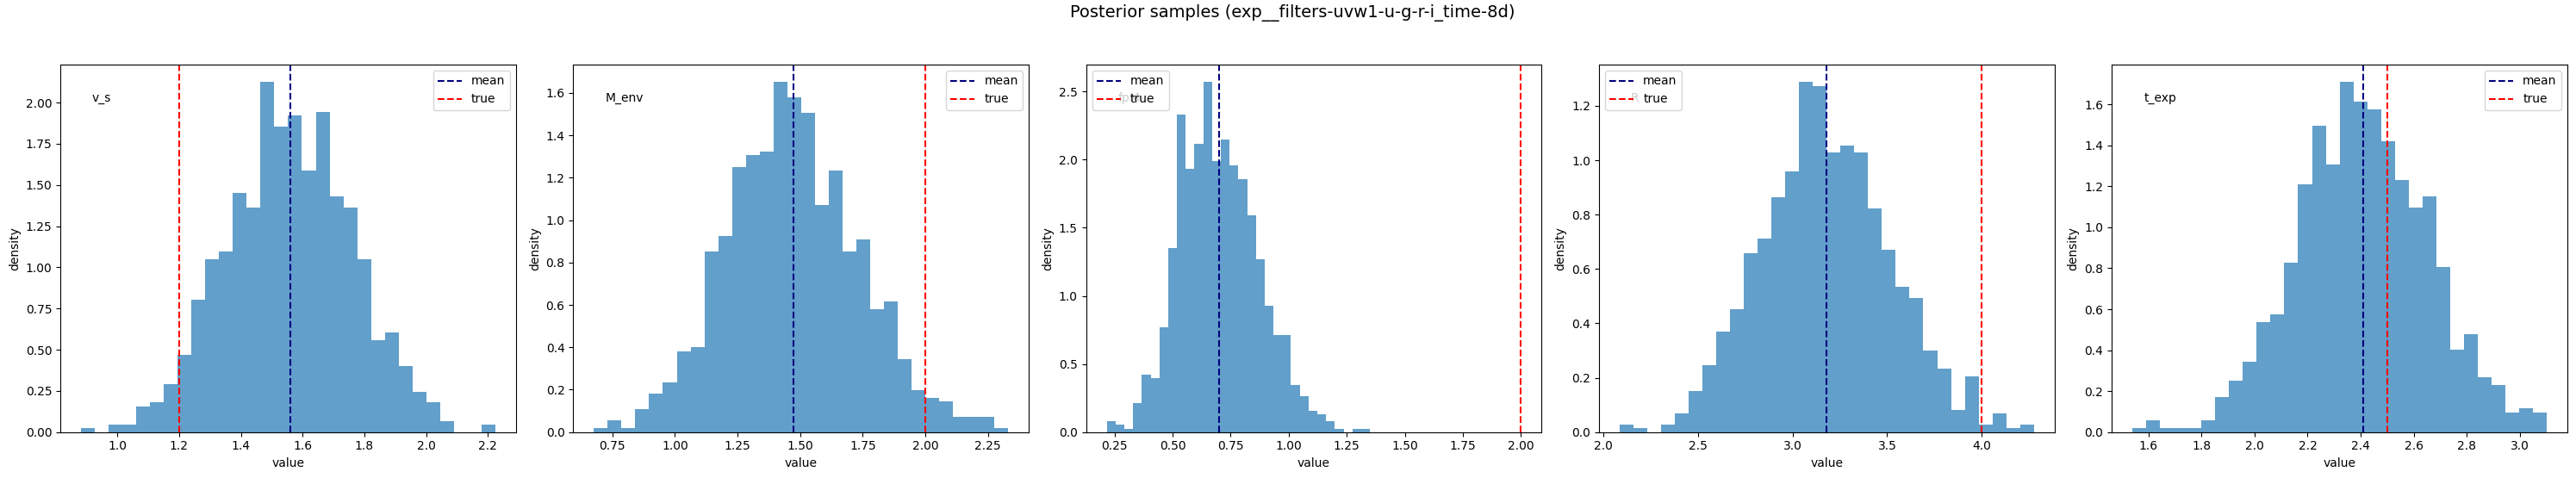

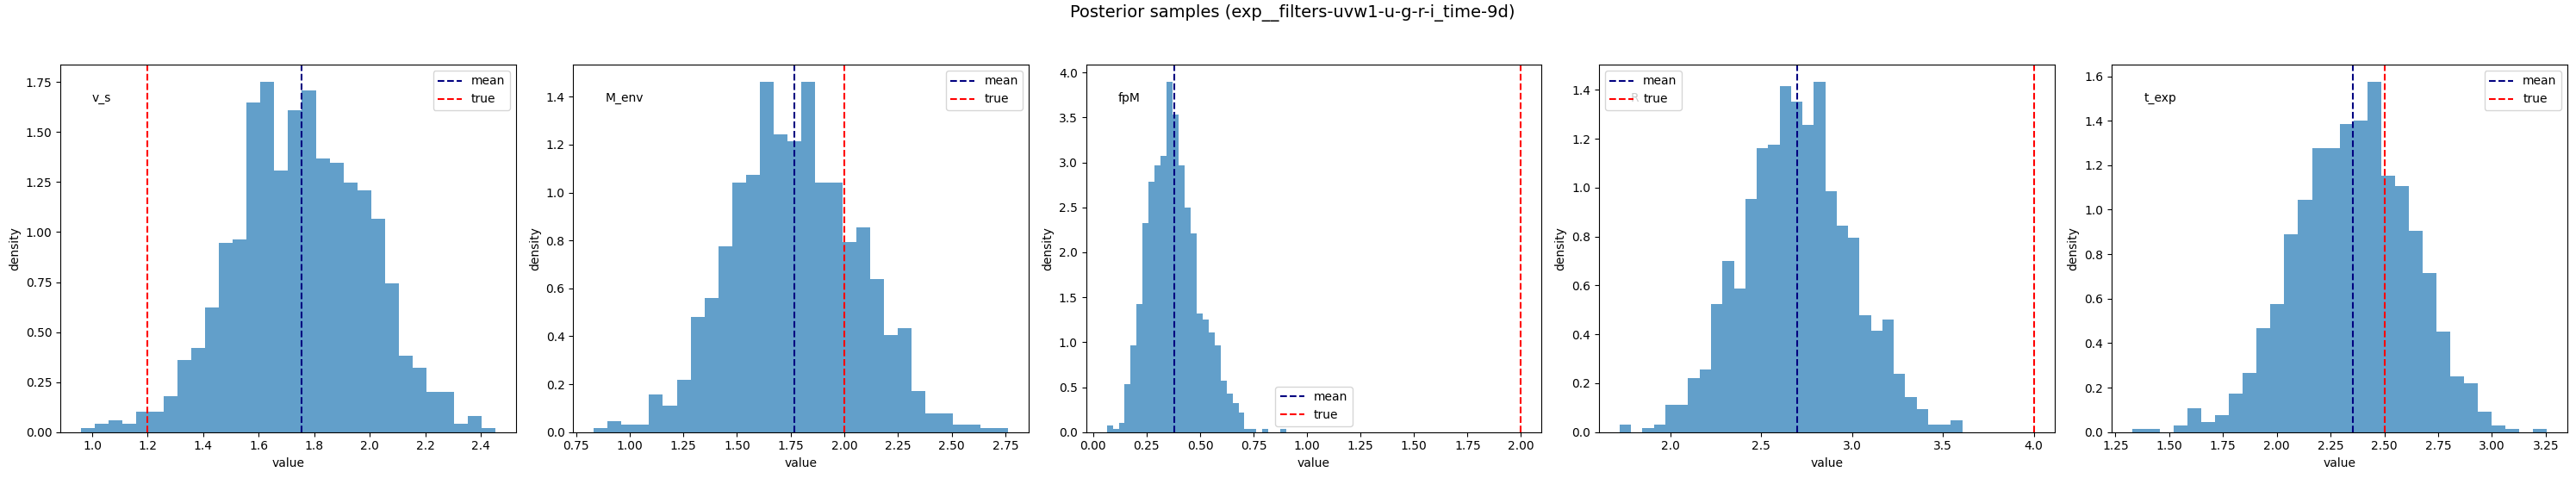

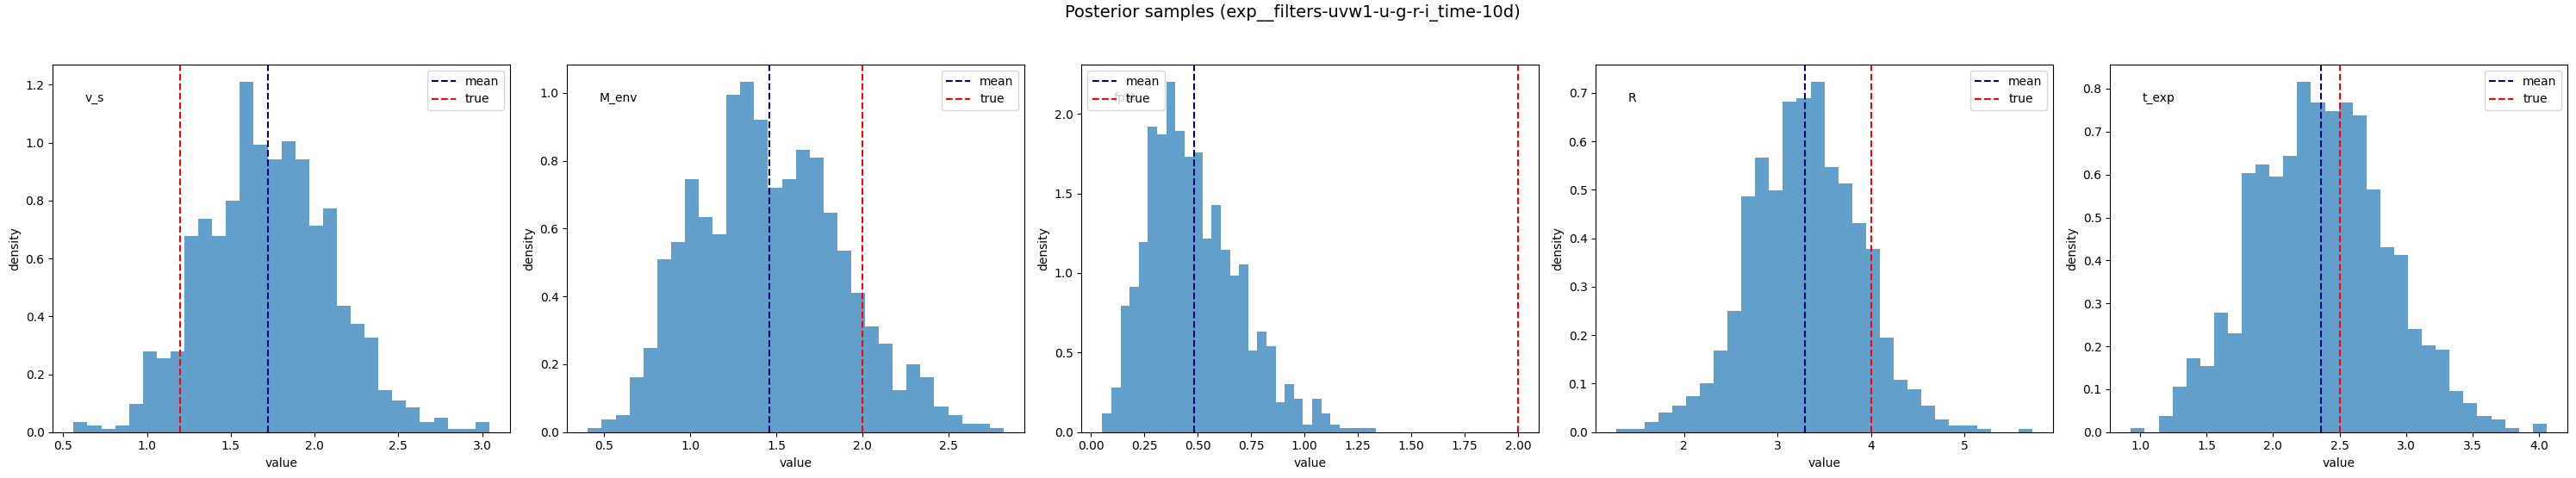

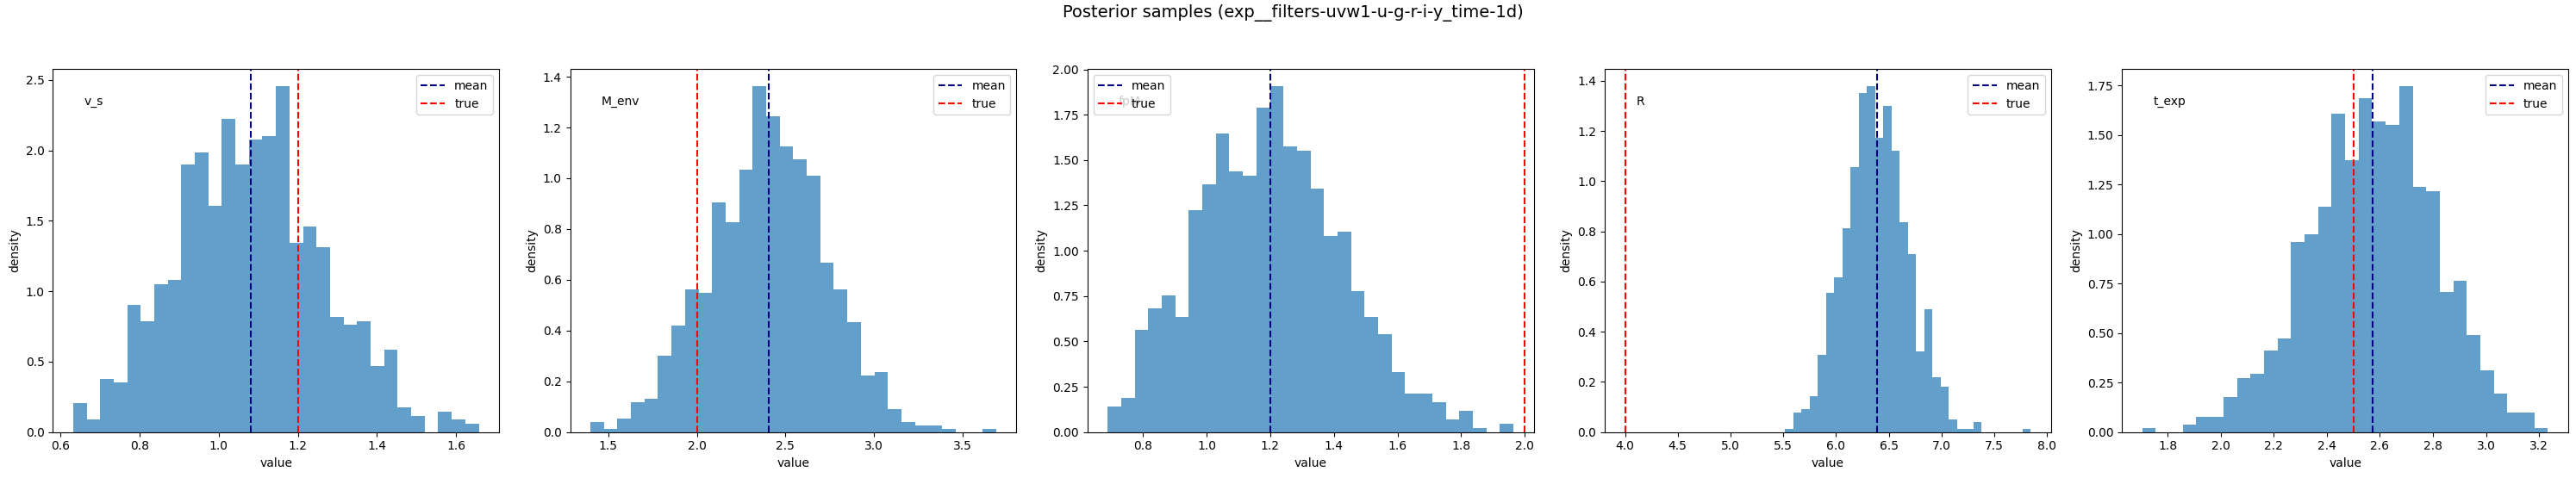

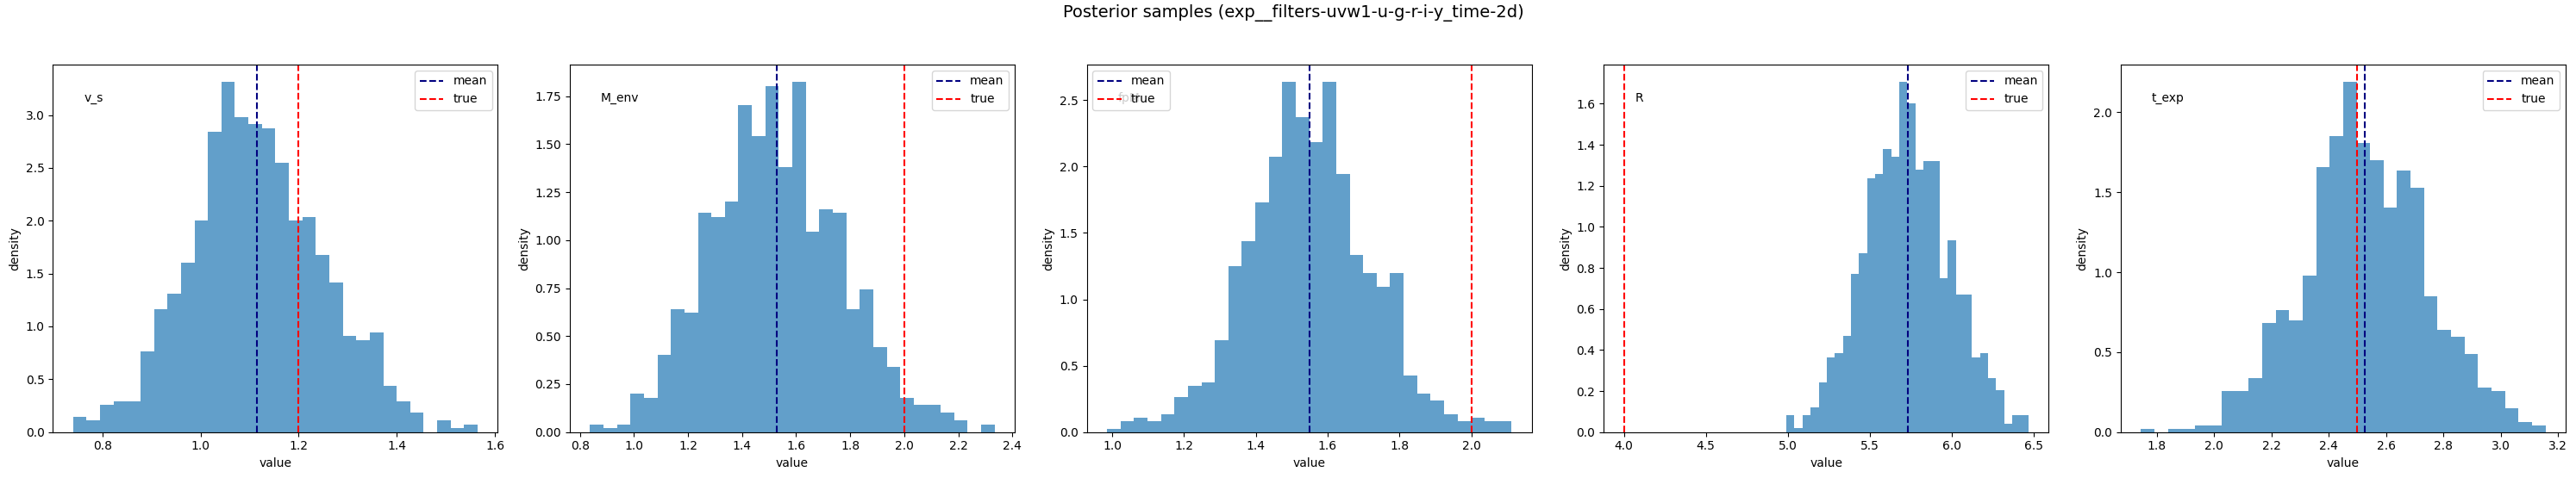

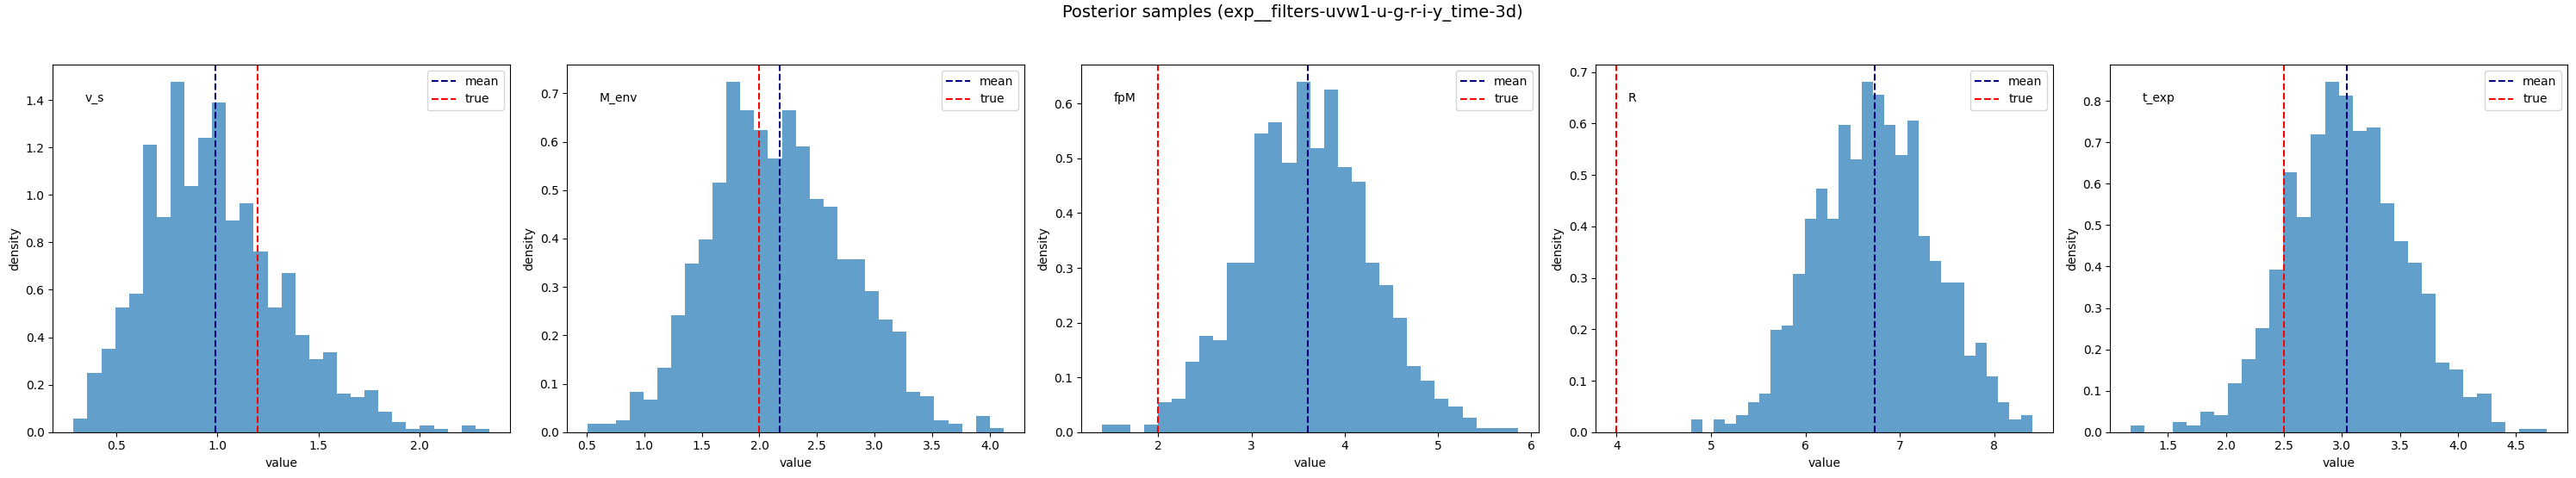

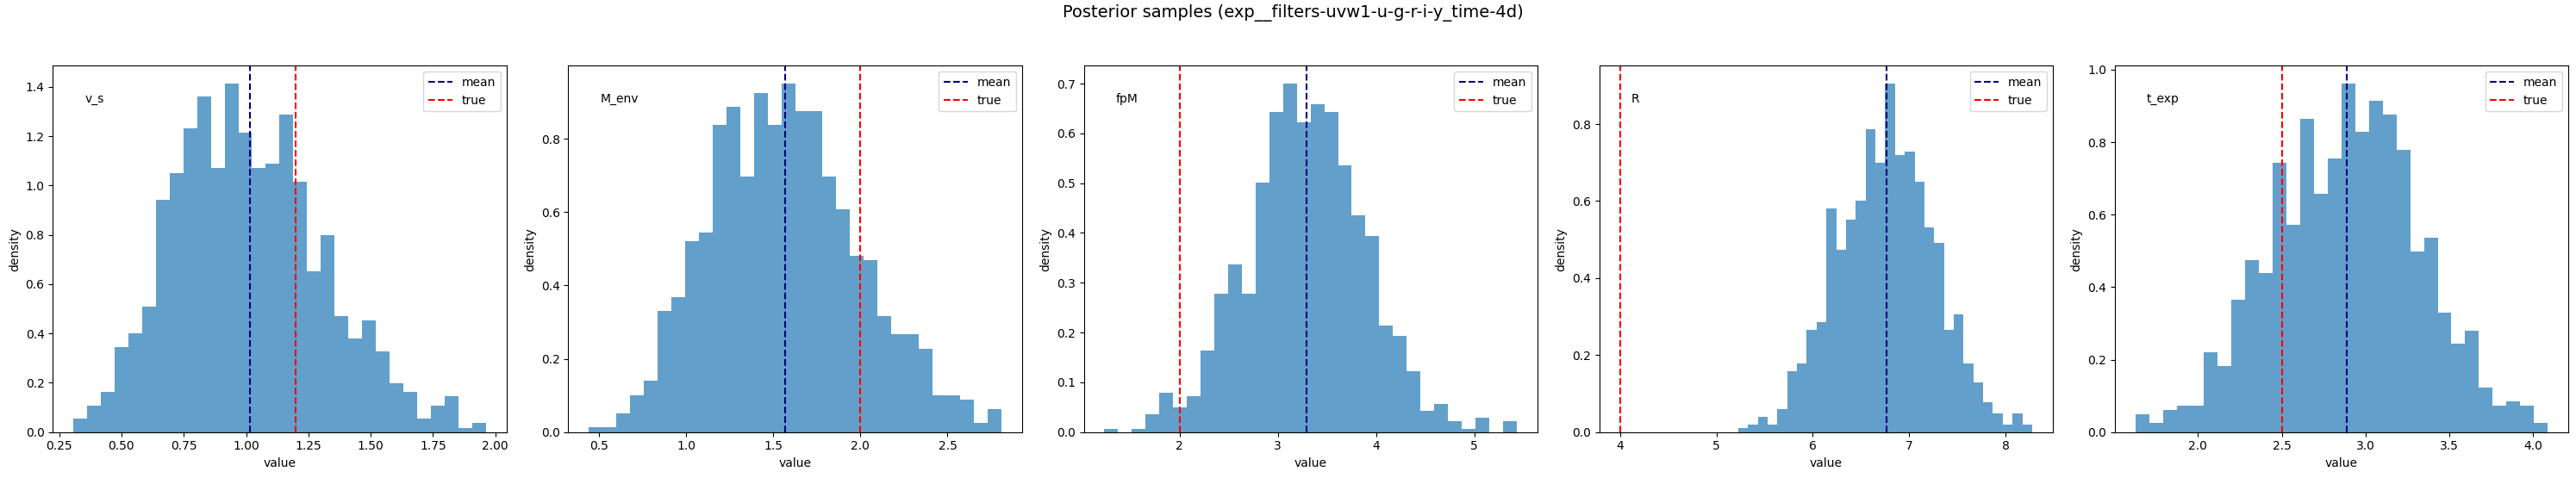

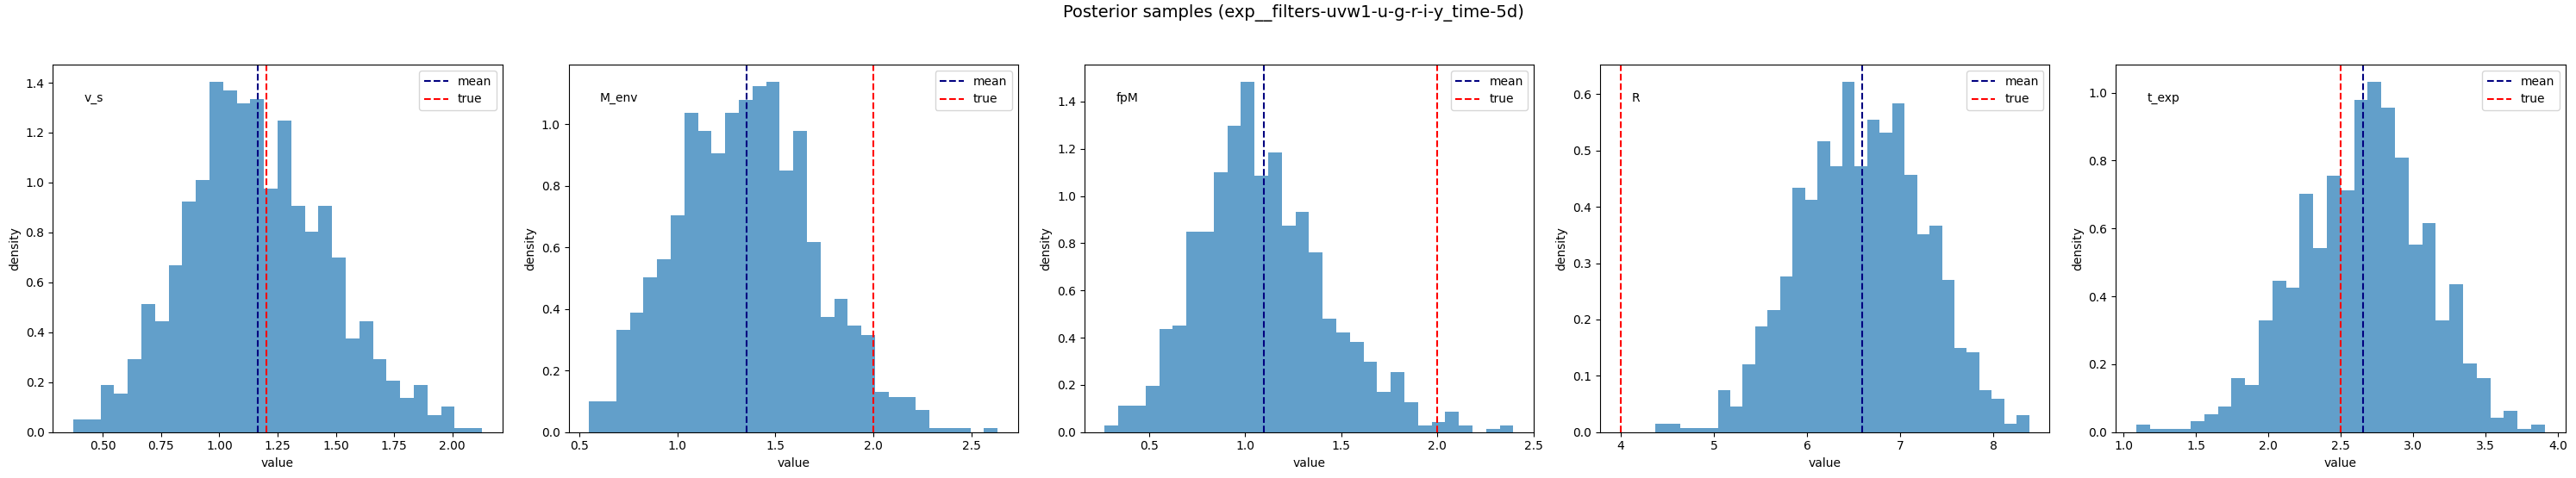

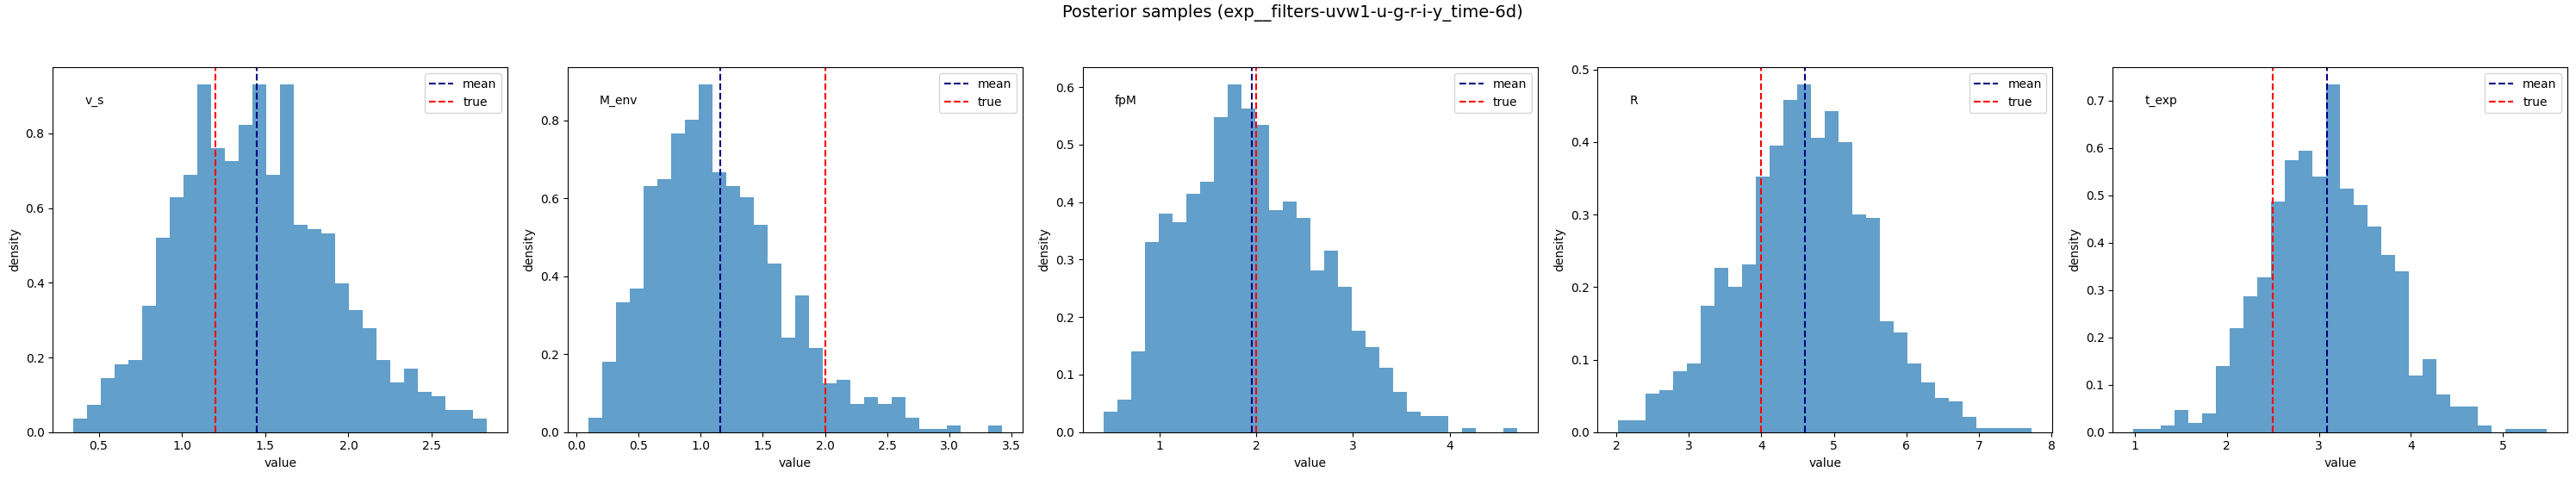

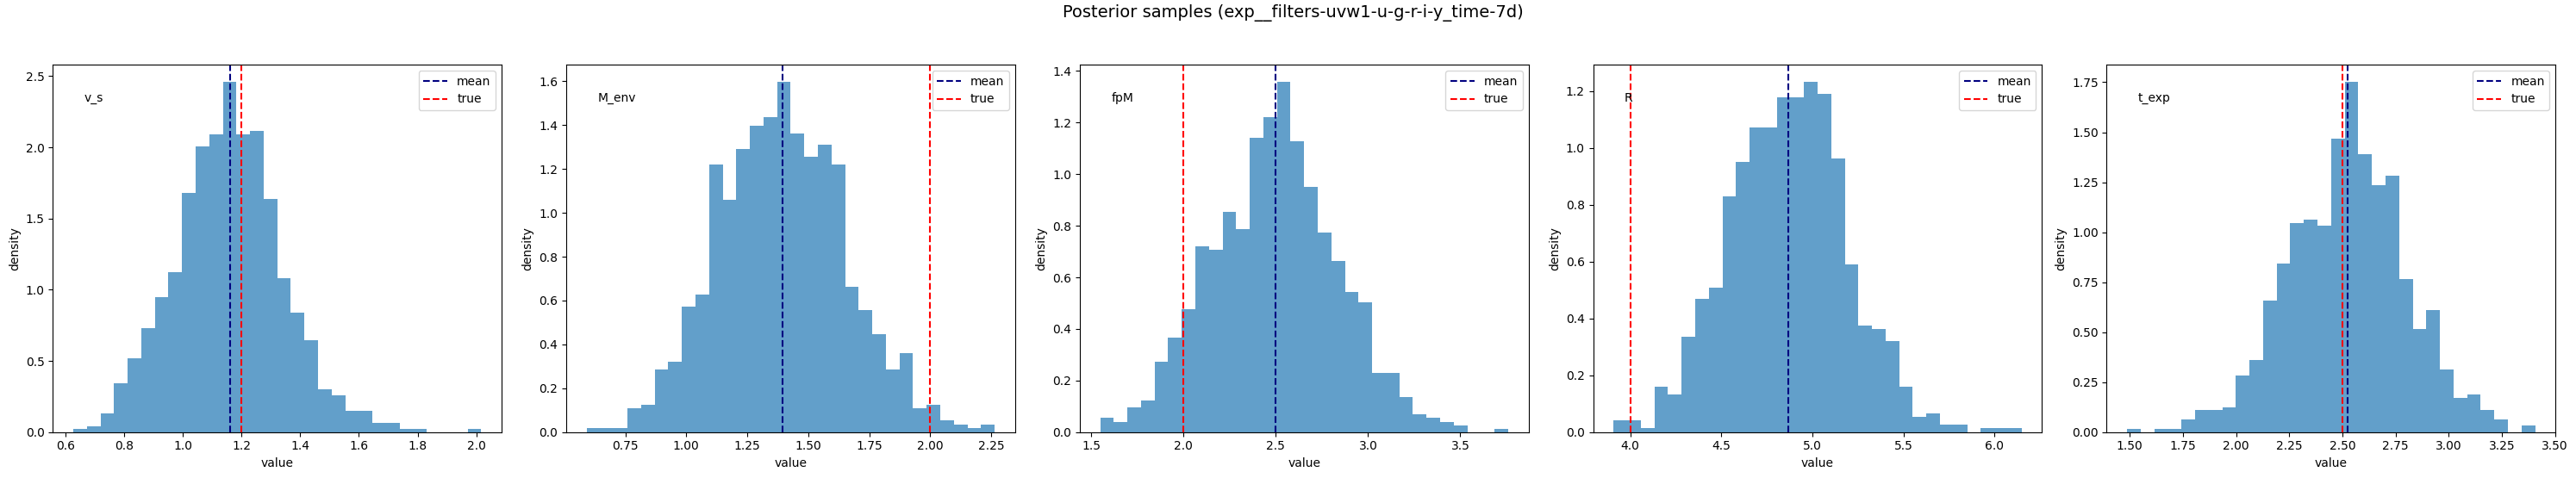

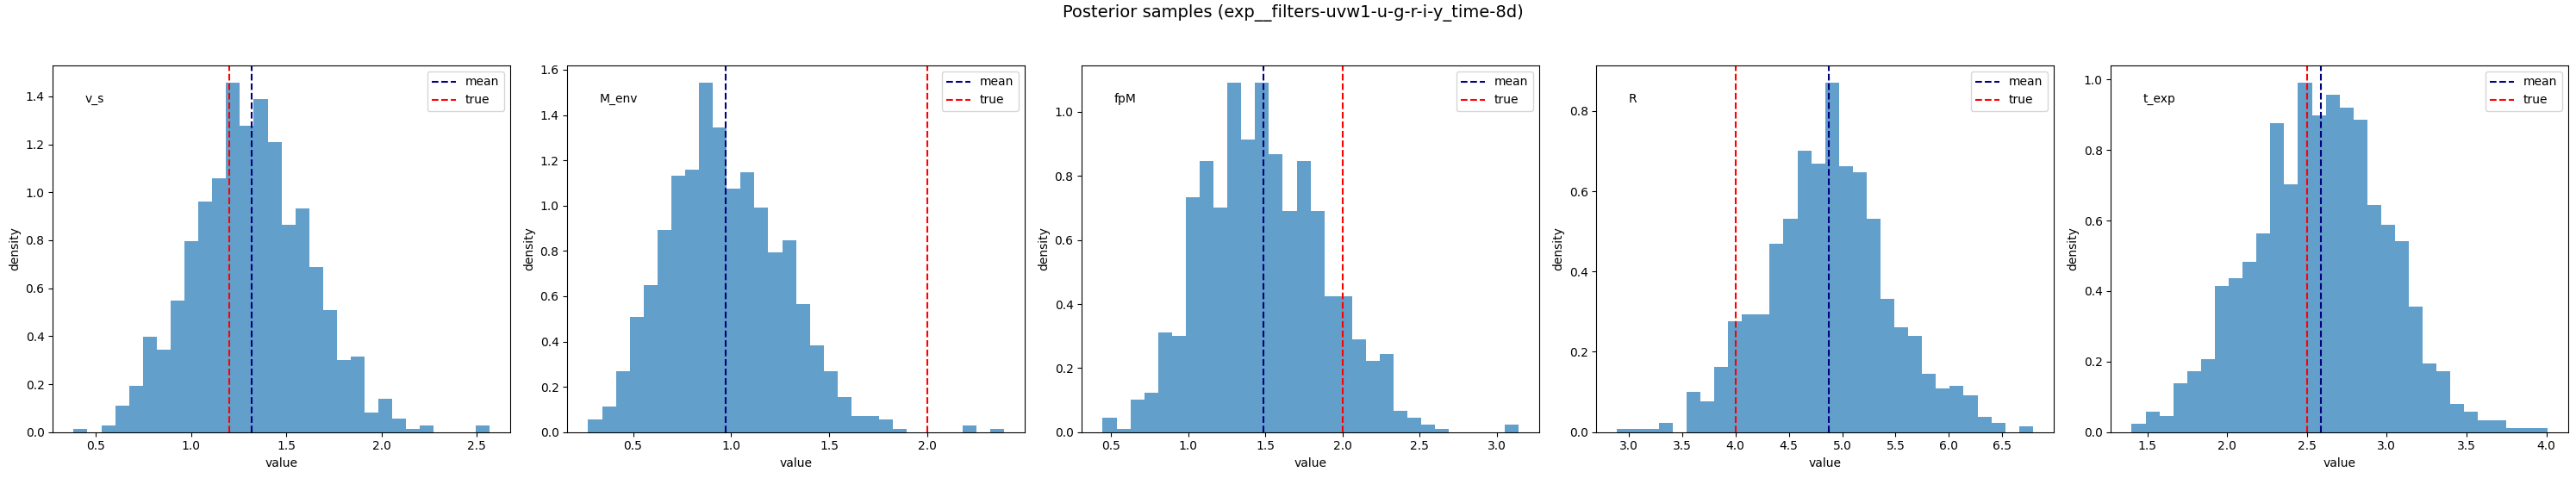

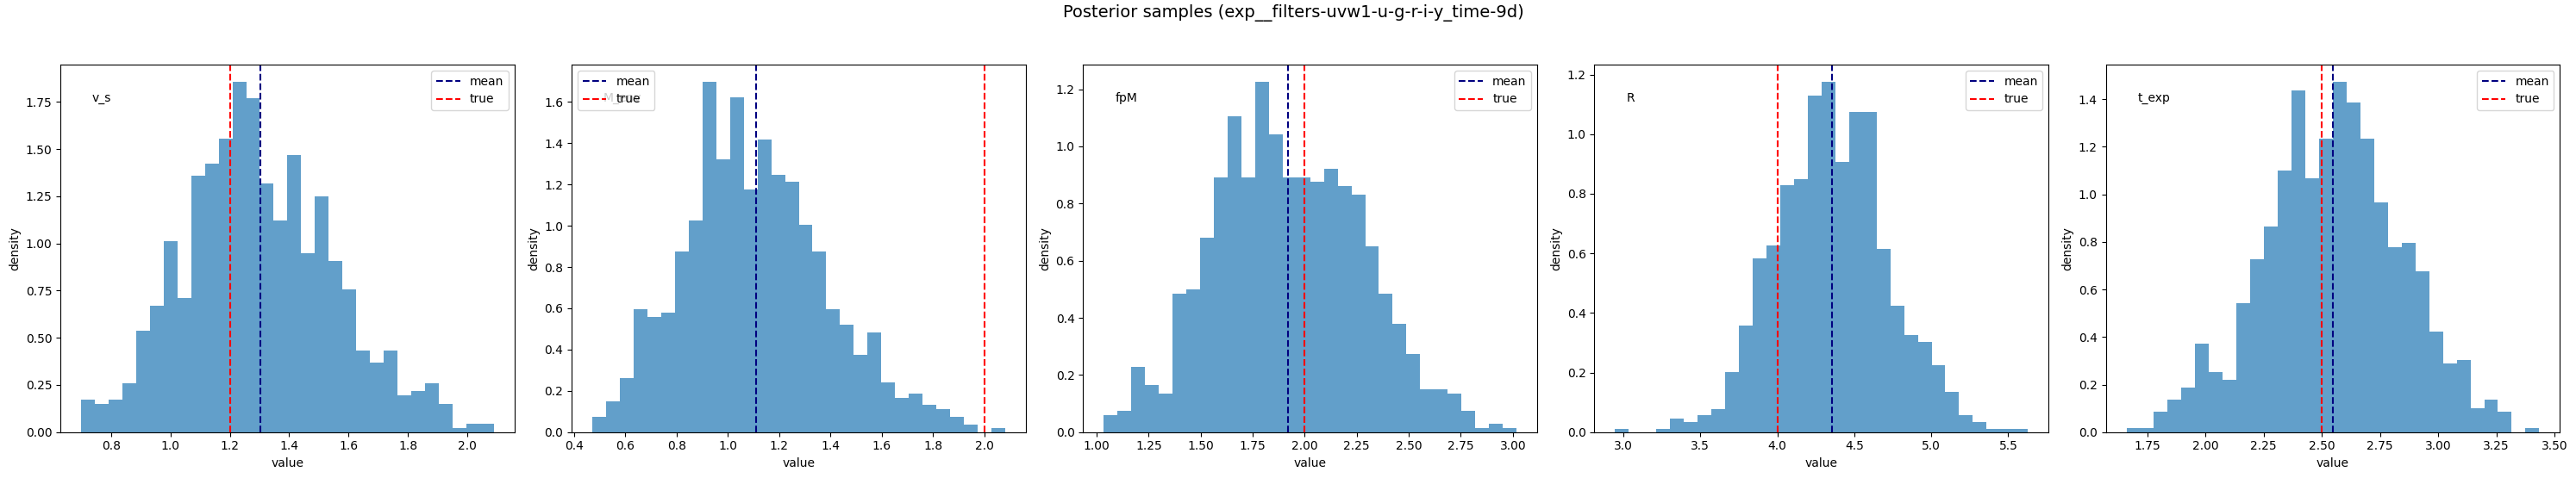

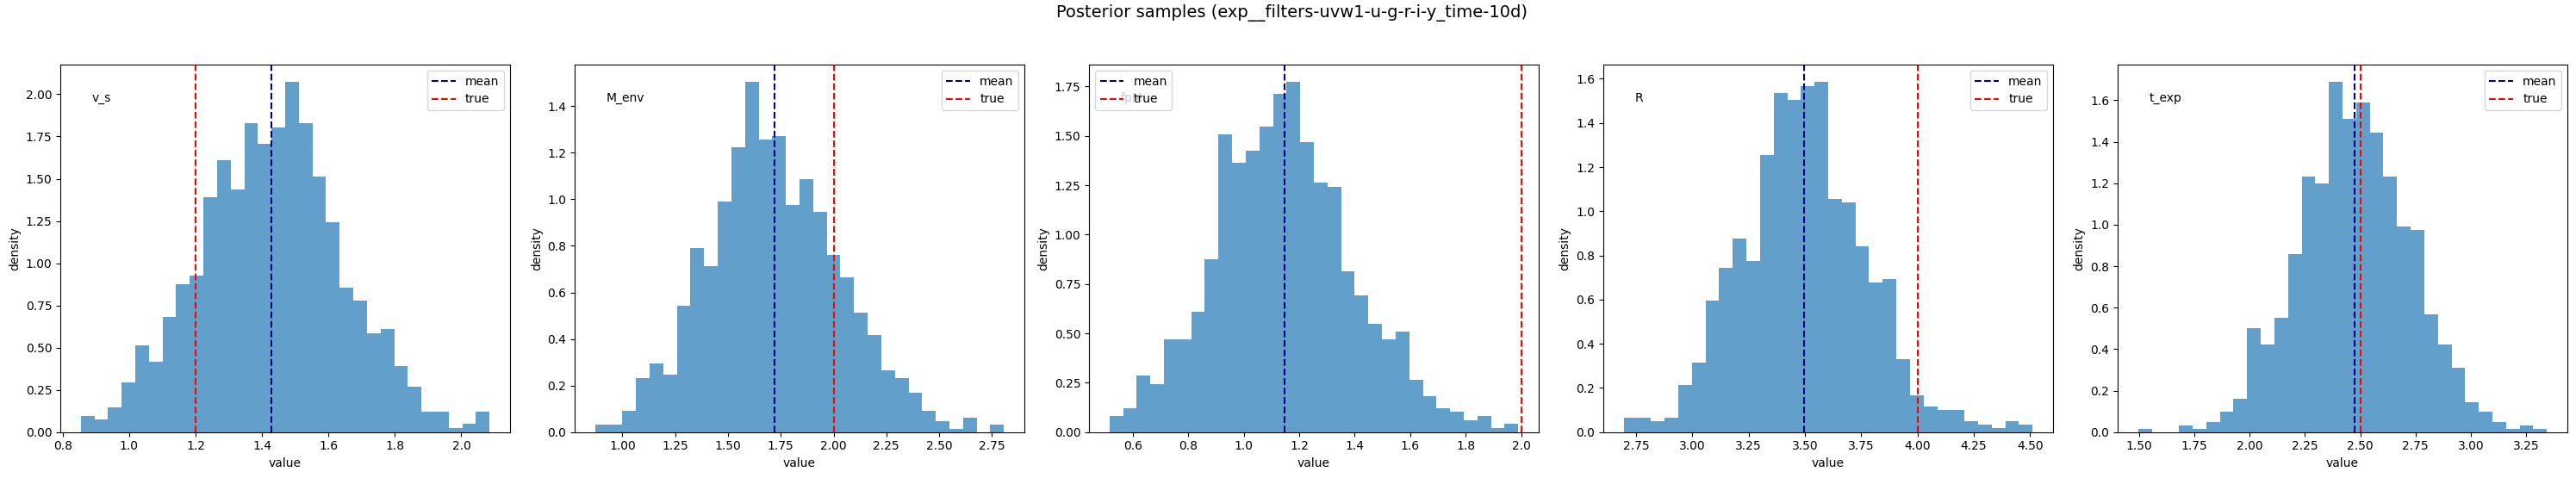

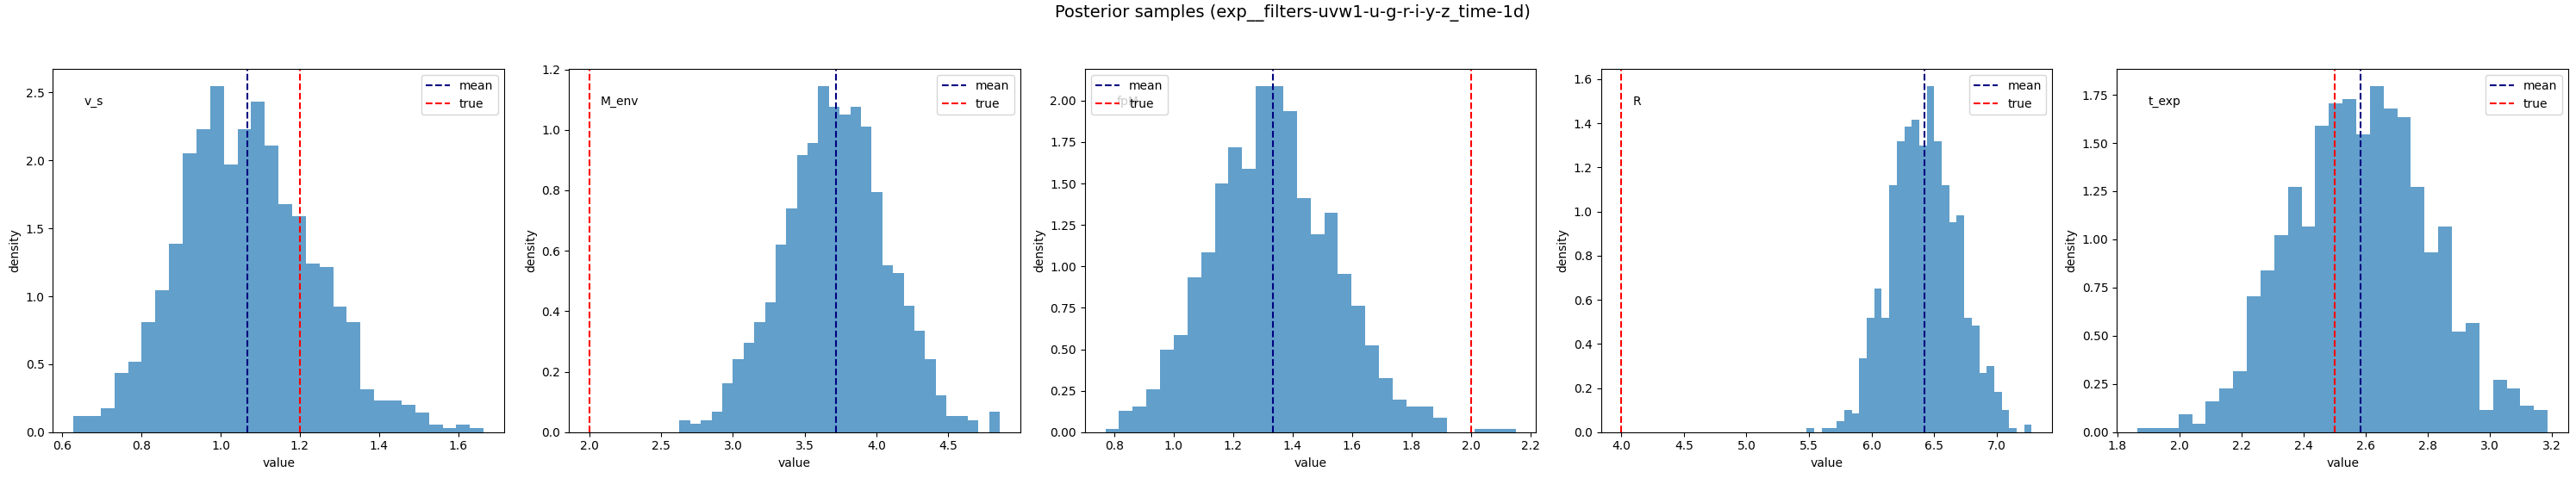

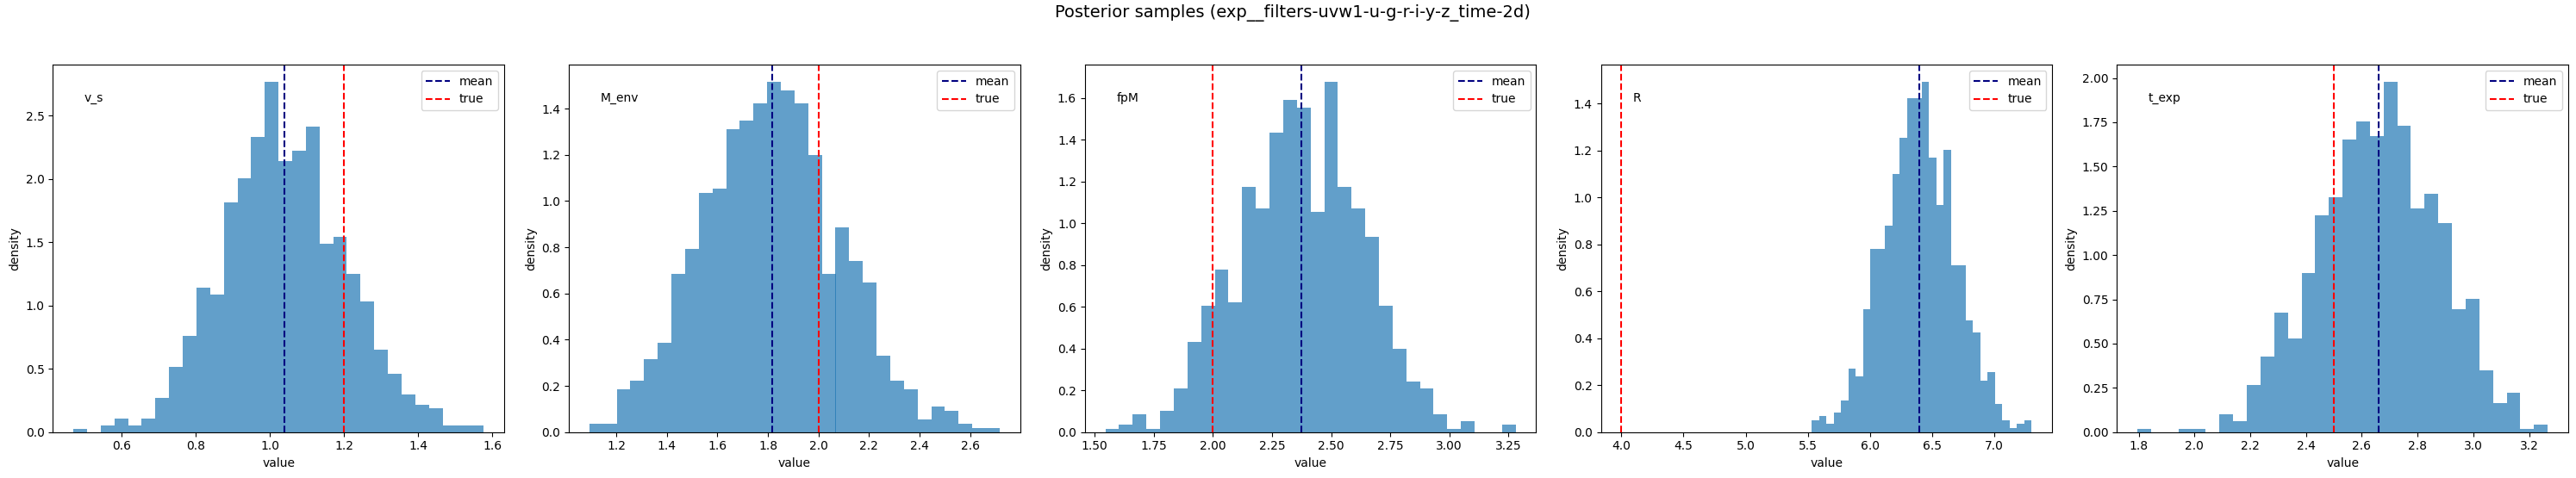

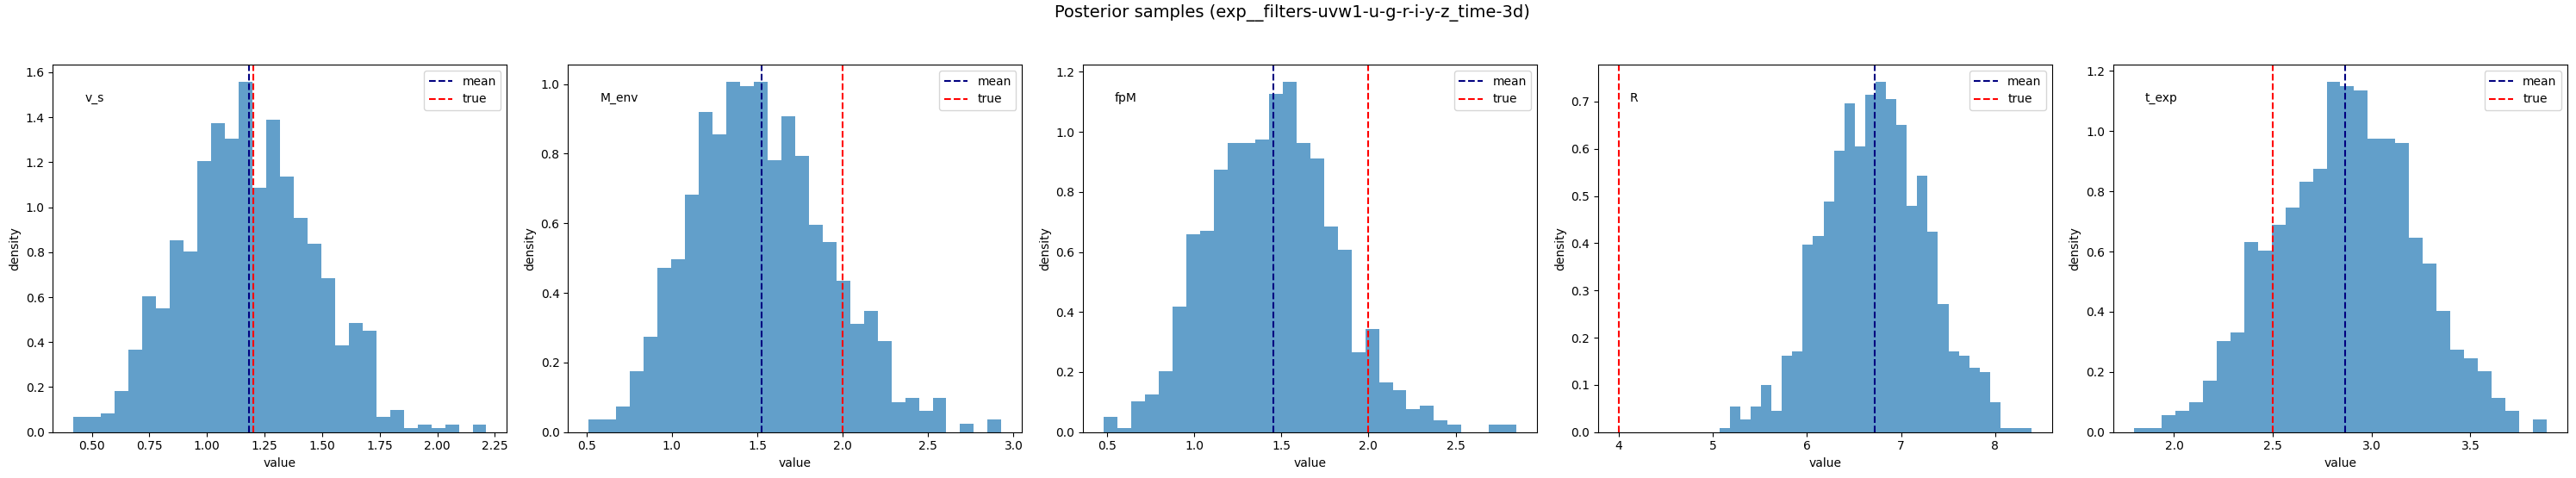

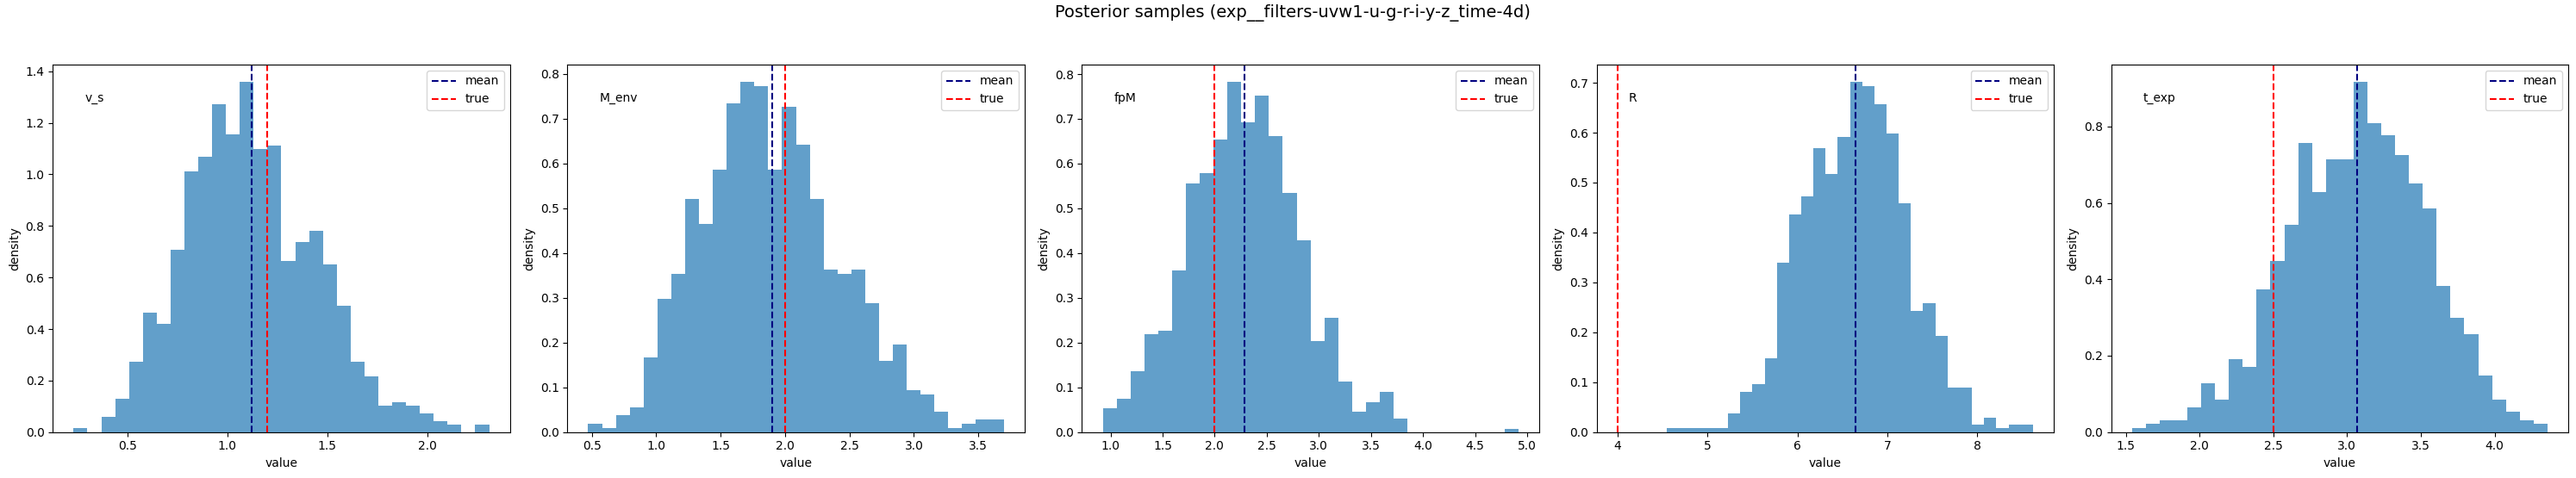

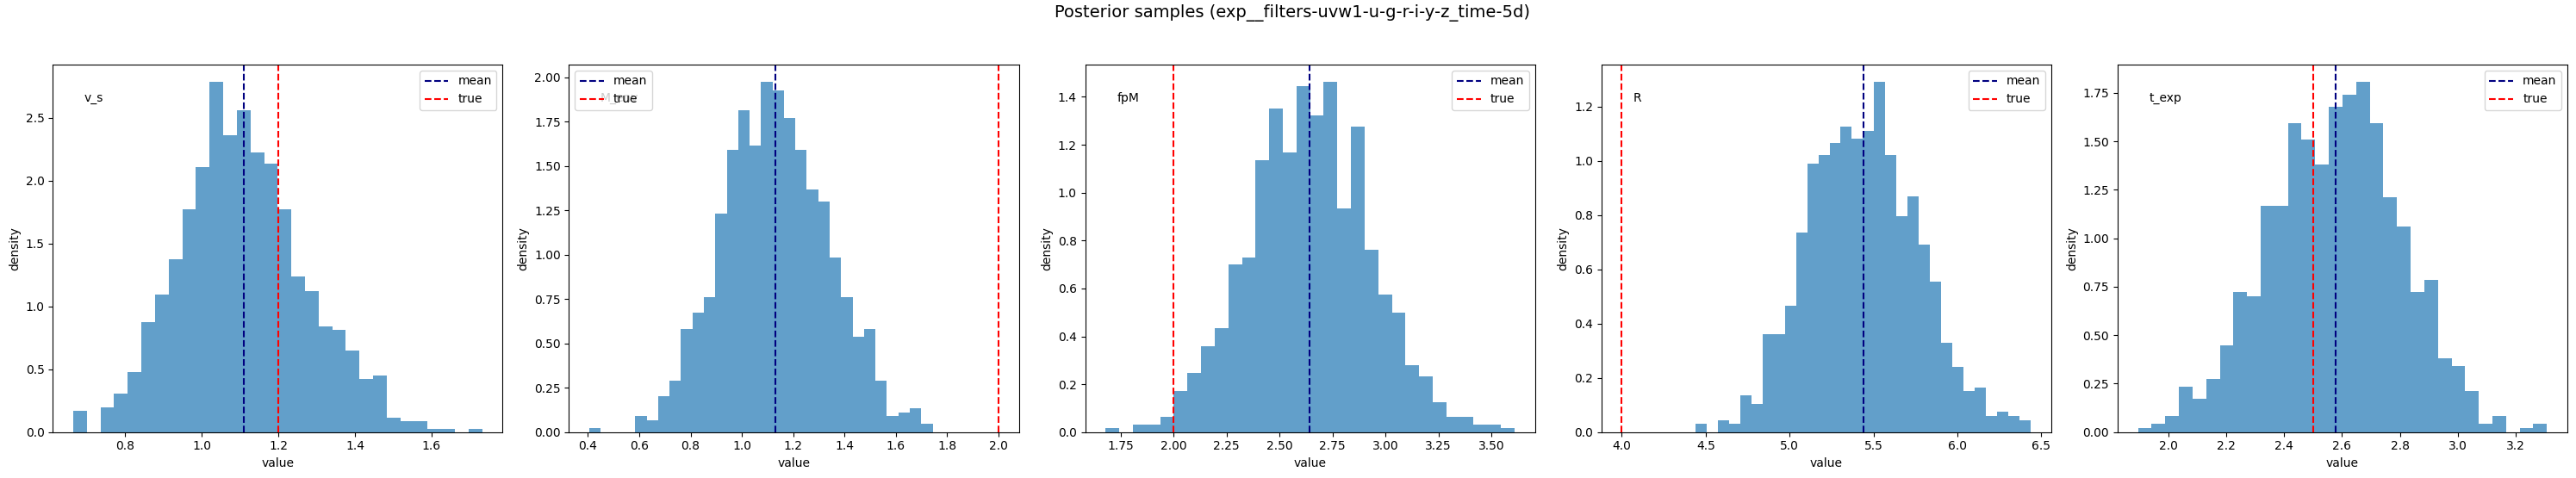

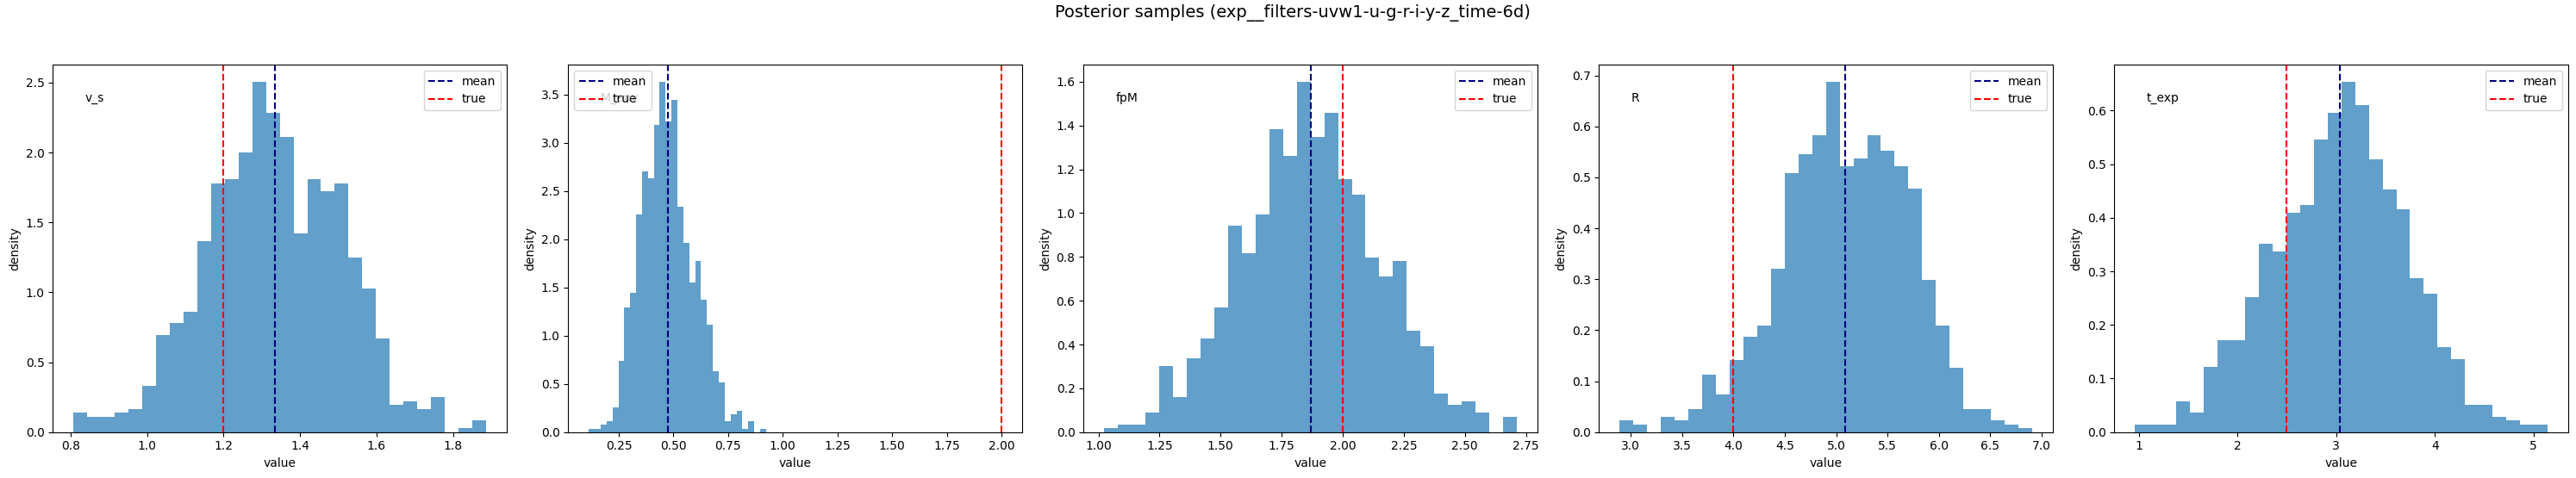

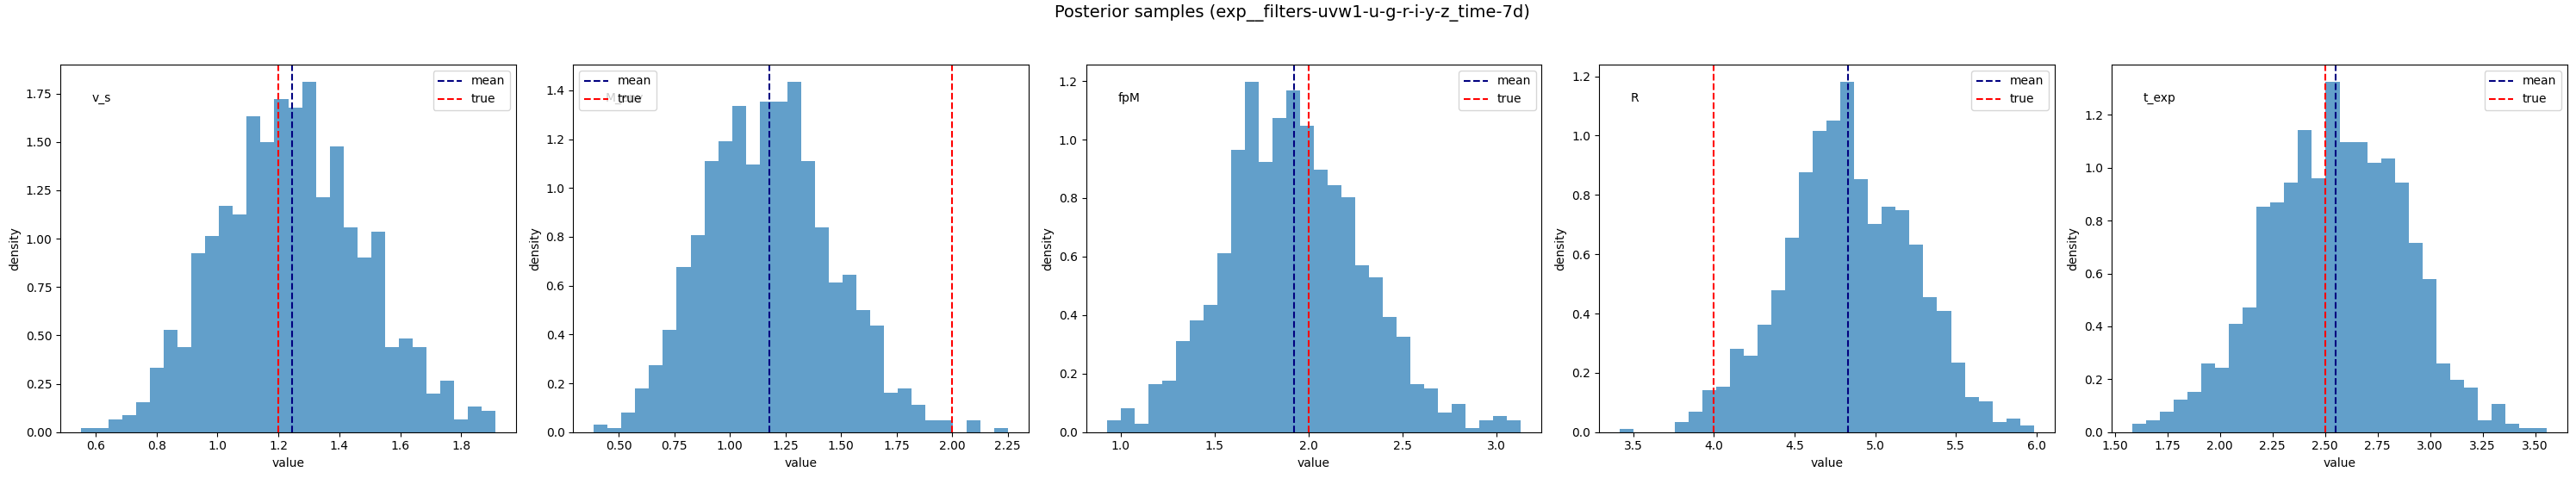

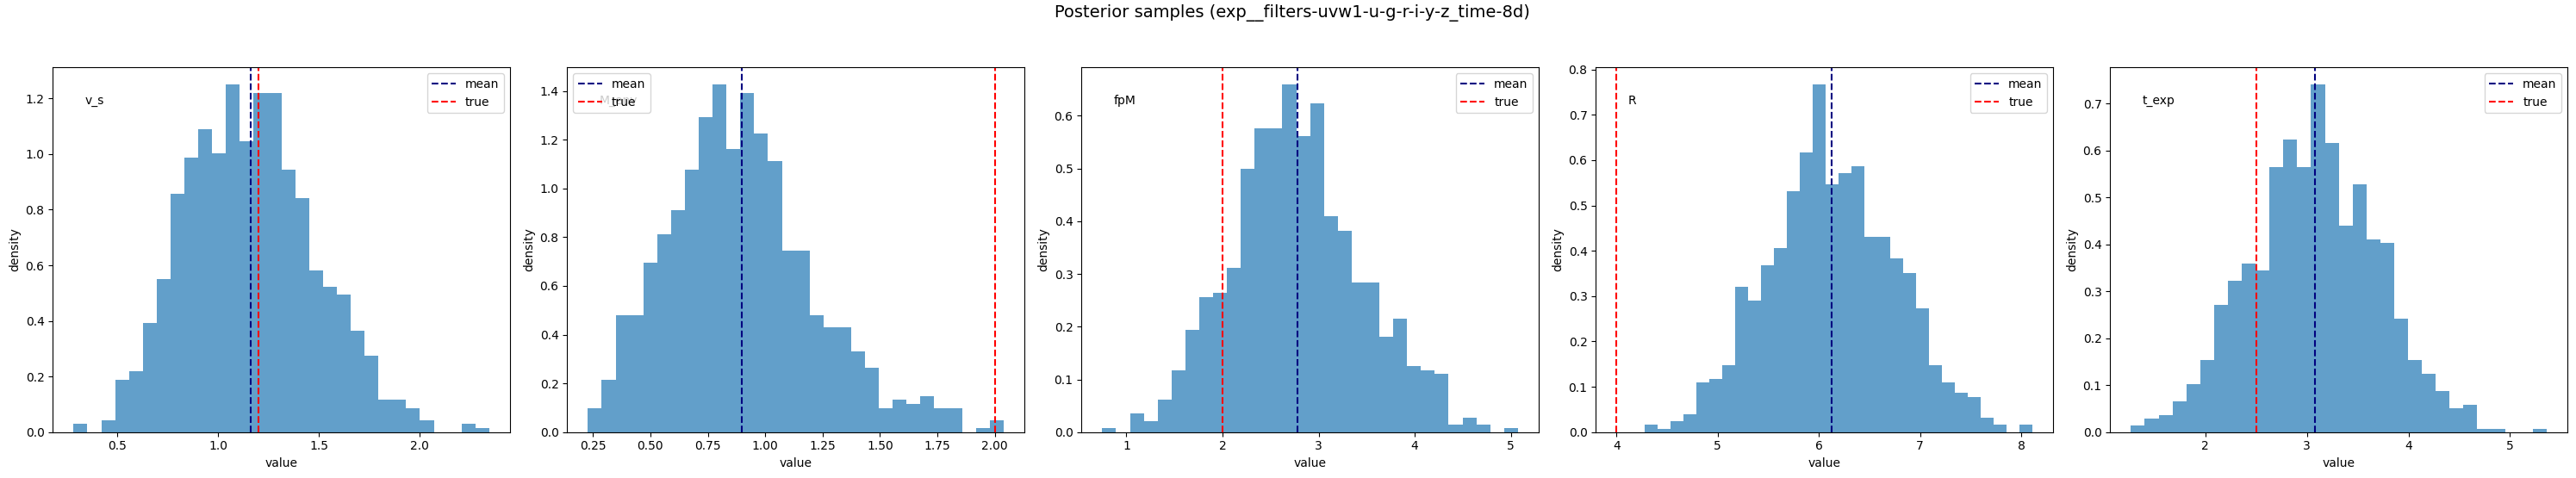

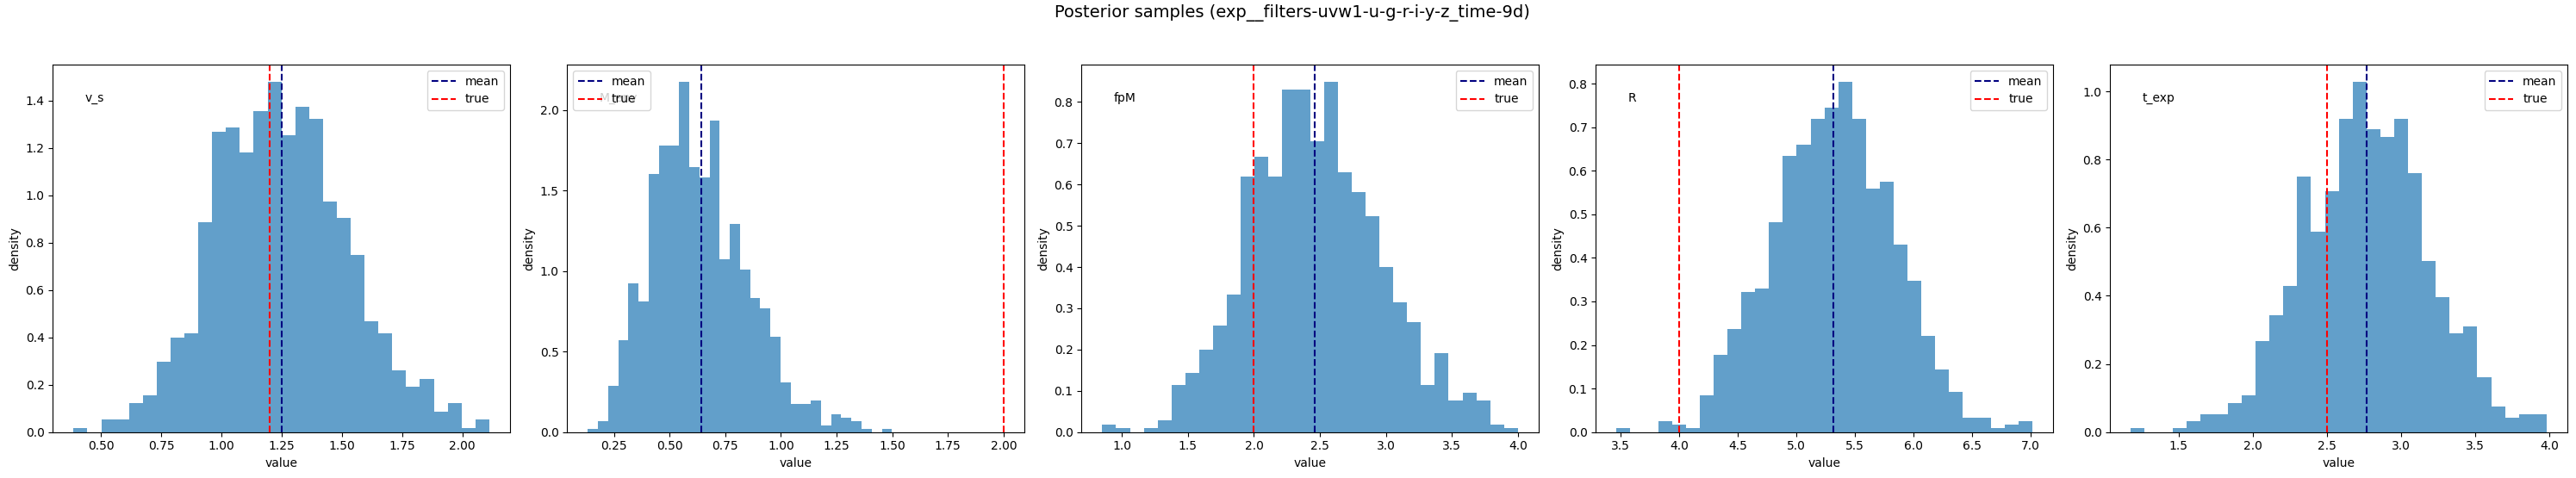

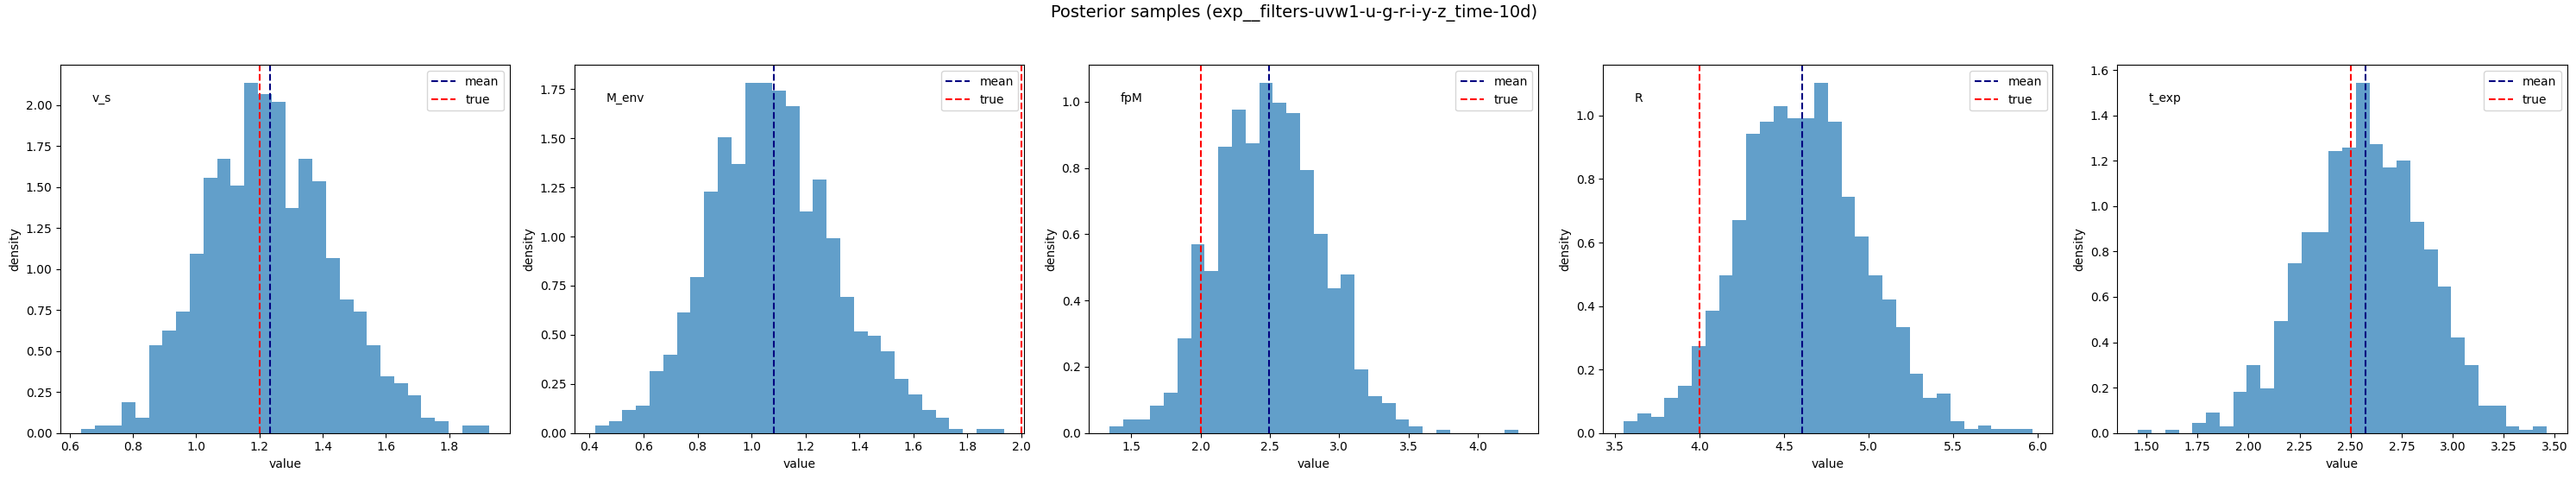

In [13]:

# ==============================================
# 📦 5. (Optional) Inspect posterior samples
# ==============================================

for expname in df["exp_name"]:
    example_exp = expname#df.iloc[-1]["exp_name"]
    samples_path = os.path.join(EXPERIMENTS_DIR, example_exp, "samples.npy")
    if os.path.exists(samples_path):
        samples = np.load(samples_path)
        param_names = ["v_s", "M_env",  "fpM","R", "t_exp"]
        mean = samples.mean(0)
        std = samples.std(0)
        true = builder.model_parameters
        fig, axes = plt.subplots(1, 5, figsize=(30, 5))
        for i, name in enumerate(param_names):
            axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
            axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
            axes[i].axvline(true[i], color="red", linestyle="--", label="true")


            axes[i].annotate(name, xy=(.07,.9), xycoords="axes fraction")
            axes[i].set_xlabel("value")
            axes[i].set_ylabel("density")
            axes[i].legend()

        plt.tight_layout()
        # plt.show()
        plt.annotate(
            f"Posterior samples ({example_exp})",
            xy=(0.5, 1.1),
            xycoords="figure fraction",
            ha="center",
            va="top",
            fontsize=14
        )        
        plt.show()
    else:
        print("No samples.npy found in", example_exp)

In [14]:
["z", "y", "i", "r", "g"]

['z', 'y', 'i', 'r', 'g']

/tf/ProjectGabriel/pilca/utils/analysis.py:68: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t_grid, np.log10(mod_vals.squeeze()) + offsets[filt], color=filtstyle["color"], alpha=0.05, zorder=0)
/tf/ProjectGabriel/pilca/utils/analysis.py:76: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t_grid, np.log10(mod_vals.squeeze()) + offsets[filt], lw=2, label=f"Median model - {filt}", c=filtstyle["color"])


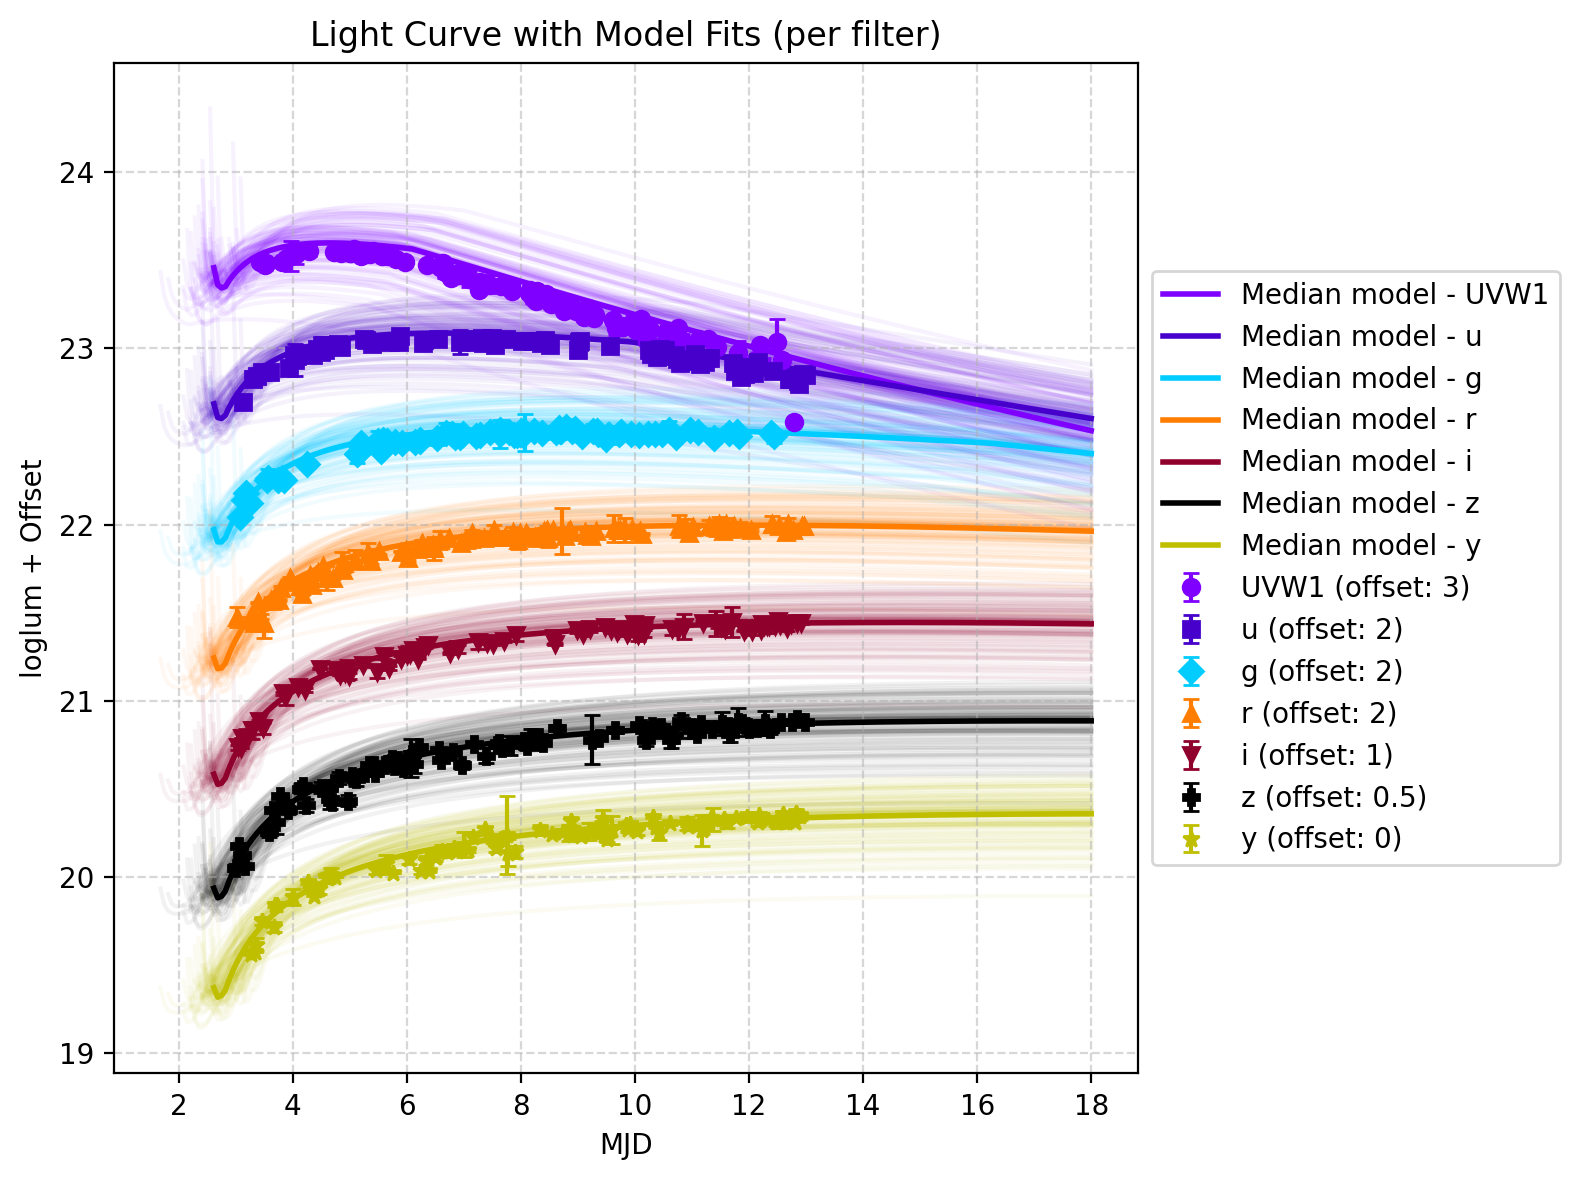

In [15]:
model = lcmd.ModifiedShockCooling4(lc)
an.lc_modeling_plot(lc=lc, samples=samples, model=model, ycol="loglum")